# Ames Housing Dataset - EDA and Feature Engineering and Encoding

> Gianmaria Pizzo - 872966@stud.unive.it

These notebooks represent the project submission for the course [Data and Web Mining](https://www.unive.it/data/course/337525) by Professor [Claudio Lucchese](https://www.unive.it/data/people/5590426) at [Ca' Foscari University of Venice](https://www.unive.it).

---

## Structure of this notebook

This notebook covers the following points
* Univariate, Bivariate and Multivariate analysis
* Outliers removal
* Probability Distribution Check
* Feature creation and transformation
* Feature Encoding
* Type Conversion

---

### Before running this notebook

To avoid issues, before running the following notebook it is best to
* Clean previous cell outputs
* Restart the kernel

---

# Explorative Data Analysis
The EDA is the first step to understanding the data and its nature. 

This includes analyzing the single features (Univariate Analysis), their interactions with the target (Bivariate Analysis) and their interactions with other features (Multivariate Analysis and Collinearity Check). 
However, the latter might be hard to compute as it requires the estimation of a regression model that follows certain assumptions and it is usually easier to check this when using linear models.

During my exploration I will look out for possible outliers, correlation and any other statistically relevant problem that might affect my final prediction.

We will start with the environment.

###  Environment, Imports and Global Variables and Functions

In [1]:
# Interactive
# %matplotlib notebook
# Static
%matplotlib inline

# Environment for this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
import IPython

# Set the style for the plots
sns.set()
plt.style.use('ggplot')
sns.set_style("darkgrid")
# Ignore warnings
warnings.filterwarnings('ignore') 

# Working folder
WORKING_DIR = os.getcwd()
# Resources folder
RESOURCES_DIR = os.path.join(os.getcwd(), 'resources')
# Name of file
IN_LABEL = 'ames_housing_out_0.csv'
ORIG_LABEL = 'ames_housing_out_0_orig.csv'

In [2]:
# Utils Module

def sort_alphabetically(dataset, last_label = None):
    """
    Sorts the dataset alphabetically and leaves last_label for last

    :param dataset: a pd.DataFrame
    :param last_label: a str containing an existing column label in the dataset
    :returns: pd.DataFrame
    """
    # Sort
    dataset = dataset.reindex(sorted(dataset.columns), axis=1)
    # Move target column to last index
    if last_label is not None:
        col = dataset.pop(last_label)
        dataset.insert(dataset.shape[1], last_label, col)
    return dataset

def get_cols(dataset, col_substring):
    """
    Returns the dataset having only the columns matching the substring, that are in the dataset
    
    :param dataset: pandas.DataFrame
    :param col_substring: a list of str
    :returns: a list of columns present inside dataset, matching the substring
    """
    if col_substring is not None:
        all_columns = list(dataset.columns)
        # Add only if in dataset
        col_lst = [i for i in all_columns if col_substring in i]
        return col_lst
    return None

def drop_if_exists(dataset, to_drop: list, inplace=True):
    """
    Drops rows from list to_drop if they are found inside the dataset
    
    :param dataset: a pd.DataFrame
    :param to_drop: a list of str containing existing column labels in the dataset to drop
    :param inplace: a boolean representing whether to drop column in place, if True it returns None
    :returns: None if inplace is True, else a pd.DataFrame without the columns in to_drop (if present in dataset)
    """
    all_columns = list(dataset.columns)
    # Include only columns that are existing 
    cols_to_drop = [i for i in all_columns if i in to_drop]
    if cols_to_drop is not None:
        if inplace:
            return dataset.drop(columns = cols_to_drop, inplace=inplace)
        return dataset.drop(columns = cols_to_drop, inplace=inplace)
    pass

def drop_rows_cond(dataset, condition, inplace = True):
    """
    Drops rows on boolean condition and resets index
    
    :param dataset: pandas.DataFrame
    :param condition: boolean condition between braces, regarding this dataset (such as: (dataset['Label']!=0) )
    :param inplace: boolean
    :returns: pandas.DataFrame if inplace = False, else None
    """
    rows_to_drop = dataset[condition].index.tolist()
    if inplace:
        dataset.drop(rows_to_drop, inplace=inplace)
        dataset.reset_index(drop=True, inplace=inplace)
    else:
        return dataset.drop(rows_to_drop)

In [3]:
from scipy import stats
from scipy.stats import probplot

# Module for numerical variables
def get_df_wo_outliers(dataset: pd.core.frame.DataFrame , label: str, threshold=(0.05,99.95)):
    """
    Returns a copy of the given dataset, after removal of the extreme values specified for a numeric label
    
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param threshold: tuple of 2 float representing the extremes to drop
    : returns: pd.core.frame.DataFrame
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(threshold) != tuple or len(threshold) != 2) or (type(threshold[0]) != float or type(threshold[1]) != float):
        raise Exception("Threshold must be an float tuple of length 2")
    if threshold[0] > threshold[1]:
        raise Exception("The element in position 0 should smaller than the one in position 1")
    if threshold[0] < 0.0 or threshold[1] > 100.0:
        raise Exception("Threshold out of range")
    
    stats_dict = dataset[label].describe().to_dict()
    uppr = np.percentile(dataset[label].values, float(threshold[1]))
    lwr = np.percentile(dataset[label].values, float(threshold[0]))
    return dataset.loc[(dataset[label] >= lwr) & (dataset[label] < uppr)]


def numeric_distr_plot(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots distribution of the given dataset's column specified in label
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
                               
    # Normal Distribution fit
    (mu, sigma) = stats.norm.fit(dataset[label])

    # Feature Distribution Plot
    plt.figure(figsize=shape)
    sns.distplot(dataset[label], hist=True, kde=True, fit=stats.norm, color='cornflowerblue')
    
    # Figure labels
    plt.title(label.replace("_", " ") + '\'s Distribution vs Normal Distribution', fontsize=14)
    plt.xlabel(label.replace("_", " "))
    plt.ylabel('Frequency in %')
    plt.legend(['Normal Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='upper right')
    plt.show()
    pass

def probability_plot(dataset: pd.core.frame.DataFrame , label: str):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    fig = plt.figure()
    res = stats.probplot(dataset[label], plot=plt)
    plt.show()
    pass

def scatterplot_distr(dataset: pd.core.frame.DataFrame , label: str, shape=(9.8, 6.0)):
    """
    Plots QQplot of target feature vs normal distribution
    :param dataset: pd.core.frame.DataFrame
    :param label: str representing an existing column
    :param shape: tuple of 2 float representing the shape of the figure
    :returns: None
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    if (type(shape) != tuple or len(shape) != 2) or (type(shape[0]) !=float or type(shape[1]) !=float):
        raise Exception("Threshold must be an float tuple of length 2")
        
    plt.figure(figsize=shape)
    plt.scatter(range(dataset[label].shape[0]), np.sort(dataset[label].values))
    plt.title(label + '\'s Scatter Plot')
    plt.xlabel('Index', fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.show()
    pass

In [4]:
# Functions to display time changes

def seasonality_df(dataset, target, years_col, months_col):
    """
    Ad-hoc function to get stats about target by year and month
    """
    
    d = dataset[[target, years_col, months_col]].groupby([years_col, months_col]).describe()
    d.columns = d.columns.droplevel()
    d = d.reset_index()
    return d.drop(columns=['std', '25%', '75%']).rename(columns={'50%':'median'})


def target_by_year_month(dataset, target, highlight):
    """
    Pretty display of changes in target by month and year
    
    """
    d = seasonality_df(dataset=dataset, target=target, years_col='Year_Sold',
                      months_col = 'Mo_Sold')
    
    grid = sns.FacetGrid(d, 
                         col="Year_Sold",
                         palette="tab20c", 
                         col_wrap=5, height=3)

    grid.map(plt.plot, "Mo_Sold", highlight, marker="o")
    
    grid.set(xticks=np.arange(13),
             xlim=(0, 13), 
             xlabel ='Month', ylabel= highlight.capitalize())
    
    grid.fig.tight_layout(w_pad=0.5)
    pass

In [5]:
# Module for correlation analysis
def display_corr_matrix(dataset: pd.core.frame.DataFrame, label: str, exclude = None):
    """
    Displays the correlation matrix and returns it
    : param dataset: pd.core.frame.DataFrame
    : param label: str representing an existing column
    : param exclude: list of str of features to exclude
    : returns: correlation matrix
    """
    if dataset.empty or not isinstance(dataset, pd.core.frame.DataFrame):
        raise Exception("Dataset is either empty or not a valid pandas DataFrame")
    if not isinstance(label, str):
        raise Exception("label is not a string")
    if label not in dataset.columns:
        raise Exception("label not in dataset")
    if dataset[label].dtype == object:
        raise Exception("Categorical features are not allowed")
    
    if exclude is not None:
        if type(exclude) == list:
            for i in exclude:
                if type(i)!= str:
                    raise Exception("exclude must be a list of string")
                if i not in dataset.columns:
                    raise Exception(i + " is not a valid column label")
        else:
            raise Exception("exclude must be a list")
            
    # Move target column to last index
    col = dataset.pop(label)
    dataset.insert(dataset.shape[1], label, col)

    plt.figure(figsize=(20,20))
    
    matrix = dataset.corr()

    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.2f', square=True, cmap=cmap)
    return matrix


def top_correlated_features(corr_matrix, label, threshold=0.45):
    """
    Returns a dictionary of the top correlated features with label, inside the dataset, for a certain threshold
    
    """
    
    m = corr[label].sort_values(ascending=False).to_dict()
    corr_dict = {}
    
    for k in m:
        if label in k:
            continue
        else:
            v = m.get(k)
            if v >= threshold or v <= (-threshold):
                corr_dict.update({k:v})
    return corr_dict


def display_correlation(sample_dict, exclude=None):
    """
    Prints the correlated features for all the top correlated features with the target
    
    """
    for k in sample_dict:
        print("Top correlated features with \"{0}\"".format(k))
        temp = top_correlated_features(corr, k, .60)
        for k in temp:
            if exclude is not None and k in exclude:
                continue
            print("\t{0} : {1}".format(k, temp.get(k)))
        print("\n")
    pass

In [6]:
# Module for categorical variables
def scatterplot_single(dataset, target, label, hue=None):
    """
    Quick ad hoc function to display a scatterplot
    
    """
    sns.lmplot(data=dataset, x=target, y=label, aspect=1.5, scatter=True, hue=hue)
    pass

def scatterplot_multiple(dataset, target, labels, plot_cols=1, notebook_fig_size=None, adjust=None, hue=None):
    """
    Quick ad hoc function to display multiple scatterplots
    
    """
    
    fig, axes = plt.subplots(nrows = int(np.ceil(len(labels)/plot_cols)), ncols = plot_cols)

    # Flat 1-D flat iterator over the array.
    axes = axes.flatten()

    # Notebook figure dimensions
    if notebook_fig_size is None:
        # Default
        fig.set_size_inches(9, 8*plot_cols)
    else:
        fig.set_size_inches(notebook_fig_size.get('width'), notebook_fig_size.get('height'))

    # Plot 
    for ax, col in zip(axes, dataset.loc[:, dataset.columns.isin(labels)].columns):
        sns.regplot(data=dataset, x=target, y=col, fit_reg=True, scatter=True, ax=ax)
        ax.set_title(col + " vs " + target, fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel(target)

    # Adjust 
    if adjust is None:
        # Default
        plt.subplots_adjust(left=0.2, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.5)
    else:
        plt.subplots_adjust(left=adjust.get('left'), right=adjust.get('right'), 
                            top=adjust.get('top'), bottom=adjust.get('bottom'),
                            wspace=adjust.get('wspace'), hspace=adjust.get('hspace'))
    pass


def stripplot_single(dataset, target, categ_feat, figsize=None):
    """
     Quick ad hoc function to display stripplot
    
    """
    
    if figsize is None:
        fig, ax = plt.subplots(figsize=(11,7))
    else:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(y=categ_feat, x=target, data =dataset, jitter = True, dodge = True, ax=ax)
    pass

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Module for Encoding

def ordinal_encoding(dataset, ord_mapping):
    """
    Ad hoc function for ordinal encoding with a mapping dictionary
    
    """
    
    columns = list(dataset.columns)
    for col in ord_mapping:
            label = list(col.keys())[0]
            if label in columns:
                ordered_values = col.get(label)
                encoder = OrdinalEncoder(categories=[ordered_values])
                dataset[[label]] = encoder.fit_transform(dataset[[label]])
            else:
                continue
    pass


def ohe_encoding(dataset, categorical_features, inplace=True):
    """
    
    Ad hoc function to perform OHE 
    
    """
    obj_columns = list(dataset.select_dtypes(object).columns)
    to_encode = [i for i in obj_columns if i in categorical_features]
    
    encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
    
    for col in to_encode:
        transformed = encoder.fit_transform(dataset[[col]])
        dataset[encoder.categories_[0]] = transformed.toarray()
    if inplace:
        dataset.drop(columns=to_encode, inplace=inplace)
    pass

def quick_categ_binning(dataset, target:str, name_like:str, bins:list):
    i = 1
    for b in bins:
        dataset[[target]] = dataset[[target]].replace(to_replace=b, value = name_like +str(i))
        i+=1
    pass

def dummy_encoding(dataset, target_feat, new_feat_name, index_col_drop):
    """
    Ad-hoc function for dummy encoding
    
    """
    # Get Dummies
    temp = pd.get_dummies(dataset[target_feat])
    # Drop the column
    temp = temp.drop(temp.columns[[index_col_drop]], axis=1)
    dataset[new_feat_name] = temp.replace(np.nan, 0.0)
    dataset[new_feat_name] = dataset[new_feat_name].astype('float32')
    if target_feat != new_feat_name:
        dataset.drop(labels=target_feat, axis=1, inplace=True)
    pass

def set_labels_type(dataset, labels, np_type):
    """
    Ad-hoc function for type conversion
    
    """
    type_dict = {}
    for i in labels:
        type_dict.update({i:np_type})
    return dataset.astype(type_dict)

In [8]:
# Sorted ordinal mapping for ordinal features
ordinal_mapping = [
    {'BsmtFin_Type_1':['No_Basement', 'Unf', 'LwQ','Rec', 'BLQ', 'ALQ', 'GLQ']},
    {'BsmtFin_Type_2':['No_Basement', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']},
    {'Bsmt_Cond': ['No_Basement','Poor', 'Fair', 'Typical','Good','Excellent']},
    {'Bsmt_Exposure':['No_Basement', 'No', 'Mn', 'Av','Gd']},
    {'Bsmt_Qual':['No_Basement', 'Poor', 'Fair', 'Typical', 'Good', 'Excellent']},
    {'Exter_Cond':[ 'Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Exter_Qual':['Fair', 'Typical', 'Good',  'Excellent']},
    {'Fence':['No_Fence', 'Minimum_Wood_Wire', 'Good_Wood','Minimum_Privacy', 'Good_Privacy']},
    {'Fireplace_Qu':['No_Fireplace','Poor',  'Fair', 'Typical','Good', 'Excellent']},
    {'Functional':['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2','Min1','Typ' ]},
    {'Garage_Cond':['No_Garage', 'Poor', 'Fair','Typical', 'Good','Excellent']},
    {'Garage_Finish':['No_Garage','Unf', 'RFn', 'Fin', 'Typical']},
    {'Garage_Qual':['No_Garage','Poor' , 'Fair','Typical', 'Good', 'Excellent']},
    {'Heating_QC':['Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Kitchen_Qual':['Poor', 'Fair', 'Typical', 'Good',  'Excellent']},
    {'Land_Contour':['Low','HLS','Bnk','Lvl']},
    {'Land_Slope':['Sev', 'Mod', 'Gtl']},
    {'Lot_Shape':['Irregular', 'Moderately_Irregular', 'Slightly_Irregular', 'Regular']},
    {'Overall_Cond':[ 'Very_Poor', 'Poor', 'Fair', 'Below_Average', 'Average', 'Above_Average', 'Good', 'Very_Good', 'Excellent']},
    {'Overall_Qual':['Very_Poor', 'Poor','Fair', 'Below_Average', 'Average', 'Above_Average', 'Good', 'Very_Good', 'Excellent', 'Very_Excellent']},
    {'Paved_Drive':['Dirt_Gravel', 'Partial_Pavement', 'Paved']},
    {'Pool_QC':['No_Pool', 'Fair', 'Typical', 'Good', 'Excellent']}]

# nominal features for OHE
nominal_features=['Alley', 'Bldg_Type', 'Condition_1', 'Condition_2', 
                  'Electrical', 'Exterior_1st', 'Exterior_2nd', 'Foundation', 
                  'Functional', 'Garage_Type', 'Heating', 'House_Style', 'Lot_Config', 
                  'MS_SubClass', 'MS_Zoning', 'Mas_Vnr_Type', 'Misc_Feature', 'Neighborhood', 
                  'Roof_Matl', 'Roof_Style', 'Sale_Condition', 'Sale_Type', 'Utilities']

Just above here I have made some ad-hoc fuctions for to display the statistics needed and to perform some feature engineering. Also, I have specified the encoding for the ordinal types and the nominal features for a OHE (if needed).

In [9]:
df = pd.read_csv(os.path.join(RESOURCES_DIR, IN_LABEL))
df_orig = pd.read_csv(os.path.join(RESOURCES_DIR, ORIG_LABEL))

df.drop(columns='Unnamed: 0', inplace=True)
df_orig.drop(columns='Unnamed: 0', inplace=True)

df = sort_alphabetically(df, 'Sale_Price')
df_orig = sort_alphabetically(df_orig, 'Sale_Price')

---


# Univariate Analysis and Feature Transformation

In this part we perform a deeper analysis of the target feature, and some of the most important features (according to the domain knowledge in notebook 0).

Our goal here is to polish the data, by removing outliers and possible confounders that may introduce bias. Furthermore, we need to understand its distribution and normalizing it if necessary.

Possibly, we can introduce new variables that are transformations or combinations of other ones, and evaluate their contributions later with a bivariate analysis and/or model testing.

Hopefully, this process will reduce the variance.

## Trying to achieve gaussian like distributions

Normalizing features usually includes three steps:
* Visualization of the data's distribution
* Feature Transformation (Box Cox, logarithm, ...)
* Outliers removal (removal of tails, strange data or extreme values)

For the visualization part, we take into consideration all the main numeric features for now and perform 3 types of visualization that can be useful 
* Distribution of values, which should result in a gaussian distribution or at least a distribution that can be transformed into one.
* Scatterplot, which helps us visualize better the outliers of the distribution.
* Probability Plot, or QQplot to visualize the quantiles of the gaussian distribution vs the real distribution.

While for categorical features, since it is hard to obtain any new information by the univariate analysis, the analysis will be done against the target feature in the bivariate analysis part.

### Treating Outliers

We can think of outliers as influential points that can be seen as *exceptions or rare cases* which have a great impact on our estimations and might be the cause of an increased variance in our results. 

Since we have a great deal of different features there could be many outliers for each one of them when taken one by one. Conversely, this might not be real outliers in the p-dimensional space (considering p predictors).

Since we want to reduce the variance we might as well take our chances and define a general rule to assess outliers, so that our possible error will be uniformly applied to each one of the features and we will be consistent. Again, this might not be possible for each feature as we need to consider the context.


## Choose the features to analyze

We are going to focus on more continuous-like features that might be interesting according to our domain research, such as:
* `Sale_Price`, our target
* `Lot_Area`, `Free_SF`, to see if my assumptions are correct
* `Total_SF`, `Gr_Liv_Area`, `First_Flr_SF` and `Second_Flr_SF`, as they normally represent important aspects
* `Total_Bsmt_SF`, same as the previous point
* `Garage_Area`, which is possibly very important in the USA as they tend to have bigger cars.

## Sale Price

This attribute is our target, and as such we need to be careful with its transformation as it needs to be invertible.

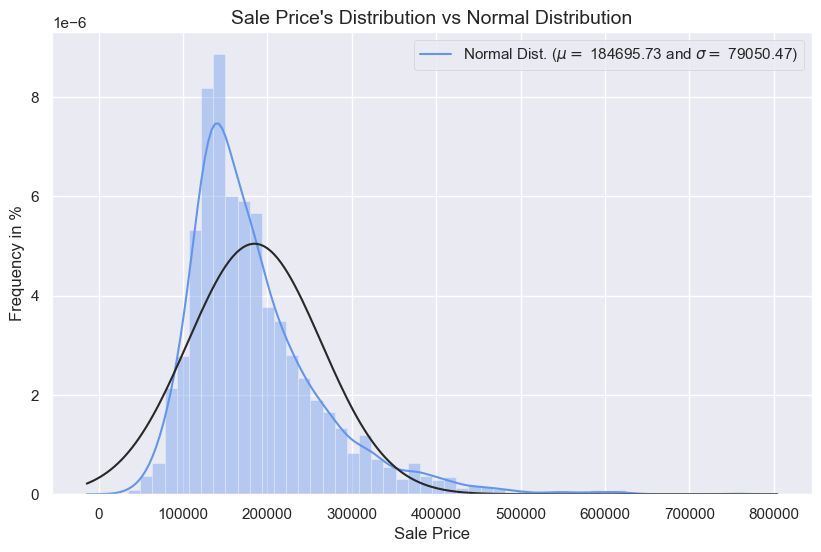

In [10]:
numeric_distr_plot(df, 'Sale_Price')

As we can see the sample distribution highlights quite heavy left tail. As the distribution is similar to a log-normal distribution, let's try and apply this transformation. 

As always, we keep adding them rather then applying the change to the original data. This will make the dataset bulky, but easier to study.

However, this only matter if it improves the relationship with other variables!

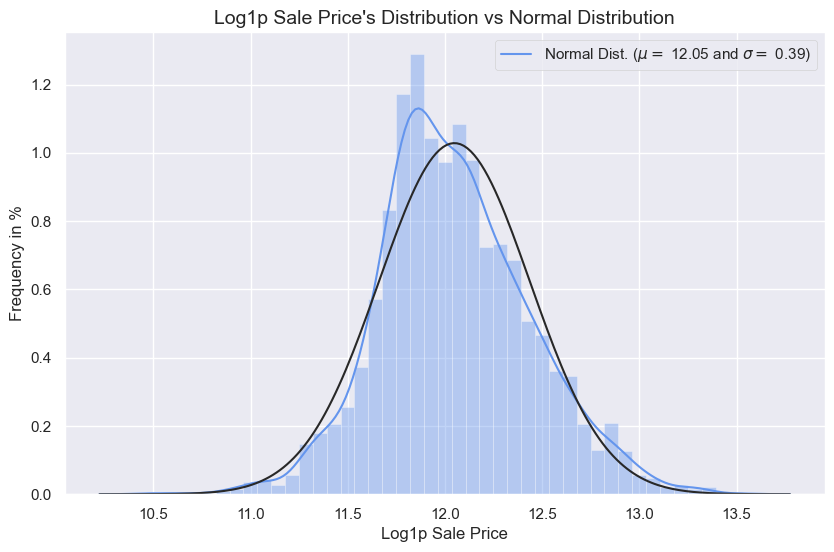

In [11]:
# New feature
df['Log1p_Sale_Price'] = np.log1p(df['Sale_Price'])
df_orig['Log1p_Sale_Price'] = np.log1p(df_orig['Sale_Price'])

numeric_distr_plot(df, 'Log1p_Sale_Price')

The transformation of the target brought the distribution to behave like a gaussian distribution! It is exactly as we predicted. 

Alternatively, there has been evidence of better results with a box-cox transformation, but it is easier to invert the change with the numpy library.

Now, let us focus on the outliers.

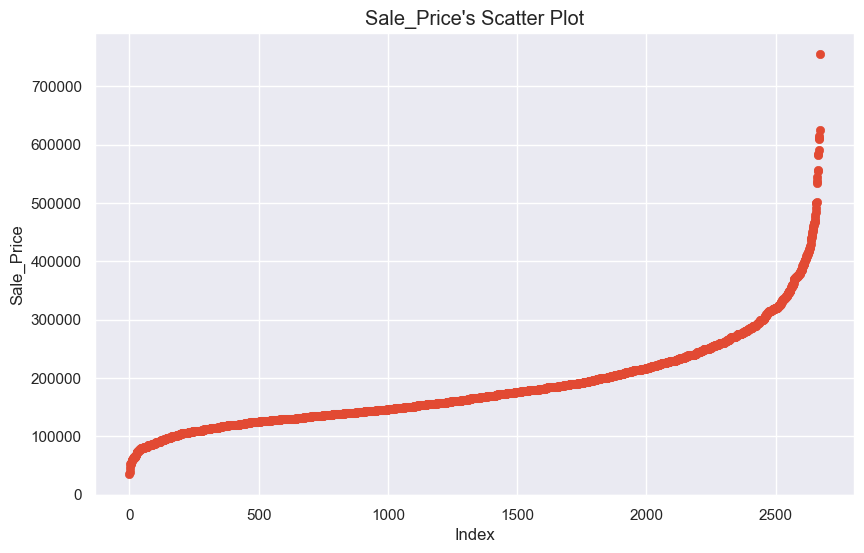

In [12]:
scatterplot_distr(df, 'Sale_Price')

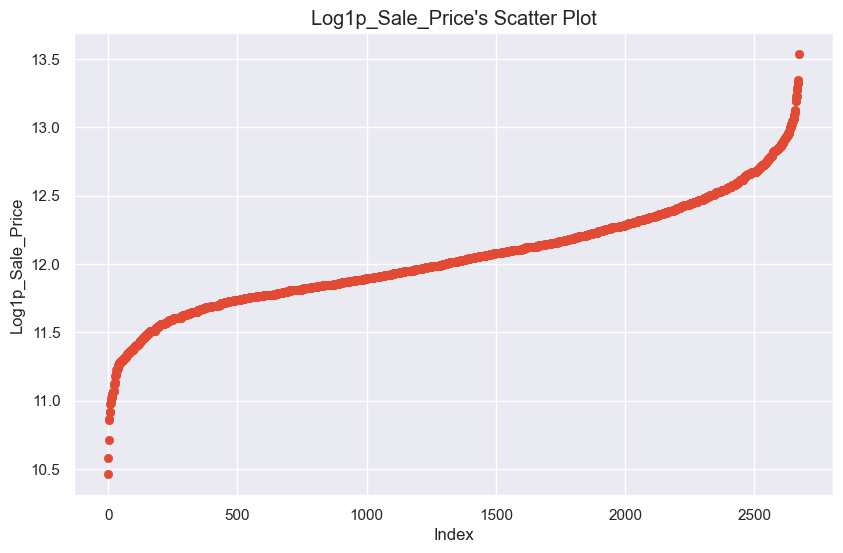

In [13]:
scatterplot_distr(df, 'Log1p_Sale_Price')

There is a great improvement in the distribution, even though we only switched where we have problematic points (on the left side with the log).

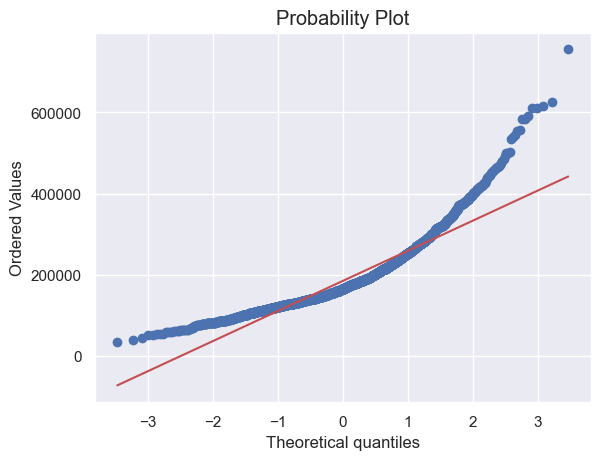

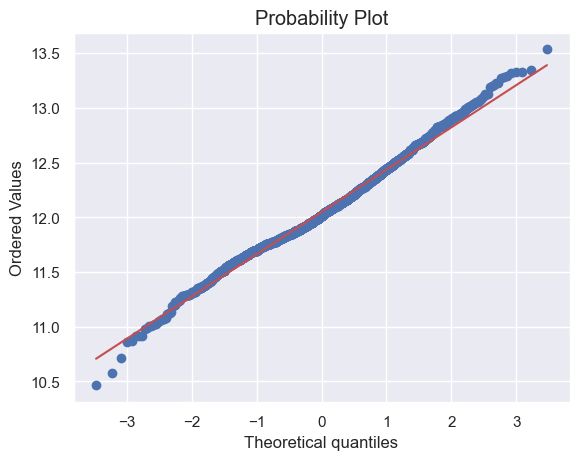

In [14]:
probability_plot(df, 'Sale_Price')
probability_plot(df, 'Log1p_Sale_Price')

As we can tell, the heavy tails might be very hard to take into account, even though the log transformation does not look bad at all.

This indicates we might need to remove some problematic instances that bring the price too low or too high. 

Although this requires a bivariate analysis as we would probably remove some hidden trend.

## Lot Area

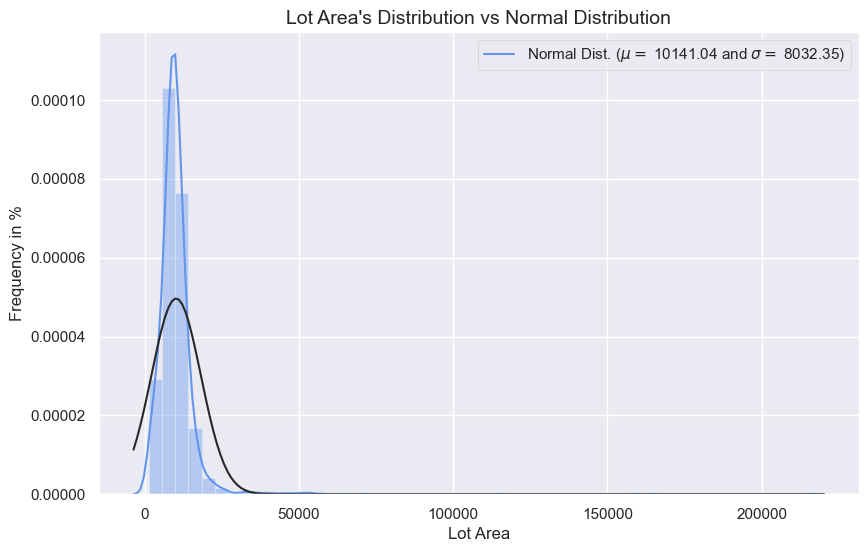

In [15]:
numeric_distr_plot(df, 'Lot_Area')

The distribution looks very bad, some instances with a huge lot area are affecting the distribution. In fact, most of the houses are visibly under $25000$ SF of Lot Area

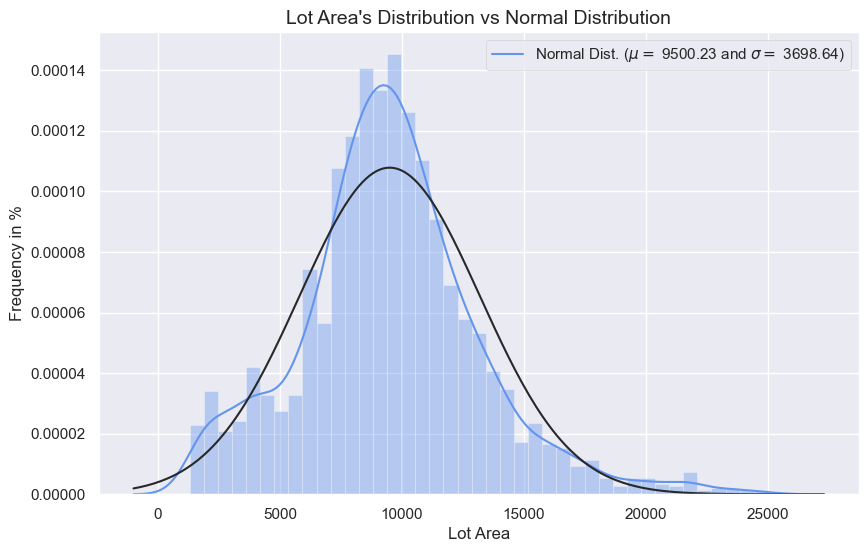

In [16]:
numeric_distr_plot(df.drop(df[df['Lot_Area']>25000].index.tolist()), 'Lot_Area')

There are very few observations with such values, and their rarity would make them safe to delete. As we said before, this will be later done with bivariate analysis, where we can see if some those instances are still tollerable.

Also we notice a very strange distribution for the houses with less than $5000$ SF, which it might mean they are probably part of apartment blocks.

Let us look at those instances:

In [17]:
df[df['Lot_Area']>25000][['Neighborhood', 'Lot_Area']].groupby('Neighborhood').describe()

Lot_Area                                                          \
                count          mean           std      min       25%      50%   
Neighborhood                                                                    
Clear_Creek       9.0  66393.666667  43442.921431  25095.0  39104.00  53107.0   
Crawford          3.0  28075.333333   3988.217187  25485.0  25779.00  26073.0   
Edwards           4.0  47569.500000  11416.514836  39290.0  39893.00  43550.5   
Gilbert           3.0  35823.333333   5288.537920  31220.0  32935.00  34650.0   
Mitchell          5.0  32274.800000   7338.478092  25286.0  26142.00  32463.0   
North_Ames        2.0  29710.000000   2913.279938  27650.0  28680.00  29710.0   
Northridge        3.0  37436.000000   8440.732018  29959.0  32859.50  35760.0   
Old_Town          1.0  33120.000000           NaN  33120.0  33120.00  33120.0   
Sawyer            1.0  25339.000000           NaN  25339.0  25339.00  25339.0   
Sawyer_West       1.0  26400.000000           NaN  26400.0  26400.00  26400.0   
Stone_Brook       2.0  52739.000000   1081.873375  51974.0  52356.50  52739.0   
Timberland        6.0  91419.666667  78739.645264  26178.0  38875.25  53651.0   
Veenker           1.0  50271.000000           NaN  50271.0  50271.00  50271.0   

                                  
                   75%       max  
Neighborhood                      
Clear_Creek    70761.0  159000.0  
Crawford       29370.5   32668.0  
Edwards        51227.0   63887.0  
Gilbert        38125.0   41600.0  
Mitchell       33983.0   43500.0  
North_Ames     30740.0   31770.0  
Northridge     41174.5   46589.0  
Old_Town       33120.0   33120.0  
Sawyer         25339.0   25339.0  
Sawyer_West    26400.0   26400.0  
Stone_Brook    53121.5   53504.0  
Timberland    137795.0  215245.0  
Veenker        50271.0   50271.0

In [18]:
df[['Neighborhood', 'Lot_Area']].groupby('Neighborhood').describe()

Lot_Area                              \
                                           count          mean           std   
Neighborhood                                                                   
Bloomington_Heights                         28.0   3399.357143    369.939256   
Blueste                                     10.0   2346.500000   1092.803047   
Briardale                                   25.0   1845.240000    253.783747   
Brookside                                   98.0   7010.030612   2362.567808   
Clear_Creek                                 39.0  26400.717949  30194.279214   
College_Creek                              258.0  10002.197674   2536.877187   
Crawford                                    96.0  11646.322917   5568.250139   
Edwards                                    173.0  10407.630058   6976.630918   
Gilbert                                    157.0  11130.668790   4813.262139   
Green_Hills                                  2.0   9001.000000   1077.630735   
Greens                                       8.0   3884.000000    231.371069   
Iowa_DOT_and_Rail_Road                      57.0   7810.087719   2032.073679   
Landmark                                     1.0   3612.000000           NaN   
Meadow_Village                              34.0   2149.235294    846.687165   
Mitchell                                   103.0  11646.631068   6232.007002   
North_Ames                                 396.0   9919.828283   2722.727694   
Northpark_Villa                             22.0   2697.090909    887.445875   
Northridge                                  67.0  12971.074627   6025.837594   
Northridge_Heights                         162.0  11091.802469   3665.933572   
Northwest_Ames                             116.0  11707.474138   2575.709400   
Old_Town                                   208.0   8310.980769   3574.842827   
Sawyer                                     137.0  10324.459854   3187.654679   
Sawyer_West                                119.0  10134.462185   3081.642113   
Somerset                                   175.0   7698.274286   3549.783227   
South_and_West_of_Iowa_State_University     41.0   7674.000000   2371.301657   
Stone_Brook                                 50.0  11494.780000   9611.967361   
Timberland                                  68.0  18582.132353  31493.806826   
Veenker                                     22.0  15336.409091   8474.297795   

                                                                              \
                                            min       25%      50%       75%   
Neighborhood                                                                   
Bloomington_Heights                      2938.0   3158.25   3189.0   3710.00   
Blueste                                  1300.0   1642.25   1830.5   3417.75   
Briardale                                1680.0   1680.00   1680.0   1920.00   
Brookside                                3500.0   6000.00   6210.0   7249.75   
Clear_Creek                              1700.0  11852.50  16698.0  23842.50   
College_Creek                            4426.0   8731.75   9651.0  11249.75   
Crawford                                 3811.0   7251.75  11355.0  14974.50   
Edwards                                  2522.0   7800.00   9340.0  11060.00   
Gilbert                                  7250.0   8244.00   9636.0  12104.00   
Green_Hills                              8239.0   8620.00   9001.0   9382.00   
Greens                                   3640.0   3776.50   3857.0   3877.00   
Iowa_DOT_and_Rail_Road                   3636.0   6780.00   7392.0   9000.00   
Landmark                                 3612.0   3612.00   3612.0   3612.00   
Meadow_Village                           1470.0   1526.00   1895.0   2542.50   
Mitchell                                 4500.0   8393.50  10114.0  12451.50   
North_Ames                               4058.0   8191.75   9532.5  10902.75   
Northpark_Villa                        

We can see that they are probably the extreme points of their respective neighborhoods, so we might look into this later when checking out the neighborhoods!

In [19]:
df[df['Lot_Area']<5000][['Bldg_Type']].describe()

Bldg_Type
count        282
unique         4
top       TwnhsE
freq         149

In [20]:
df[df['Lot_Area']<5000][['Neighborhood']].describe()

Neighborhood
count           282
unique           22
top        Somerset
freq             56

In [21]:
df[df['Lot_Area']<5000][['Year_Built', 'Year_Remod_Add', 'Year_Sold','Sale_Price']].describe()

Year_Built  Year_Remod_Add    Year_Sold     Sale_Price
count   282.000000      282.000000   282.000000     282.000000
mean   1982.460993     1989.968085  2007.804965  151093.893617
std      25.820078       16.890343     1.360700   51026.950349
min    1910.000000     1950.000000  2006.000000   52000.000000
25%    1972.000000     1976.000000  2007.000000  114628.000000
50%    1987.500000     1999.000000  2008.000000  147000.000000
75%    2004.000000     2004.000000  2009.000000  177000.000000
max    2009.000000     2009.000000  2010.000000  345000.000000

As predicted, 
* They are mostly Twin Houses
* Their prices are mostly under $200.000$ 
* Their median for the construction year is $1987$
* Their median for the remodeling year is under $2000$
* Their year of sale is mostly around the years of the global economic crisis

We can confidently say they are mostly old houses which were remodeled around $9$ to $10$ before the crisis, which made them lose value over time and were sold during a time which forced the price to be even lower than the expected one. 

This is a very hard condition to represent as this combines time, land and the location (mostly `Somerset`) of these houses.

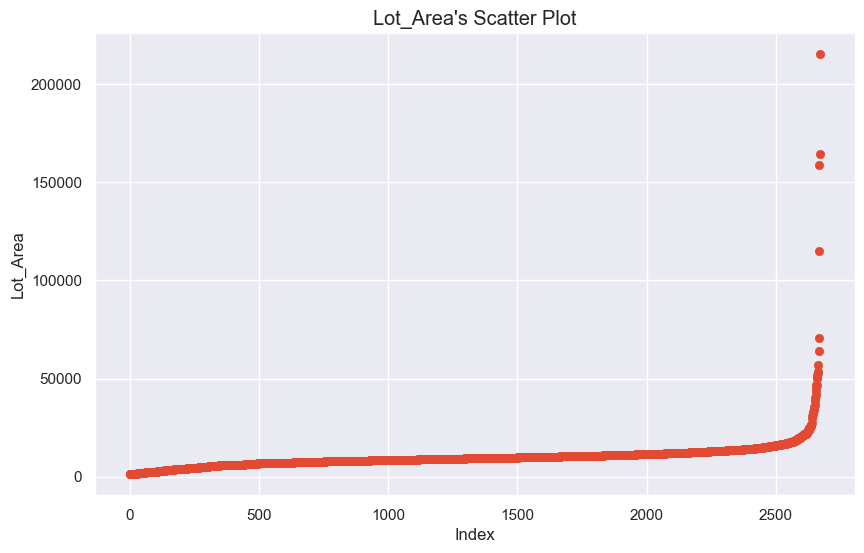

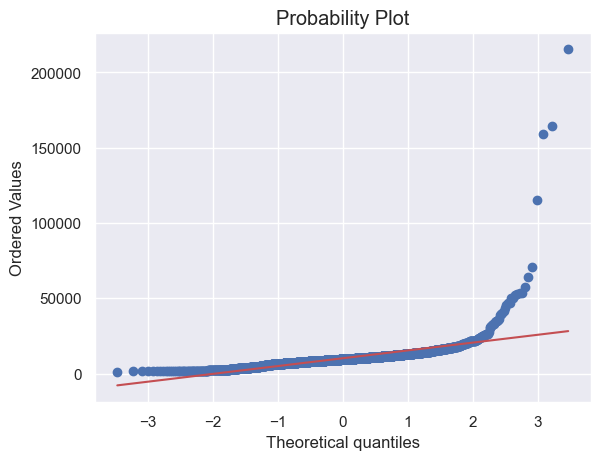

In [22]:
scatterplot_distr(df, 'Lot_Area')
probability_plot(df, 'Lot_Area')

Even though the latter houses do not really affect the distribution, the former do confound the QQplot

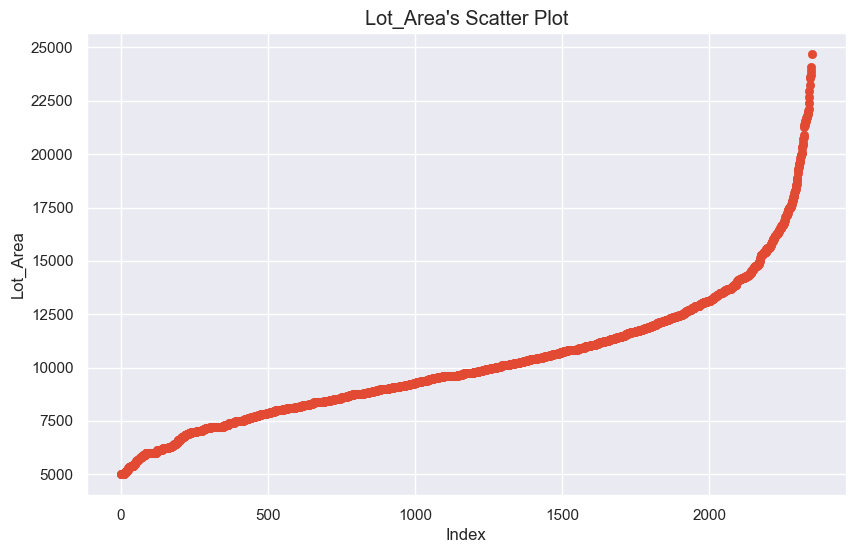

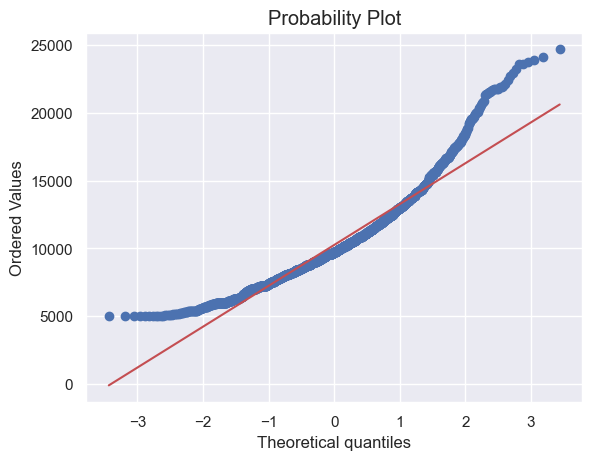

In [23]:
scatterplot_distr(df[((df['Lot_Area']<25000)&(df['Lot_Area']>=5000))], 'Lot_Area')
probability_plot(df[((df['Lot_Area']<25000)&(df['Lot_Area']>=5000))], 'Lot_Area')

As you can see, even a removal of these problematic instances does not improve much our case

## Total SF

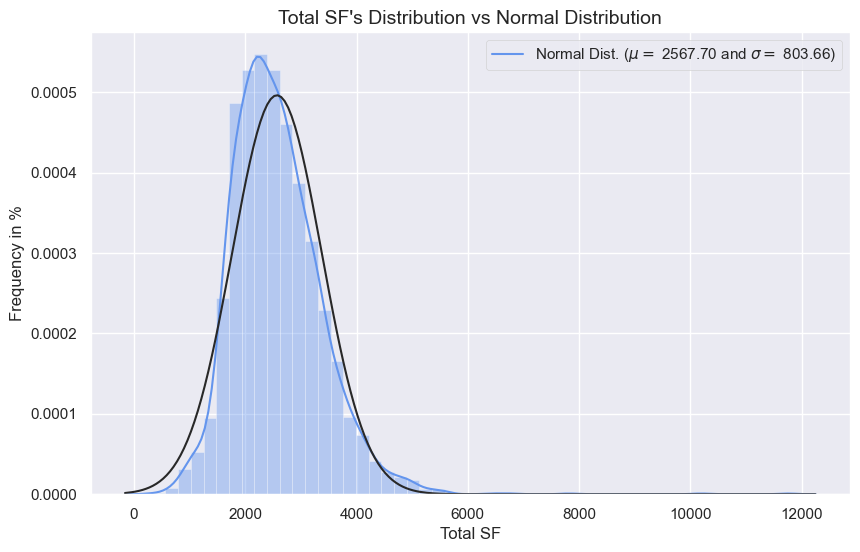

In [24]:
numeric_distr_plot(df, 'Total_SF')

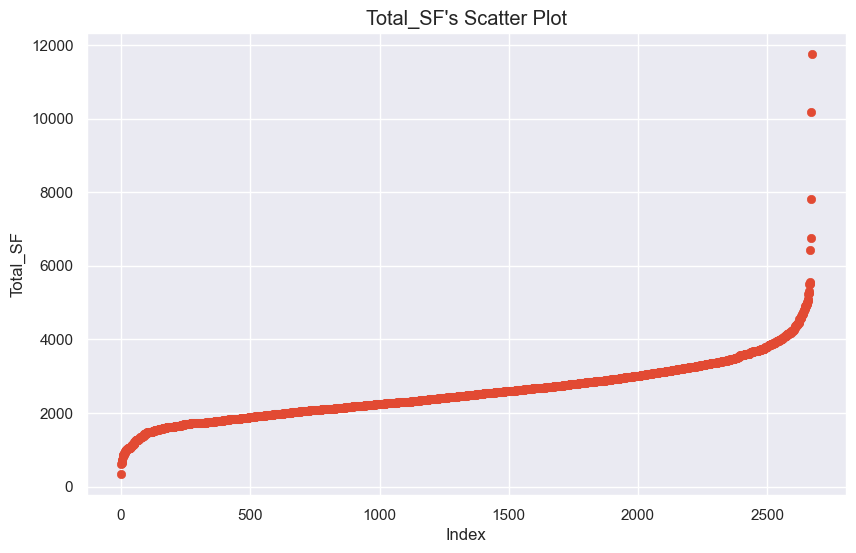

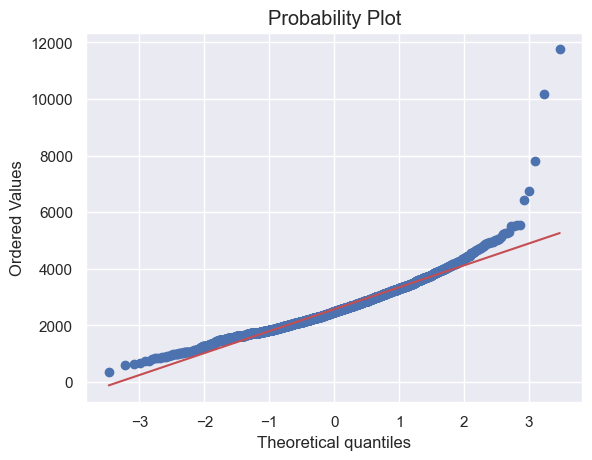

In [25]:
scatterplot_distr(df, 'Total_SF')
probability_plot(df, 'Total_SF')

This indicates that it might be a good idea to remove those instances at the tails of the distribution

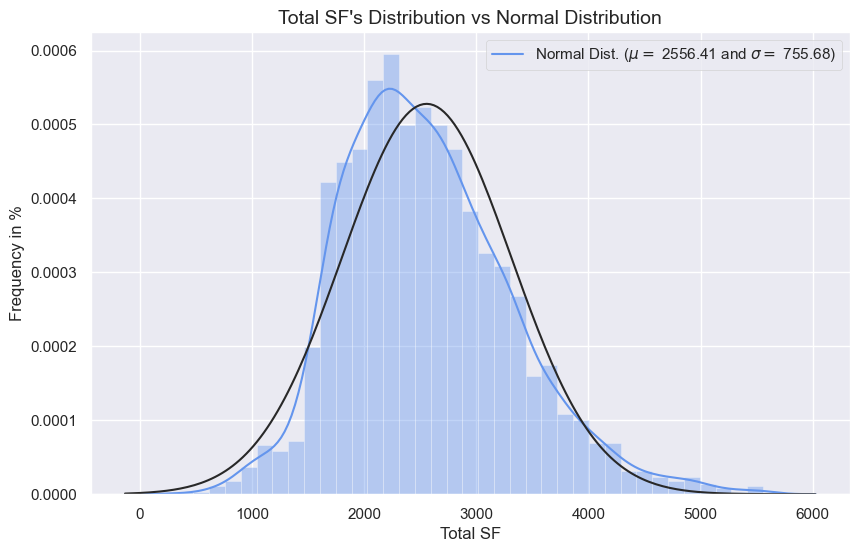

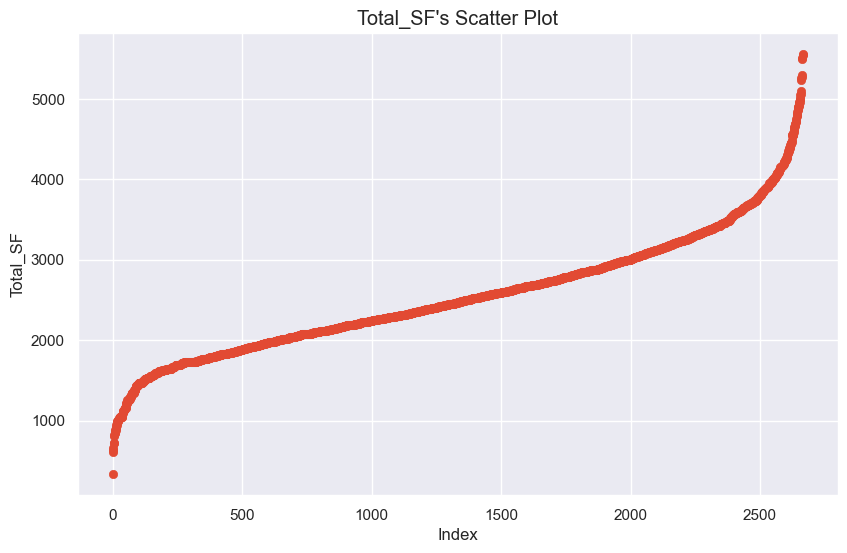

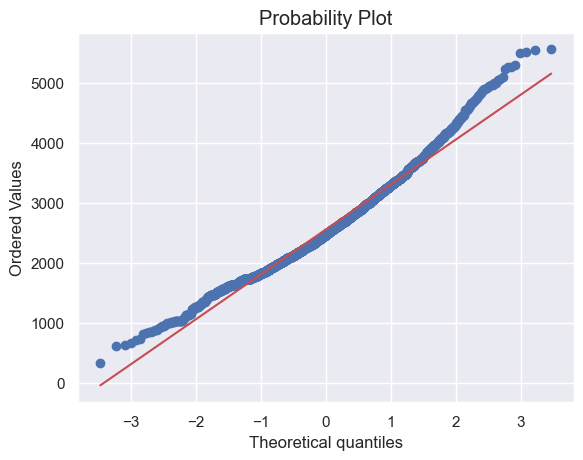

In [26]:
numeric_distr_plot(df[df['Total_SF']<6000], 'Total_SF')
scatterplot_distr(df[df['Total_SF']<6000], 'Total_SF')
probability_plot(df[df['Total_SF']<6000], 'Total_SF')

We can see the QQplot does really change. We shall remove those instances then.

Obviously, as it is a combination of the living area above and below the ground, we can avoid using transformations for those features. In fact, we should look out for the correlation between them

In [27]:
drop_rows_cond(df, condition=(df['Total_SF']>6000))

## Above Ground Living Area

As the above ground living area is the sum of `First_Flr_SF`, `'Second_Flr_SF`,`Low_Qual_Fin_SF` I will avoid to remove outliers from these three attributes as it might lead to problematic results

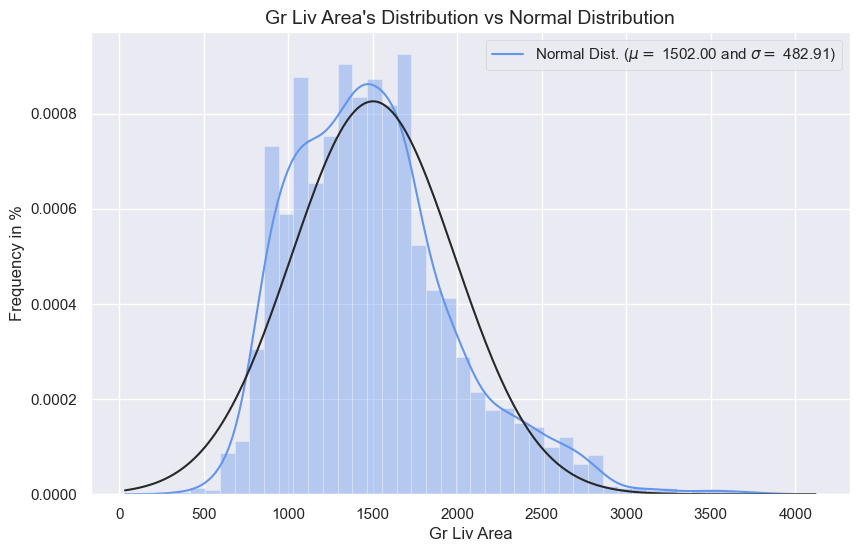

In [28]:
numeric_distr_plot(df, 'Gr_Liv_Area')

It seems like we could use our log-transformation again, but since we have the `Total_SF` feature, we can omit it!

### First Floor SquareFeet

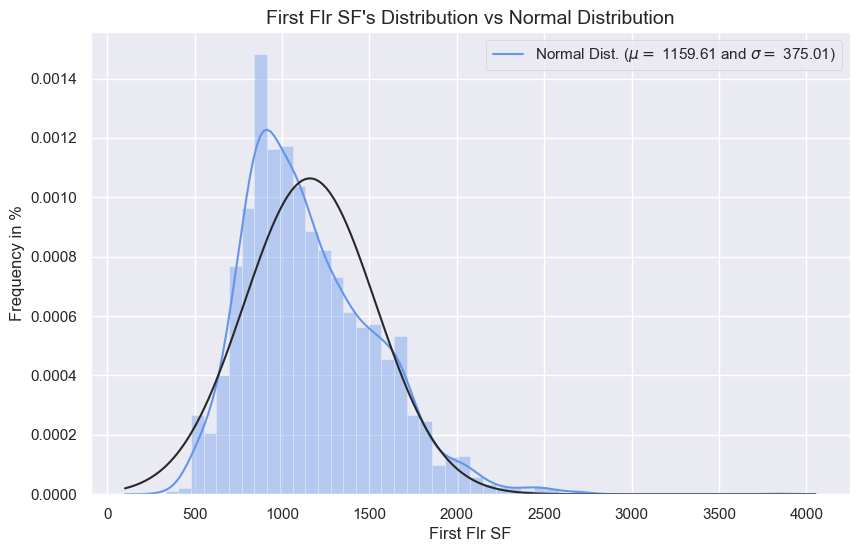

In [29]:
numeric_distr_plot(df, 'First_Flr_SF')

This feature is very similar to the previous one obviously

### Second Floor Square Feet

Some features like the following ones tend to have many instances which take value `0.0` as they either lack that information or they do not have that feature at all. This is why we will focus on the distribution and ignore those instances.

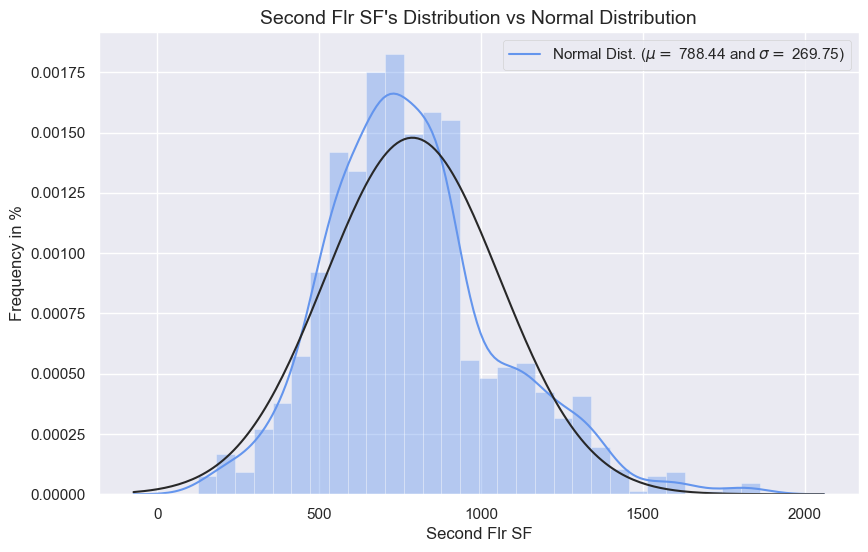

In [30]:
numeric_distr_plot(df.drop(df[df['Second_Flr_SF']==0.0].index.tolist()), 'Second_Flr_SF')

The distribution appears to have a very steep change when approaching the `1000` square feet. 

This obviously depends by the construction details of the houses (something we can only measure to some extent). We could say it looks good enough, but the scatterplot and the probability plot highlight some issues in the right tail.

From my point of view it is best to only keep `Total_SF`

## Total Basement Square Feet

Again there are many entries without basements and we are going to focus on those who do not lack that information

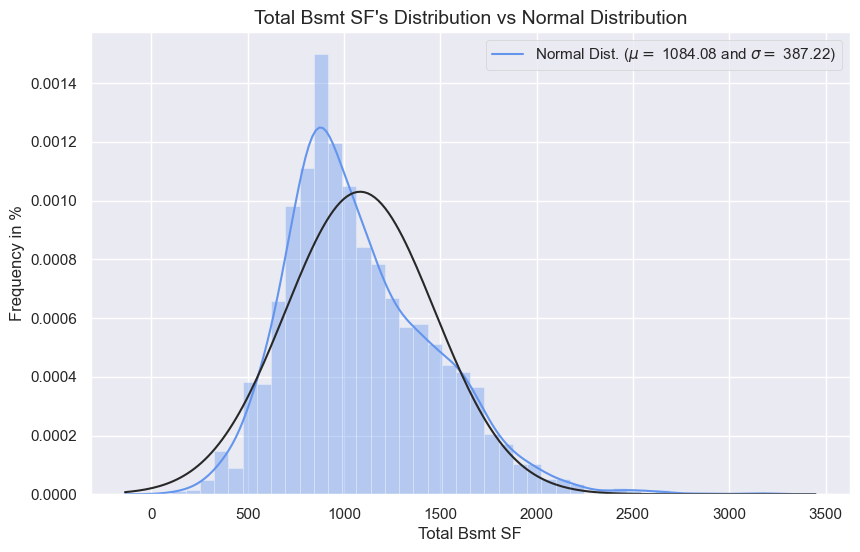

In [31]:
numeric_distr_plot(df.drop(df[df['Total_Bsmt_SF']==0.0].index.tolist()), 'Total_Bsmt_SF')

Curiously enough, this distribution is really similar to the one seen with `First_Flr_SF`. It is safe to assume that their area is very similar for most instances.

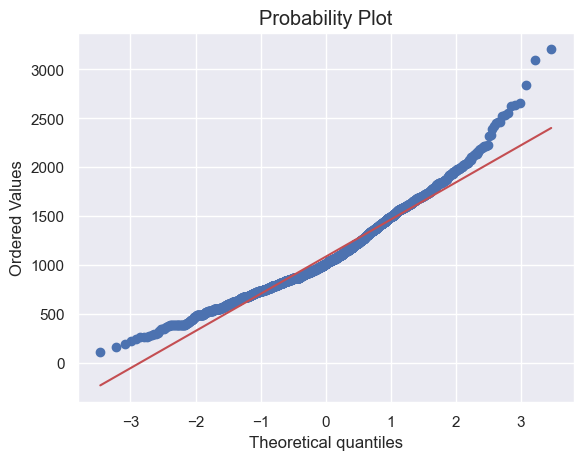

In [32]:
probability_plot(df.drop(df[df['Total_Bsmt_SF']==0.0].index.tolist()), 'Total_Bsmt_SF')

There are a good amount of houses which have unfinished basements or no basements at all, and that is probably what is causing these issues. 

We should look out for it later, through a complete bivariate analysis

## Unfinished Basement 

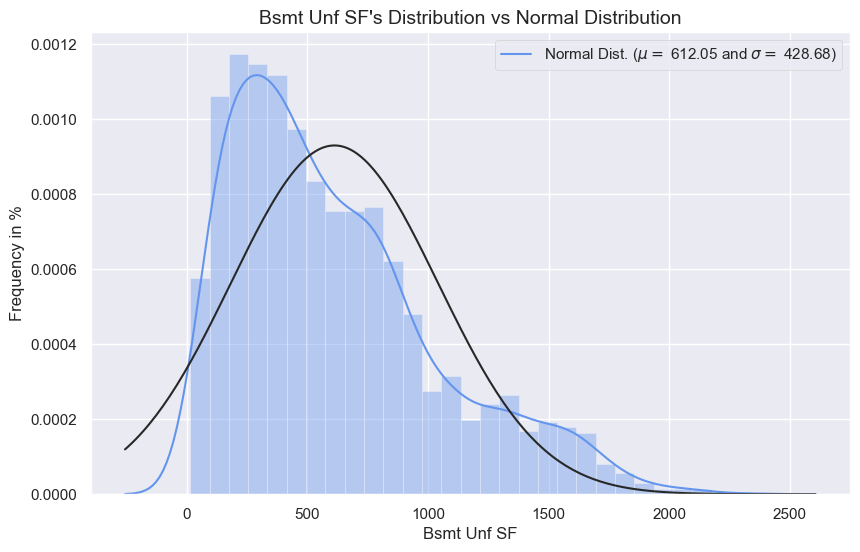

In [33]:
numeric_distr_plot(df[df['Bsmt_Unf_SF']>0], 'Bsmt_Unf_SF')

The triangular distribution looks ugly, we will save this for later

## Garage Area

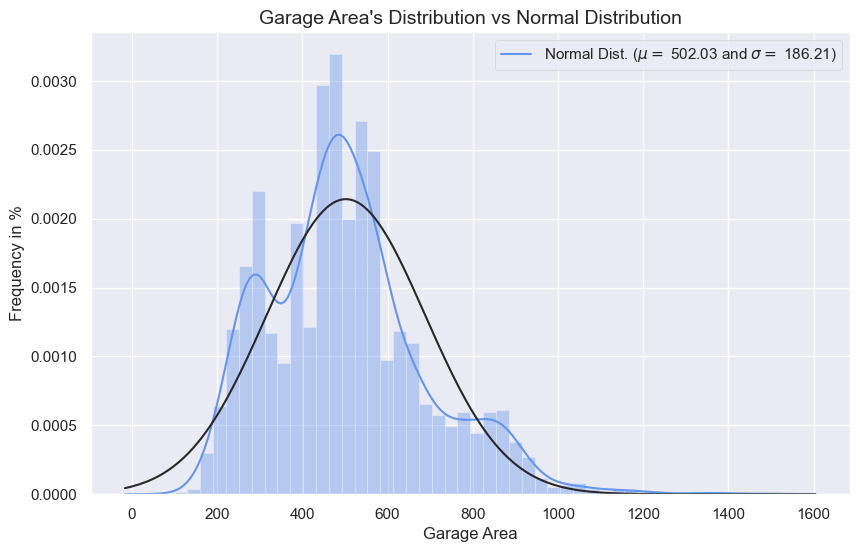

In [34]:
numeric_distr_plot(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')

This is an interesting pattern but no transformation can improve this shape.

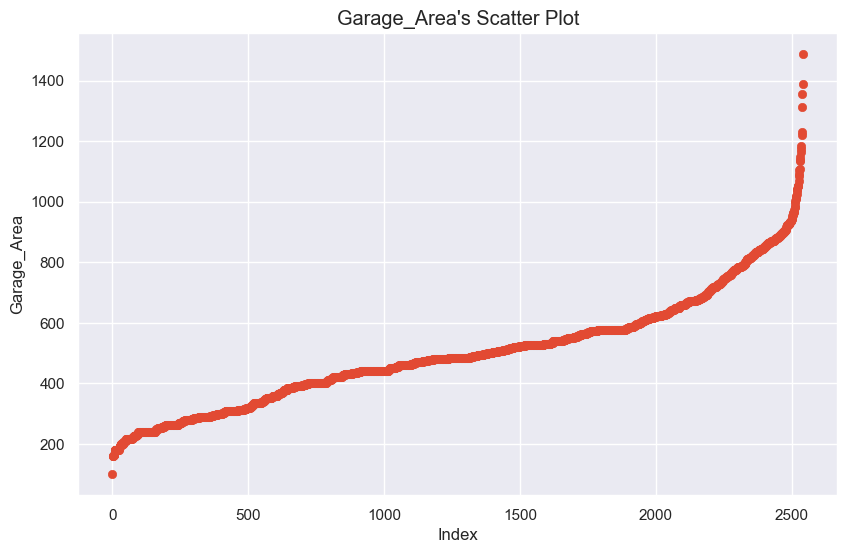

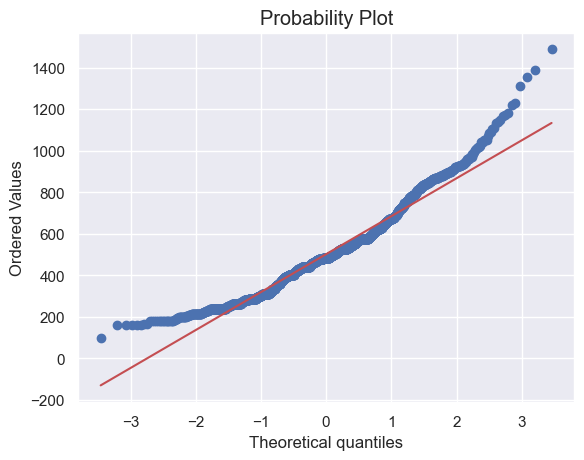

In [35]:
scatterplot_distr(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')
probability_plot(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')

Althouh we have instances of very heavy tails that need to be studied more, it is safe to say that garages over $1200$ SF can be considered outliers

In [36]:
drop_rows_cond(df, condition = (df['Garage_Area']>1200))

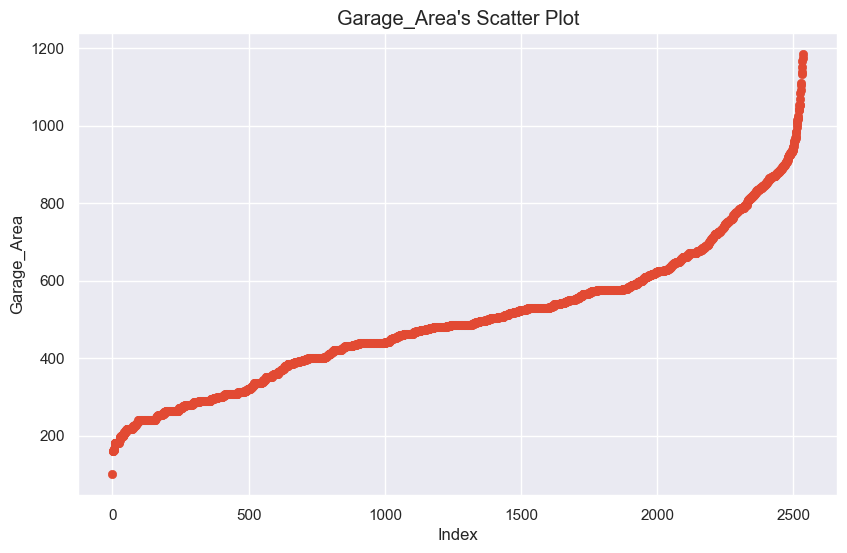

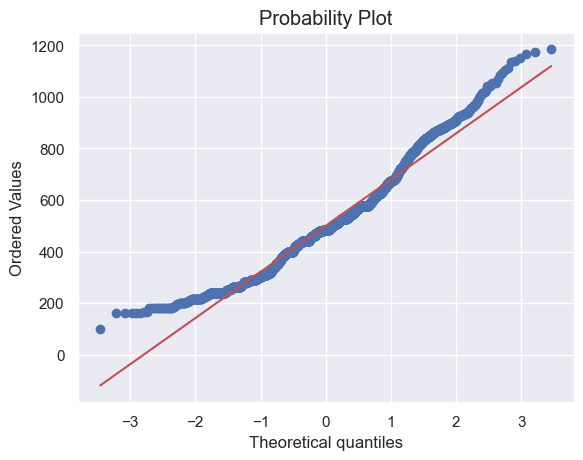

In [37]:
scatterplot_distr(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')
probability_plot(df.drop(df[df['Garage_Area']==0.0].index.tolist()), 'Garage_Area')

It still looks problematic, we need to check it out later!

---

# Bivariate and Multivariate Analysis

## Correlation

Before choosing what features to inspect in depth, we look at the correlation and we discard the outliers.
Furthermore if we find that a transformation or a new feature could represent a better fit, we will add it and try to see how that would be of use.

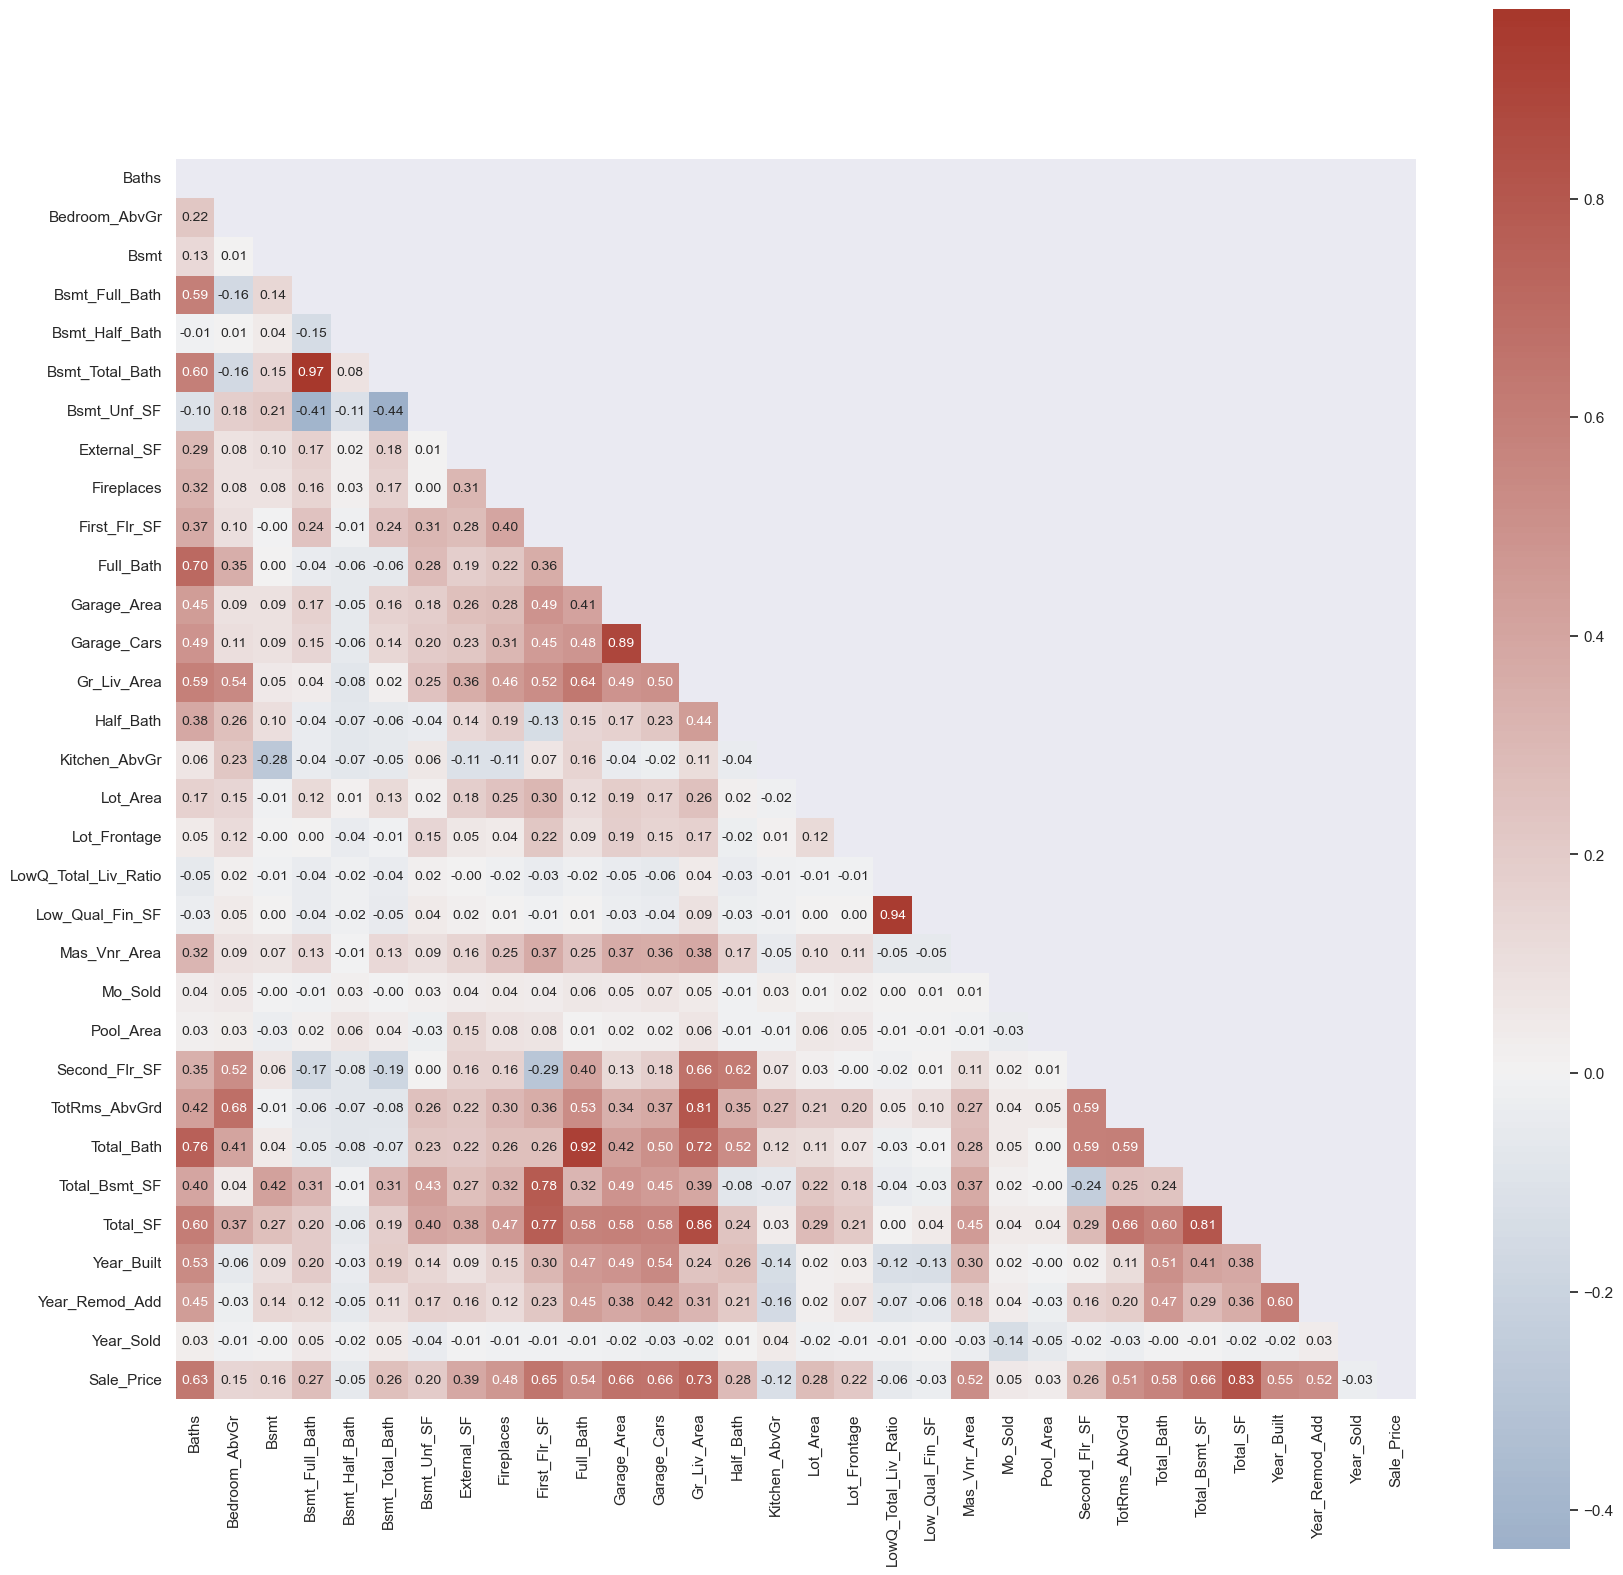

In [38]:
corr = display_corr_matrix(sort_alphabetically(df.drop(columns=['Log1p_Sale_Price', 'Longitude', 'Latitude']), 'Sale_Price'), label='Sale_Price')

In [39]:
top_corr_dict = top_correlated_features(corr, 'Sale_Price', 0.40)
top_corr_dict

{'Total_SF': 0.8348387069823819,
 'Gr_Liv_Area': 0.7305207972796743,
 'Garage_Area': 0.6636157471248718,
 'Total_Bsmt_SF': 0.6600463613733937,
 'Garage_Cars': 0.6579550740406254,
 'First_Flr_SF': 0.6473699606810729,
 'Baths': 0.6349050176727016,
 'Total_Bath': 0.5758476682802297,
 'Year_Built': 0.5519760518790278,
 'Full_Bath': 0.5395573427608769,
 'Year_Remod_Add': 0.5248797470489459,
 'Mas_Vnr_Area': 0.5175652367457528,
 'TotRms_AbvGrd': 0.5137748885893801,
 'Fireplaces': 0.4752438802120372}

Let us see what are the top correlated features for both `Sale_Price`

We must pay attention to the ones who show collinearity as they might disturb our prediction. We should investigate the relationships of high correlation between other variables.

In [40]:
display_correlation(top_corr_dict, exclude=['Sale_Price', 'Log1p_Sale_Price'])

Top correlated features with "Total_SF"
	Gr_Liv_Area : 0.8590321254260632
	Total_Bsmt_SF : 0.8090125981727098
	First_Flr_SF : 0.768334299637679
	TotRms_AbvGrd : 0.6564511793695562
	Baths : 0.6014710932486242


Top correlated features with "Gr_Liv_Area"
	Total_SF : 0.8590321254260632
	TotRms_AbvGrd : 0.8117941272896413
	Total_Bath : 0.7212637080699835
	Second_Flr_SF : 0.6643546601549154
	Full_Bath : 0.6359953714195102


Top correlated features with "Garage_Area"
	Garage_Cars : 0.8902266936330027


Top correlated features with "Total_Bsmt_SF"
	Total_SF : 0.8090125981727098
	First_Flr_SF : 0.7835558130469835


Top correlated features with "Garage_Cars"
	Garage_Area : 0.8902266936330027


Top correlated features with "First_Flr_SF"
	Total_Bsmt_SF : 0.7835558130469835
	Total_SF : 0.768334299637679


Top correlated features with "Baths"
	Total_Bath : 0.7575161290537495
	Full_Bath : 0.7035970407489736
	Total_SF : 0.6014710932486242


Top correlated features with "Total_Bath"
	Full_Bath : 0.92

Now that we saw what features are highly correlated with Sale_Price, we will take a closer look at them and at their transformations:
* Above-ground-related features
* Garage-related features
* Basement-related features
* Age-related features
* External-related features

At the same time we want to confirm that the following ones also matter, since this is what we obtained from domain knowledge research:
* `Lot_Area`
* `Year_Sold` and `Mo_Sold` of Sale
* `Sale_Type` and `Sale_Condition`
* `Neighborhood`

Finally, we shall look at the categorical features too.

## Lot Area vs Sale Price

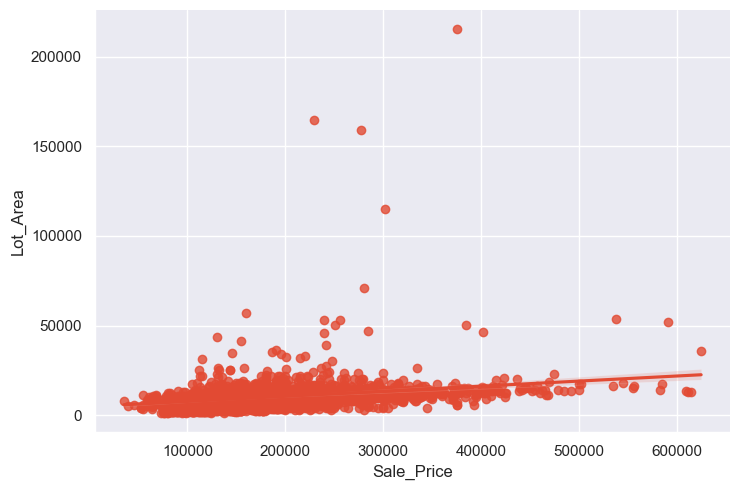

In [41]:
scatterplot_single(df,'Sale_Price', 'Lot_Area')

The linear relationship is amazing, but there are some outliers in the way. Now we can finally remove the instances with `Lot_Area` > $30000$

In [42]:
drop_rows_cond(dataset=df, condition=(df['Lot_Area']>30000), inplace = True)

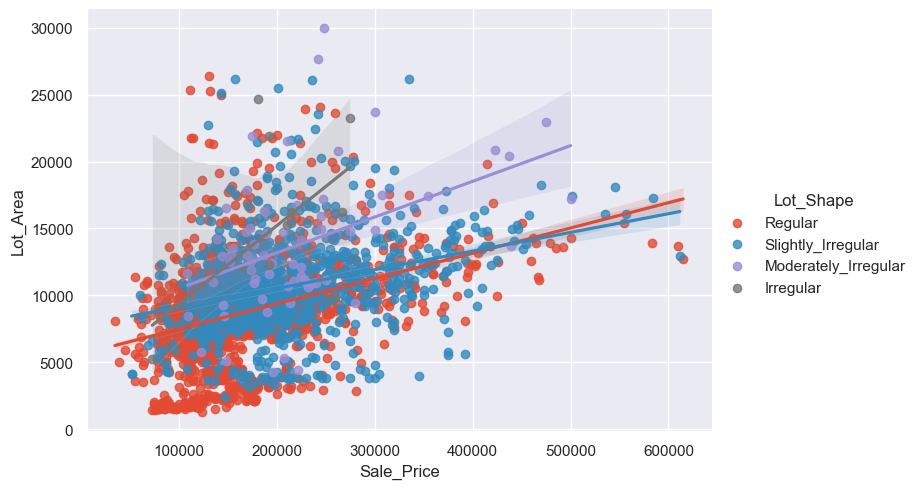

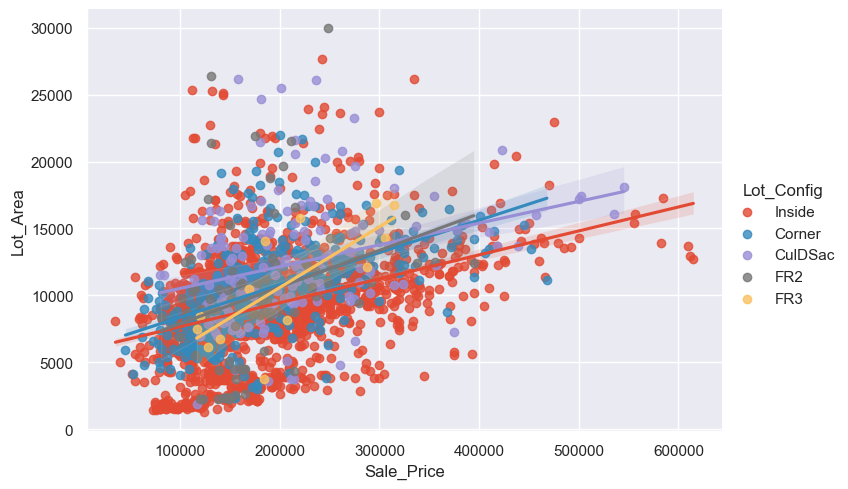

In [43]:
scatterplot_single(df,'Sale_Price', 'Lot_Area', hue='Lot_Shape')
scatterplot_single(df,'Sale_Price', 'Lot_Area', hue='Lot_Config')

It is evident that neither `Lot_Shape` or `Lot_Config` play a big role.

If we wonder why that is the case, is because most houses are old and were never renewed, and they usually belong to the same neighborhood!

In [44]:
df.drop(columns=['Lot_Config', 'Lot_Shape'], inplace=True)

If we analyze just the houses that are relatively new, we find a smalller variance!

## Seasonality related features vs Sale Price

From the description we know the houses were all sold between 2006 and 2010. This means the data might it includes hidden trends of the global state of the economy during the crisis in 2008.

From more research we can recognize the real estate market has seasons which affect the fluctuation of prices, along with the year of sale.

For this reason we can identify the following *seasons*:
1. December-March
2. April-July, which are supposed to be the best months for selling as they provided the highest prices
3. August-November

Here we display the distribution of sales throughout the years to confirm what we have discovered so far.

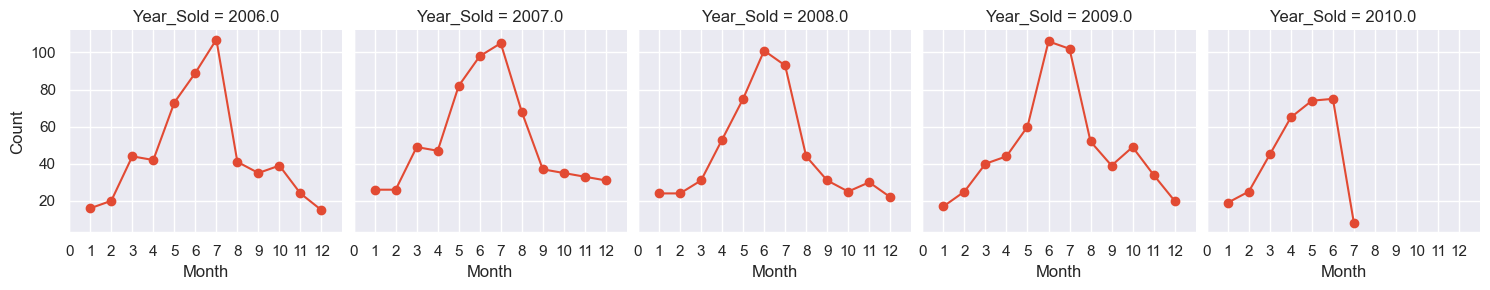

In [45]:
target_by_year_month(df, target='Sale_Price', highlight='count')

As we expected, the central months seem to be the most important ones for selling.

What about the price?

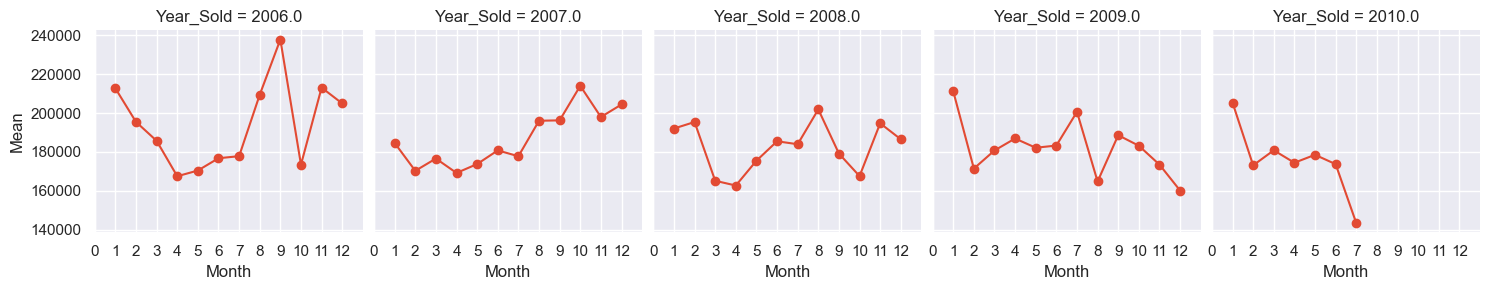

In [46]:
target_by_year_month(df, target='Sale_Price', highlight='mean')

We do see a big drop during 2008 and a negative trend from 2009 to 2010, as we expected.

## Sale related features vs Sale Price

### Sale Type vs Sale Price

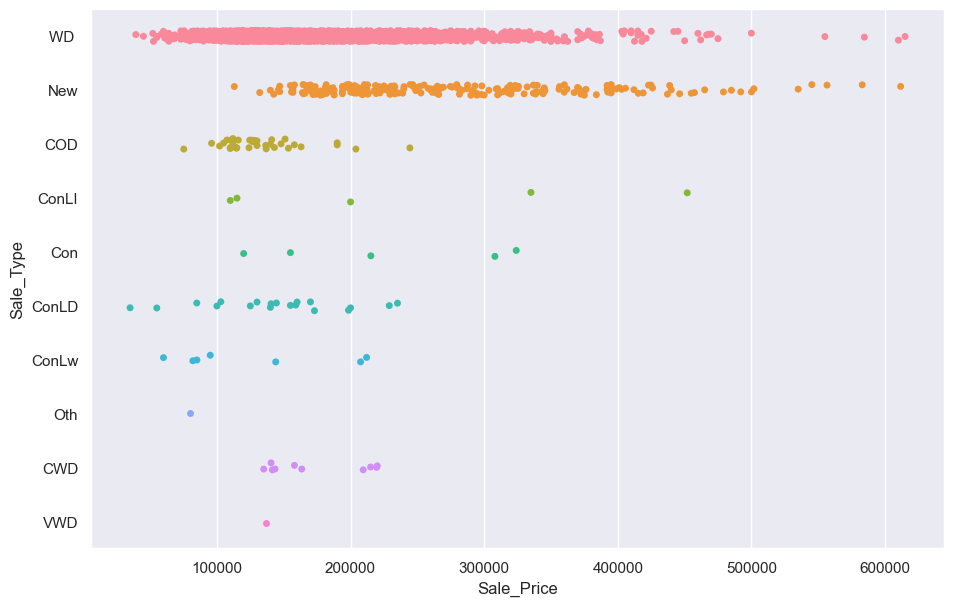

In [47]:
stripplot_single(dataset=df, categ_feat ='Sale_Type', target ='Sale_Price')

We do not know how to quantify the type of sale, as we lack information about interest rate and taxes. It is probably best to drop this kind of information, also because the distributions might be misleading

In [48]:
df.drop(columns=['Sale_Type'], inplace=True)

### Sale Condition vs Sale Price

For the sake of representing the housing market, we want to have a $1$ vs all representation of the type of sale, which focuses on normal transactions. 

But it might be a bad idea as the variance is way too high for some instances. In fact, we might use a OHE instead here!

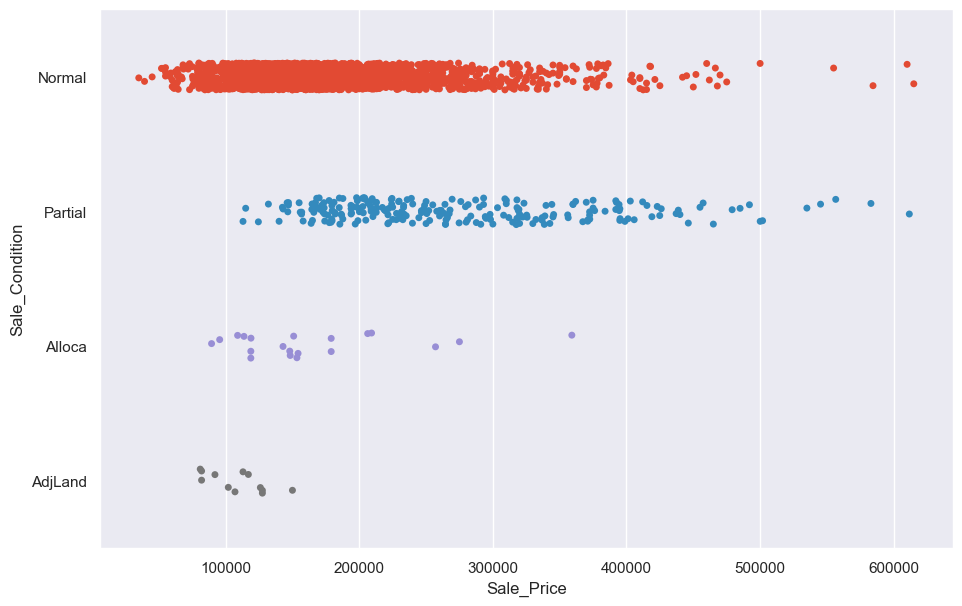

In [49]:
stripplot_single(dataset=df, categ_feat ='Sale_Condition', target ='Sale_Price')

In [50]:
sc_block1=['Normal']
sc_block2=['Partial'] 
sc_block3=['Alloca', 'AdjLand', 'Abnorml', 'Family']
sc_blocks = [sc_block1, sc_block2, sc_block3]

quick_categ_binning(dataset = df, target= 'Sale_Condition', name_like = 'sale_cond_', bins = sc_blocks)
quick_categ_binning(dataset = df_orig, target='Sale_Condition', name_like = 'sale_cond_', bins = sc_blocks)

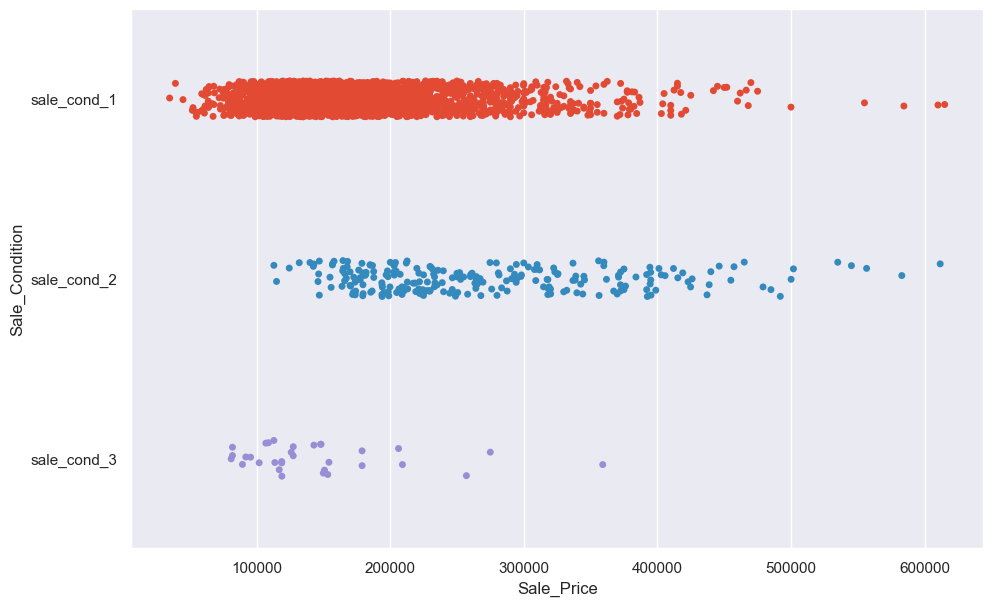

In [51]:
stripplot_single(dataset=df, categ_feat ='Sale_Condition', target ='Sale_Price')

As we can see, the variance might be too high to account for this. So we can swtich to a OHE encoding instead.

In [52]:
ohe_encoding(dataset=df, categorical_features=['Sale_Condition'])
ohe_encoding(dataset=df_orig, categorical_features=['Sale_Condition'])

Here's the result:

In [53]:
df[get_cols(df, 'sale_cond')]

sale_cond_1  sale_cond_2  sale_cond_3
0             1.0          0.0          0.0
1             1.0          0.0          0.0
2             1.0          0.0          0.0
3             1.0          0.0          0.0
4             1.0          0.0          0.0
...           ...          ...          ...
2629          1.0          0.0          0.0
2630          1.0          0.0          0.0
2631          1.0          0.0          0.0
2632          1.0          0.0          0.0
2633          1.0          0.0          0.0

[2634 rows x 3 columns]

We just need the first two columns!

In [54]:
df.drop(columns=['sale_cond_3'],inplace=True)

## Location/ House Type related features vs Sale Price

### Alley vs Sale Price

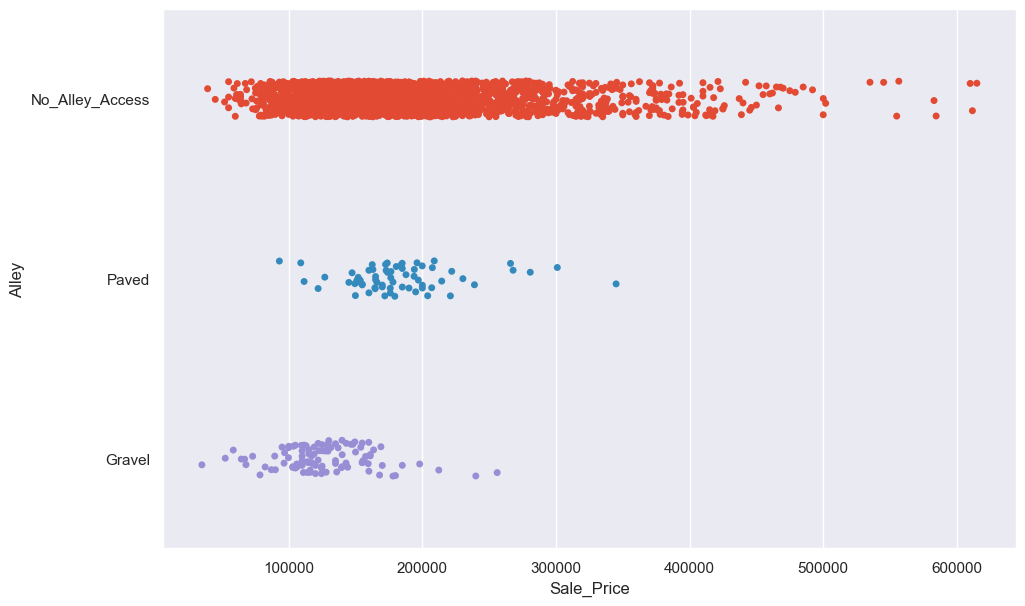

In [55]:
stripplot_single(dataset=df, categ_feat ='Alley', target ='Sale_Price')

In [56]:
alley1 = ['No_Alley_Access']
alley2 = ['Paved', 'Gravel']
alleys = [alley1, alley2]

quick_categ_binning(dataset = df, target= 'Alley', name_like = 'Alley_Access', bins = alleys)
quick_categ_binning(dataset = df_orig, target='Alley', name_like = 'Alley_Access', bins = alleys)

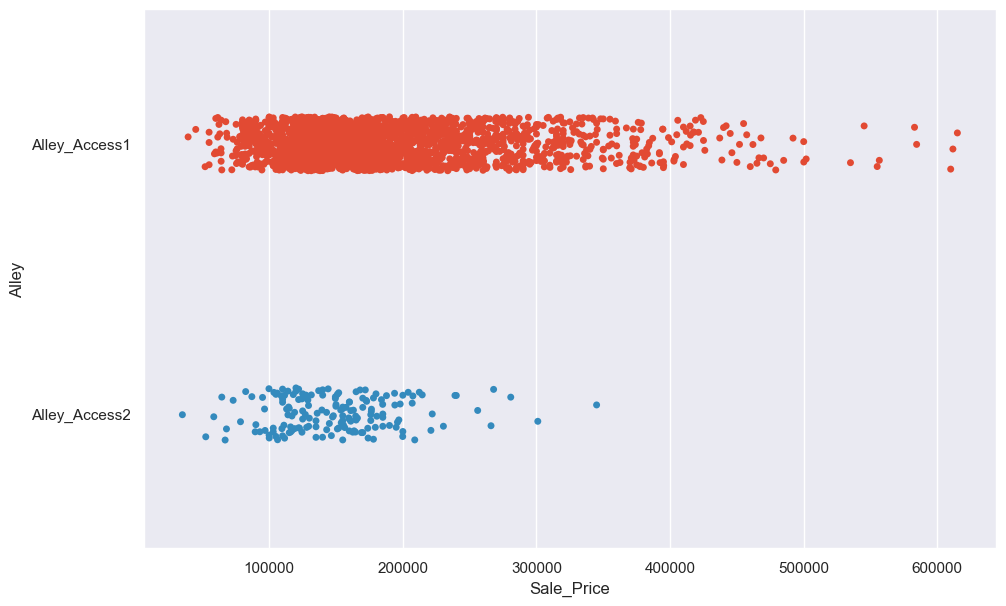

In [57]:
stripplot_single(dataset=df, categ_feat ='Alley', target ='Sale_Price')

Again an indicator might be useful, although the variance in `No_Alley_Access` seems very high. However, I prefer a $1$ vs all encoding.

In [58]:
dummy_encoding(df, target_feat='Alley', new_feat_name='Alley_Access', index_col_drop=0)
dummy_encoding(df_orig, target_feat='Alley', new_feat_name='Alley_Access', index_col_drop=0)

In [59]:
df[get_cols(df, 'Alley')]

Alley_Access
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
2629           0.0
2630           0.0
2631           0.0
2632           0.0
2633           0.0

[2634 rows x 1 columns]

### Paved Drive vs Sale Price

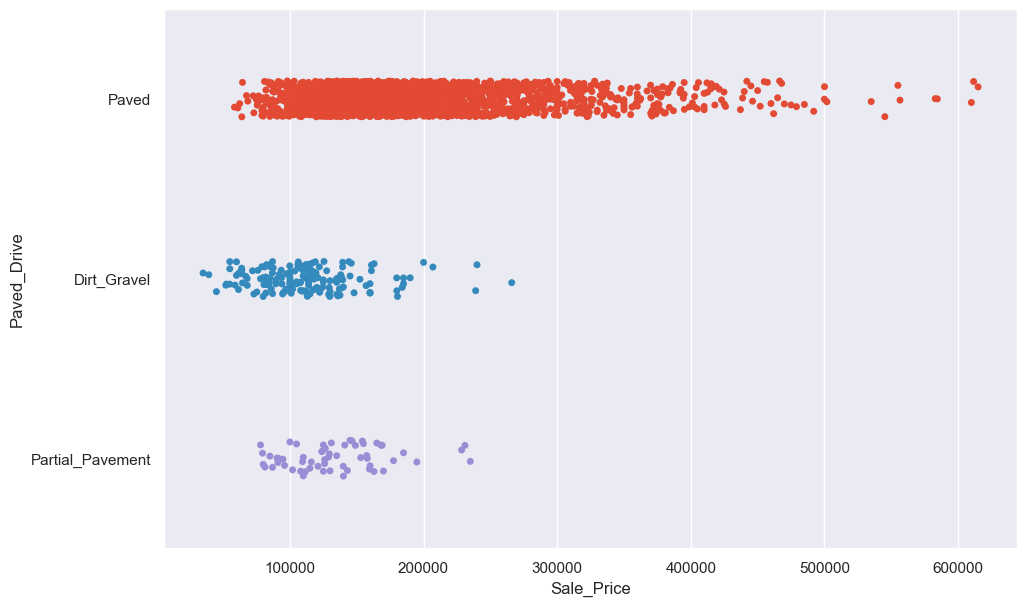

In [60]:
stripplot_single(dataset=df, categ_feat ='Paved_Drive', target ='Sale_Price')

The values in this feature suggest an order of completeness based on how paved the driveway is

In [61]:
pave_map = ordinal_mapping.copy()
pave_map = [pave_map.pop(20)]
ordinal_encoding(dataset=df, ord_mapping=pave_map)

In [62]:
df[get_cols(df, 'Paved')]

Paved_Drive
0             2.0
1             2.0
2             2.0
3             2.0
4             2.0
...           ...
2629          2.0
2630          2.0
2631          2.0
2632          2.0
2633          2.0

[2634 rows x 1 columns]

Where the 2 represents the value `Paved`

### Street vs Sale Price

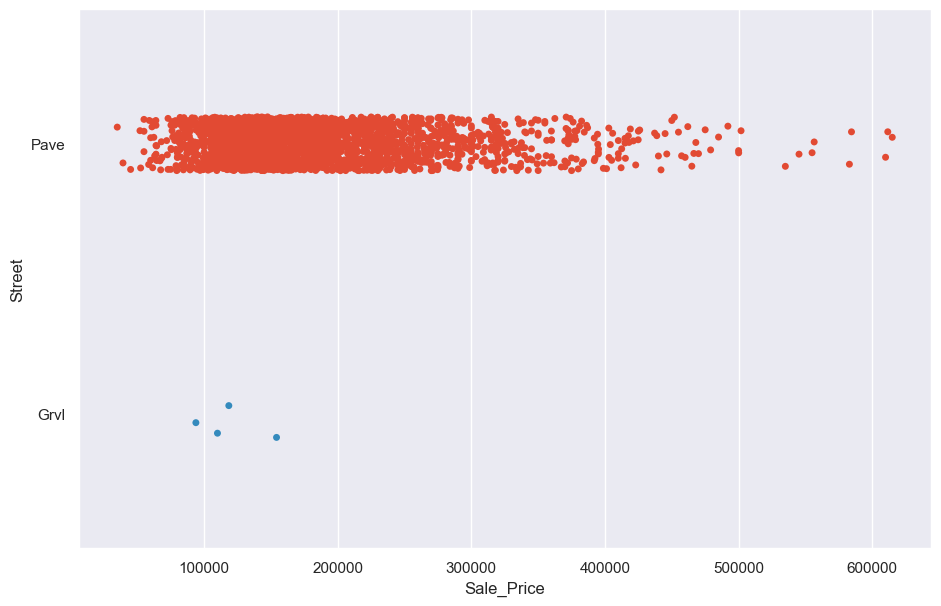

In [63]:
stripplot_single(dataset=df, categ_feat ='Street', target ='Sale_Price')

This has very few instances and could be seen as irrelevant.

In [64]:
df.drop(columns=['Street'], inplace=True)
df_orig.drop(columns=['Street'], inplace=True)

### Building Type vs Sale Price

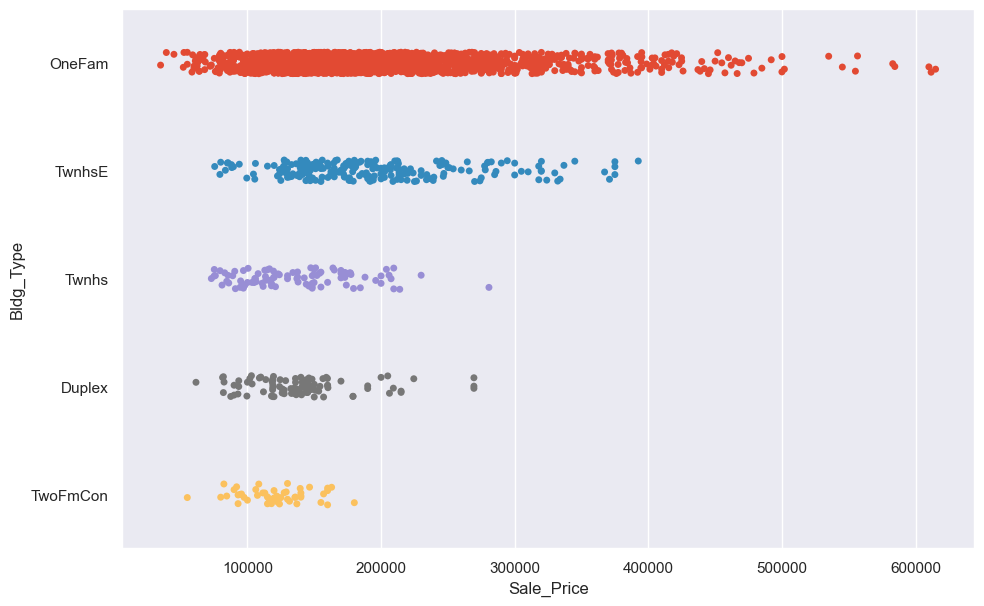

In [65]:
stripplot_single(dataset=df, categ_feat ='Bldg_Type', target ='Sale_Price')

In [66]:
bldg_type1 = ['OneFam'] 
bldg_type2 = ['TwnhsE']
bldg_type3 = ['Twnhs', 'Duplex']
bldg_type4 = ['TwoFmCon']

bldg_types = [bldg_type1, bldg_type2, bldg_type3, bldg_type4]
quick_categ_binning(dataset = df, target= 'Bldg_Type', name_like = 'bldg_type_', bins = bldg_types)
quick_categ_binning(dataset = df_orig, target='Bldg_Type', name_like = 'bldg_type_', bins = bldg_types)

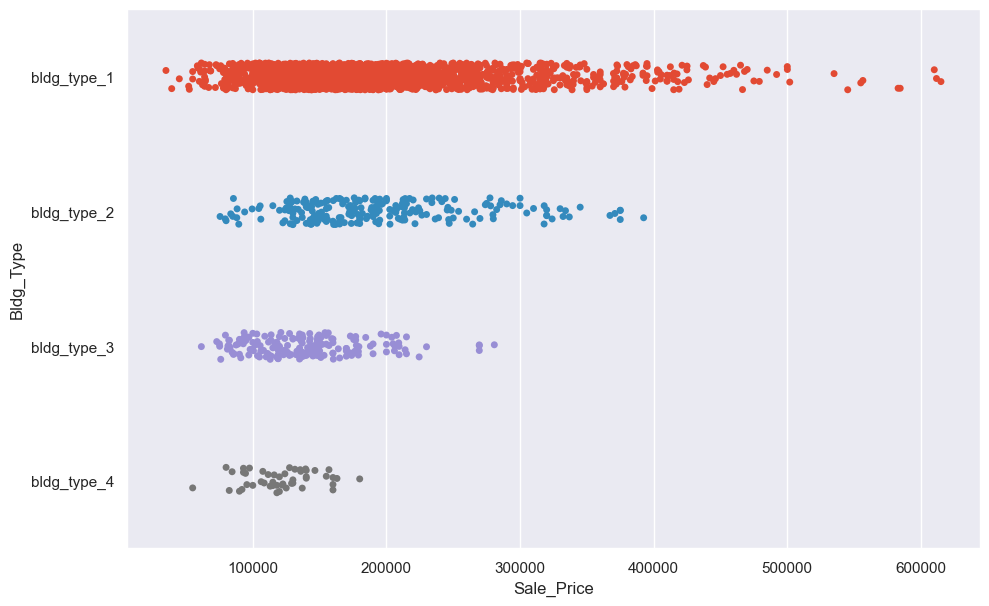

In [67]:
stripplot_single(dataset=df, categ_feat ='Bldg_Type', target ='Sale_Price')

This can be easily encoded into OHE and we can remove the `bld_type_1` as the we just need 0 in all the remaining ones to infer it.

In [68]:
ohe_encoding(dataset=df, categorical_features=['Bldg_Type'])
ohe_encoding(dataset=df_orig, categorical_features=['Bldg_Type'])
df.drop(columns=['bldg_type_4'], inplace=True)

df[get_cols(df, 'bldg_type')]

bldg_type_1  bldg_type_2  bldg_type_3
0             1.0          0.0          0.0
1             1.0          0.0          0.0
2             1.0          0.0          0.0
3             1.0          0.0          0.0
4             1.0          0.0          0.0
...           ...          ...          ...
2629          1.0          0.0          0.0
2630          1.0          0.0          0.0
2631          1.0          0.0          0.0
2632          1.0          0.0          0.0
2633          1.0          0.0          0.0

[2634 rows x 3 columns]

### House Style vs Sale Price

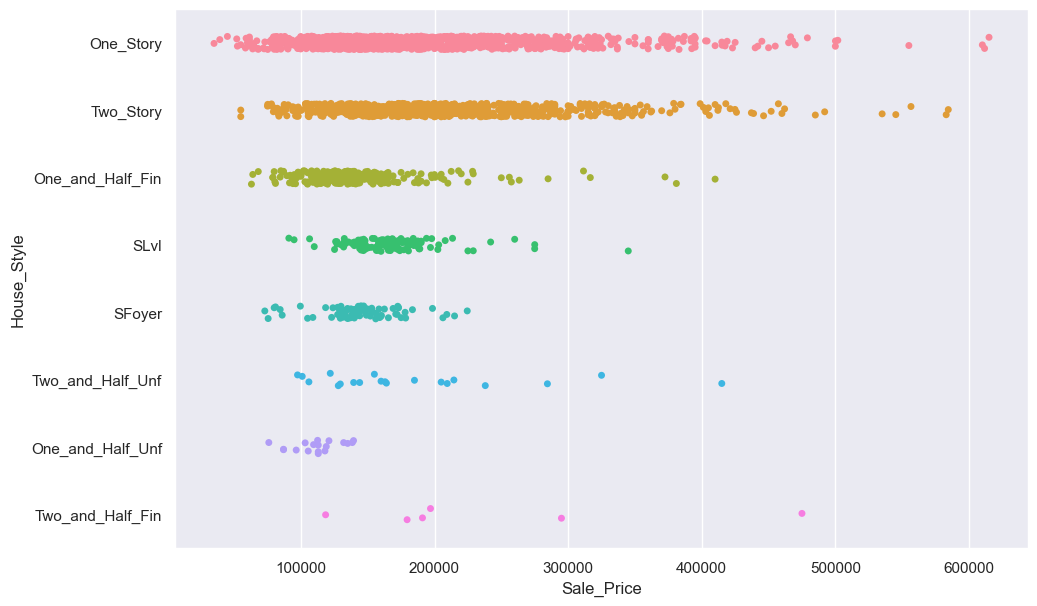

In [69]:
stripplot_single(dataset=df, categ_feat ='House_Style', target ='Sale_Price')

We could benefit once again from a OHE

In [70]:
hs_style1 = ['One_Story', 'Two_Story']
hs_style2 = ['One_and_Half_Fin', 'One_and_Half_Unf', 'SLvl', 'SFoyer']
hs_style3 = ['Two_and_Half_Fin', 'Two_and_Half_Unf']
hs_styles = [hs_style1, hs_style2, hs_style3]

quick_categ_binning(dataset = df, target= 'House_Style', name_like = 'hs_style_', bins = hs_styles)
quick_categ_binning(dataset = df_orig, target='House_Style', name_like = 'hs_style_', bins = hs_styles)

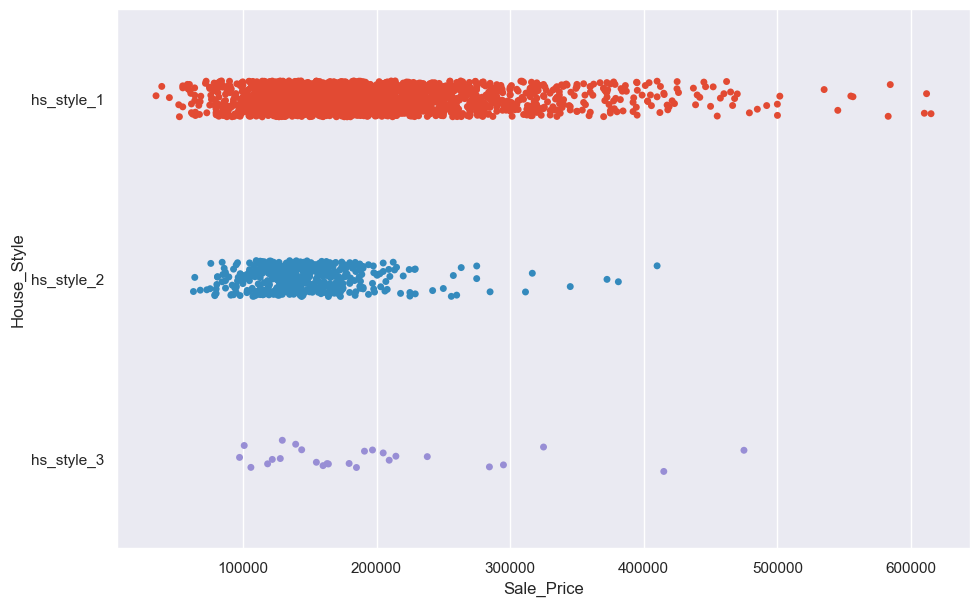

In [71]:
stripplot_single(dataset=df, categ_feat ='House_Style', target ='Sale_Price')

In [72]:
ohe_encoding(dataset=df, categorical_features=['House_Style'])
ohe_encoding(dataset=df_orig, categorical_features=['House_Style'])
df.drop(columns=['hs_style_3'], inplace=True)

df[get_cols(df, 'hs_style')]

hs_style_1  hs_style_2
0            1.0         0.0
1            1.0         0.0
2            1.0         0.0
3            1.0         0.0
4            1.0         0.0
...          ...         ...
2629         0.0         1.0
2630         1.0         0.0
2631         0.0         1.0
2632         1.0         0.0
2633         1.0         0.0

[2634 rows x 2 columns]

### MS Zoning vs Sale Price

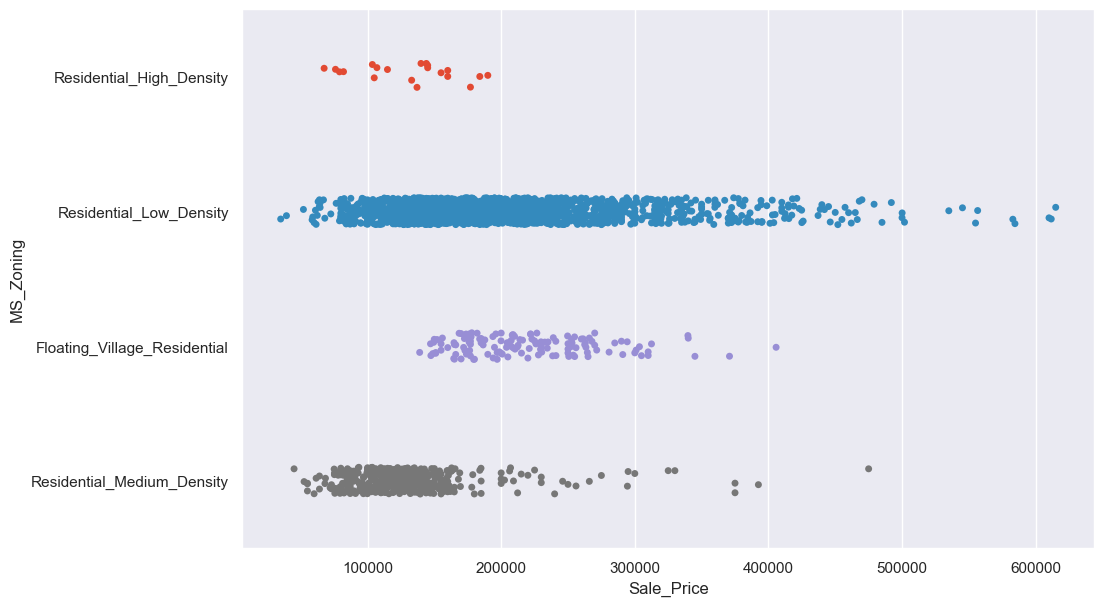

In [73]:
stripplot_single(dataset=df, categ_feat ='MS_Zoning', target ='Sale_Price')

We already have the neighborhoods to use as indicators, we do not need another variable for the location!

We still want to see how this could be used though.

In [74]:
ohe_encoding(dataset=df, categorical_features=['MS_Zoning'])
ohe_encoding(dataset=df_orig, categorical_features=['MS_Zoning'])

df.drop(columns=['Residential_High_Density'], inplace=True)
df[get_cols(df, 'Residential')]

Floating_Village_Residential  Residential_Low_Density  \
0                              0.0                      0.0   
1                              0.0                      1.0   
2                              0.0                      1.0   
3                              0.0                      1.0   
4                              0.0                      1.0   
...                            ...                      ...   
2629                           0.0                      1.0   
2630                           0.0                      1.0   
2631                           0.0                      1.0   
2632                           0.0                      1.0   
2633                           0.0                      1.0   

      Residential_Medium_Density  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  
...                          ...  
2629                         0.0  
2630                         0.0  
2631                         0.0  
2632                         0.0  
2633                         0.0  

[2634 rows x 3 columns]

### Neighborhood vs Sale Price

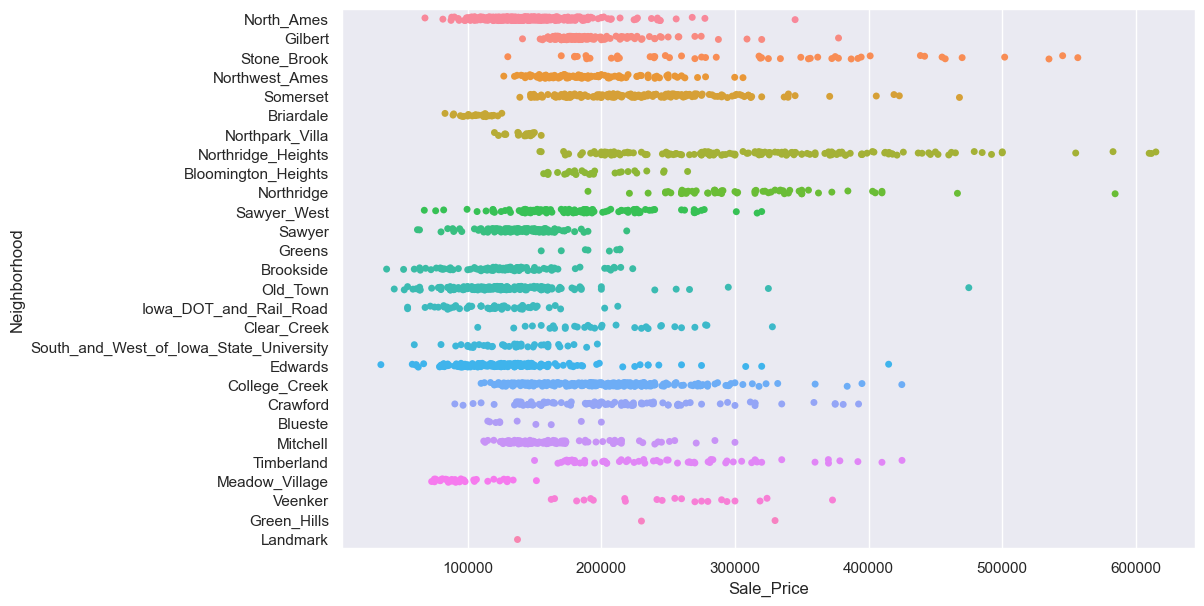

In [75]:
stripplot_single(dataset=df, categ_feat ='Neighborhood', target ='Sale_Price')

From this plot we can conclude the neighborhood per-se does not reall help. We might consider fusing them into blocks!

In [76]:
# Based on the graph

block1 = ['North_Ames', 'Sawyer_West', 'Sawyer', 
          'Brookside', 'Old_Town', 'Iowa_DOT_and_Rail_Road',
         'South_and_West_of_Iowa_State_University', 'Edwards', 'Landmark', 
          'Northpark_Villa']
block2 = ['Briardale', 'Meadow_Village']
block3 = ['Gilbert', 'Northwest_Ames', 'Somerset', 'Greens', 'Clear_Creek', 'Bloomington_Heights']
block4 = ['College_Creek', 'Crawford', 'Blueste', 
          'Mitchell', 'Veenker', 'Green_Hills', 
          'Timberland']
block5 = ['Northridge_Heights', 'Stone_Brook', 'Northridge']
n_blocks = [block1, block2, block3, block4, block5]

quick_categ_binning(dataset = df, target= 'Neighborhood', name_like = 'neighborhoods_', bins = n_blocks)
quick_categ_binning(dataset = df_orig, target= 'Neighborhood', name_like = 'neighborhoods_', bins = n_blocks)

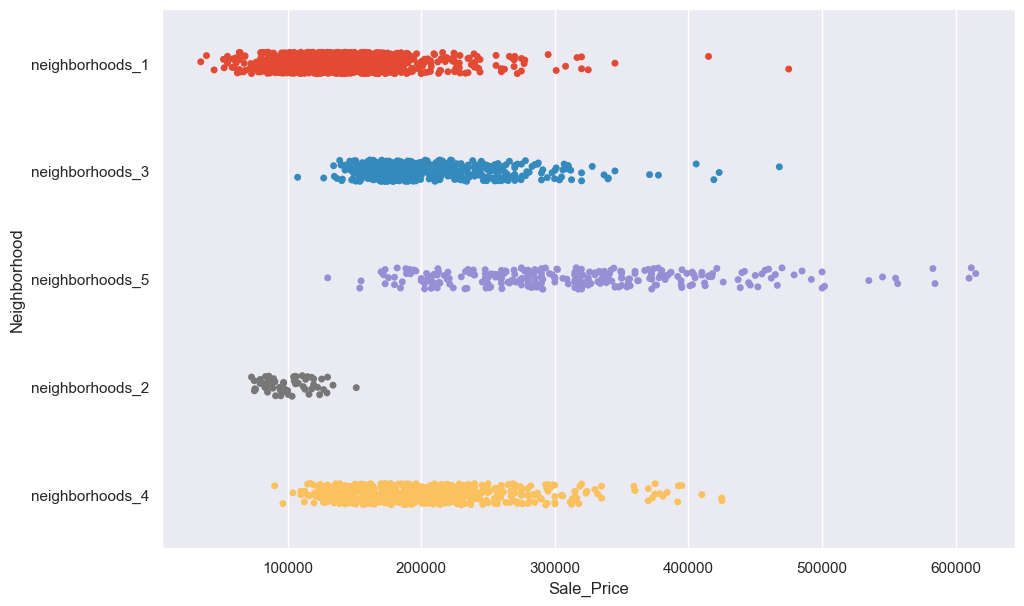

In [77]:
stripplot_single(dataset=df, categ_feat ='Neighborhood', target ='Sale_Price')

Now back to OHE

In [78]:
ohe_encoding(dataset=df, categorical_features=['Neighborhood'])
ohe_encoding(dataset=df_orig, categorical_features=['Neighborhood'])

df.drop(columns=['neighborhoods_5'], inplace=True)
df[get_cols(df, 'neighborhoods_')]

neighborhoods_1  neighborhoods_2  neighborhoods_3  neighborhoods_4
0                 1.0              0.0              0.0              0.0
1                 1.0              0.0              0.0              0.0
2                 1.0              0.0              0.0              0.0
3                 0.0              0.0              1.0              0.0
4                 0.0              0.0              1.0              0.0
...               ...              ...              ...              ...
2629              0.0              0.0              0.0              1.0
2630              0.0              0.0              0.0              1.0
2631              0.0              0.0              0.0              1.0
2632              0.0              0.0              0.0              1.0
2633              0.0              0.0              0.0              1.0

[2634 rows x 4 columns]

---

## Age related features vs Sale Price

As predicted the following features show a high correlation with the price.
* Year_Built
* Year_Remod_Add
* Age

### Year Built vs Sale Price

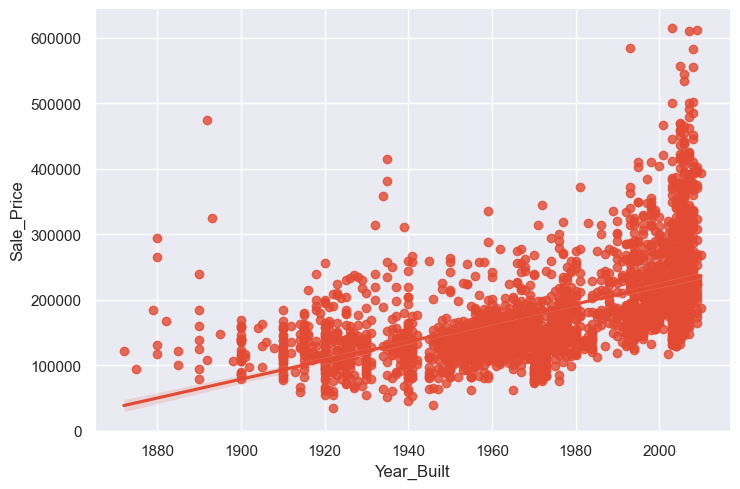

In [79]:
scatterplot_single(df, 'Year_Built', 'Sale_Price')

Until the 2000s we see a steady increase in `Sale_Price`, after that, the price skyrockets which could possibly mean we might need to encode the year of building differently.

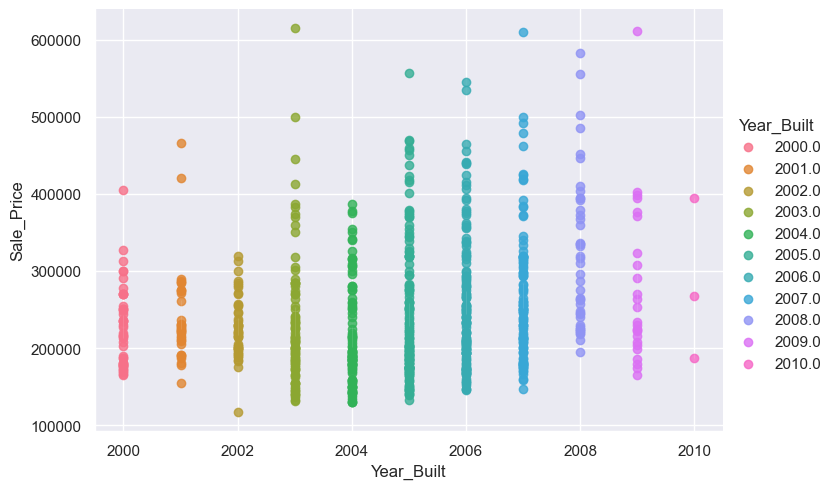

In [80]:
scatterplot_single(df[df['Year_Built'] >= 2000], 'Year_Built', 'Sale_Price', hue='Year_Built')

This graph shows very well how the increase in price stopped in 2008, and started decreasing soon after the crisis.

### Year Remod Add vs Sale Price

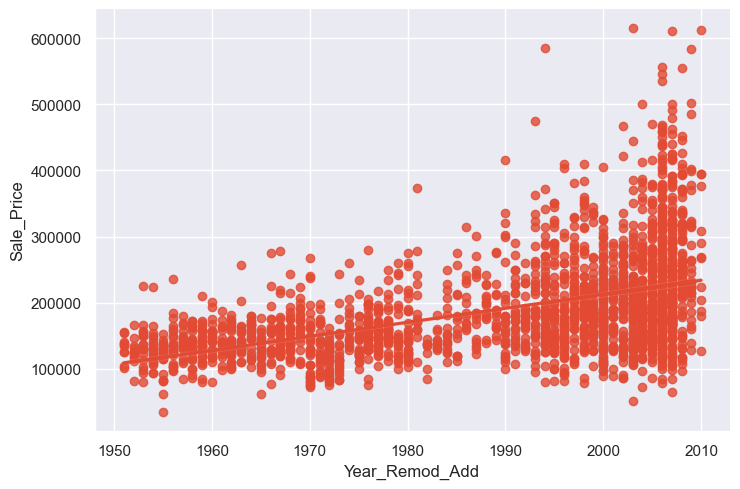

In [81]:
scatterplot_single(df[df['Year_Remod_Add']!=1950], 'Year_Remod_Add', 'Sale_Price')

From our results we found out that these two features have some correlation between them, let's see how do they change together

### Year Remod Add vs Year Built

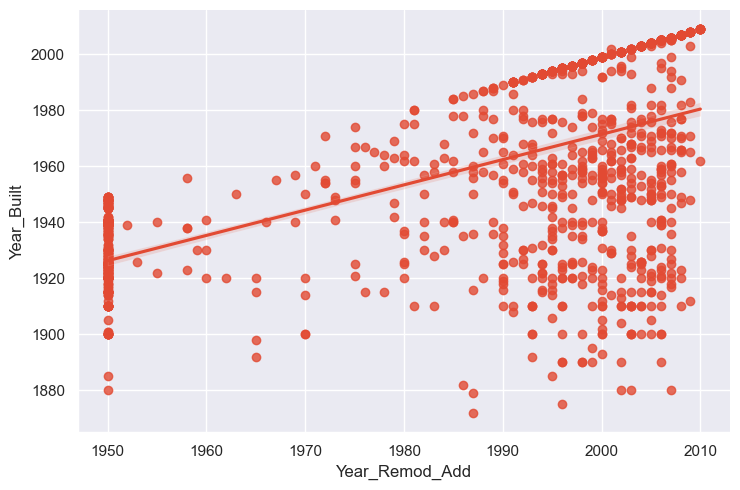

In [82]:
scatterplot_single(df[df['Year_Built']!= df['Year_Remod_Add']], 'Year_Remod_Add', 'Year_Built')

We can see that many houses were never remodeled, as they year of remodeling is the same year the houses were built .

To explore even more the aspect of the age and quality of the buildings we want to find how the aging process contributed to the price.

In [83]:
# Adding structure age variable depending if there was a major remodeling
df['Age'] = df.apply(lambda x: x['Year_Sold']-x['Year_Built'] if (x['Year_Built']<x['Year_Remod_Add'])
                     else (x['Year_Sold']-x['Year_Remod_Add']), axis=1)

df_orig['Age'] = df_orig.apply(lambda x: x['Year_Sold']-x['Year_Built'] if (x['Year_Built']<x['Year_Remod_Add']) 
                               else (x['Year_Sold']-x['Year_Remod_Add']), axis=1)

### Age vs Sale Price

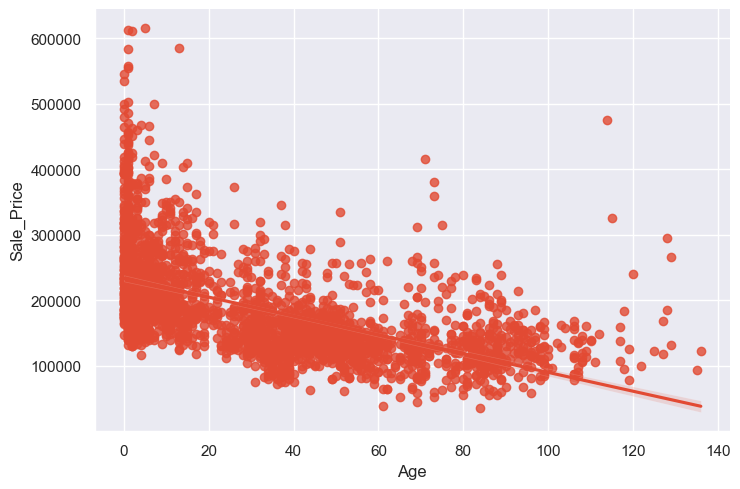

In [84]:
scatterplot_single(df, 'Age', 'Sale_Price')

As we can tell, the relationship is negative as the price decreaseases as time goes by without any remodeling.

The high correlation between these features was a result of the fact that `Year_Remod_Add` takes the same values as `Year_Built` for houses that were never renewed. 

Now we should decide whether to keep just one of the two or to apply other transformations. However an indicator could be useful

In [85]:
df['Remodeled'] = df.apply(lambda x: 0 if (x['Year_Built'] == x['Year_Remod_Add']) 
                                                           else (1), axis=1)

df_orig['Remodeled'] = df_orig.apply(lambda x: 0 if (x['Year_Built'] == x['Year_Remod_Add'])
                                     else (1), axis=1)

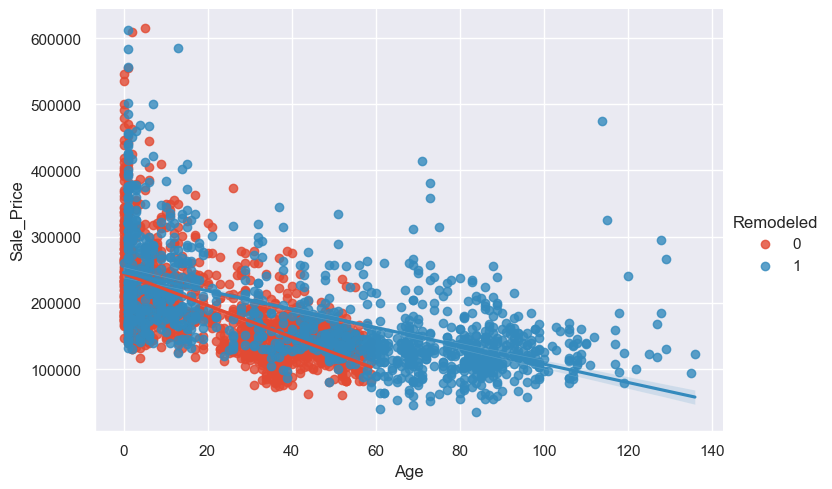

In [86]:
scatterplot_single(df, 'Age', 'Sale_Price', hue='Remodeled')

As predicted, house prices lower faster when the age of the building goes up, but the relationship still shows a lot of variance for price prediction. 

We can remove those houses which are over $60$ years old and have a price higher than $350.000$ and so on...

In [87]:
drop_rows_cond(dataset=df, condition=((df['Age'] > 60) & (df['Sale_Price']> 350000)), inplace = True)

In [88]:
drop_rows_cond(dataset=df, condition=((df['Age'] > 90) & (df['Sale_Price']> 300000)), inplace = True)

In [89]:
drop_rows_cond(dataset=df, condition=((df['Age'] > 100) & (df['Sale_Price']> 200000)), inplace = True)

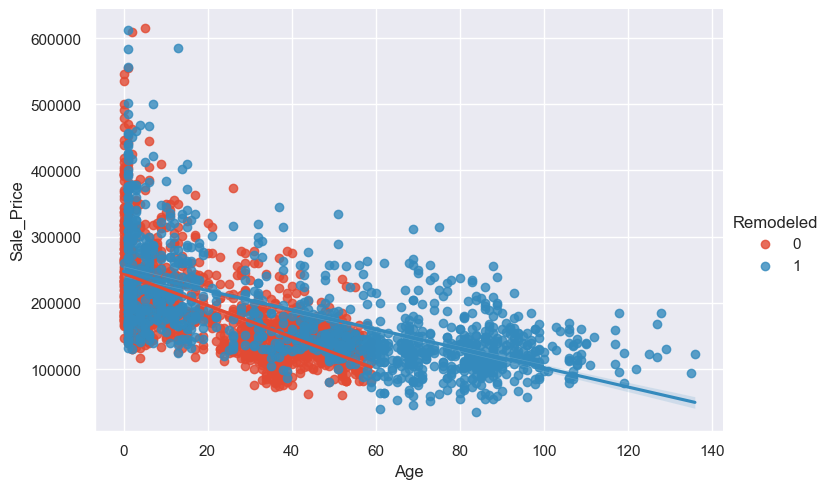

In [90]:
scatterplot_single(df, 'Age', 'Sale_Price', hue='Remodeled')

---

## Above ground living related features vs Sale Price
* Total_SF
* Fireplaces
* Total_Bath
* TotRms_AbvGrd

### Total SF vs Sale Price


To analyze the second floor against the sale price, we want to add an indicator just to see if the presence of 1+ floors affects the price in a different manner.

In [91]:
df['Two_Flr'] = df.apply(lambda x: 1 if(x['Second_Flr_SF']>0.0) else 0,axis=1)
df_orig['Two_Flr'] = df_orig.apply(lambda x: 1 if(x['Second_Flr_SF']>0.0) else 0,axis=1)

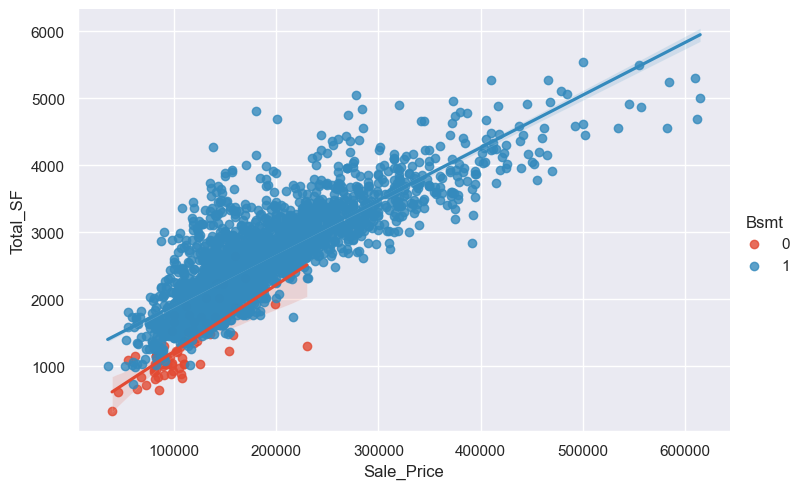

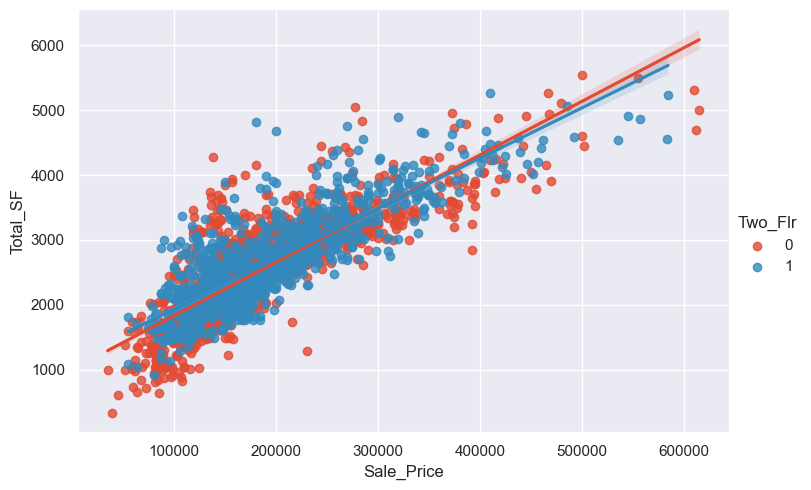

In [92]:
scatterplot_single(df, 'Sale_Price','Total_SF', hue='Bsmt')
scatterplot_single(df, 'Sale_Price','Total_SF', hue='Two_Flr')

The relationship looks amazing!
The total area  positively correlated with `Sale_Price` as we expected, and there is not much variance either. 

What is curious is that the basement indicator is the one which the most useful.

### Tot Rms Abv Grd vs Sale Price

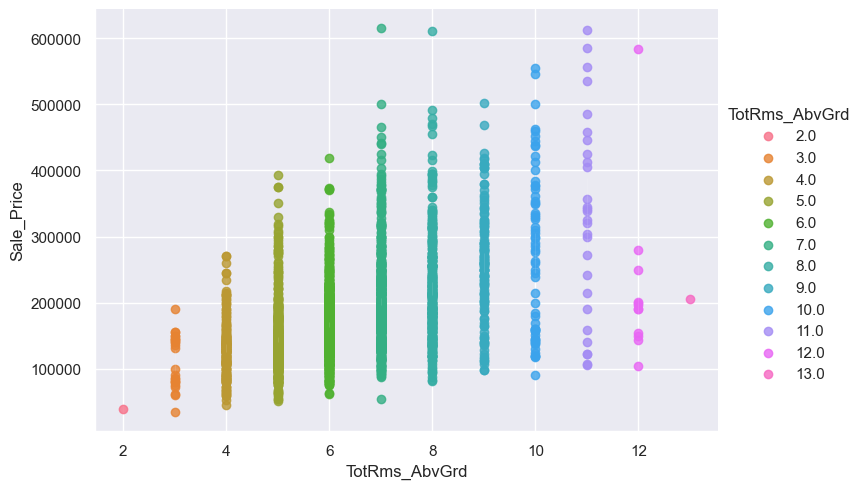

In [93]:
scatterplot_single(df, 'TotRms_AbvGrd','Sale_Price', hue='TotRms_AbvGrd')

For the houses that have 12 to 15 rooms above ground there is not a good representation, so we can say it's best to drop them.

In [94]:
drop_rows_cond(dataset=df, condition=(df['TotRms_AbvGrd']>=13.0), inplace = True)

### Tot Rms Abv Grd vs Gr Liv Area

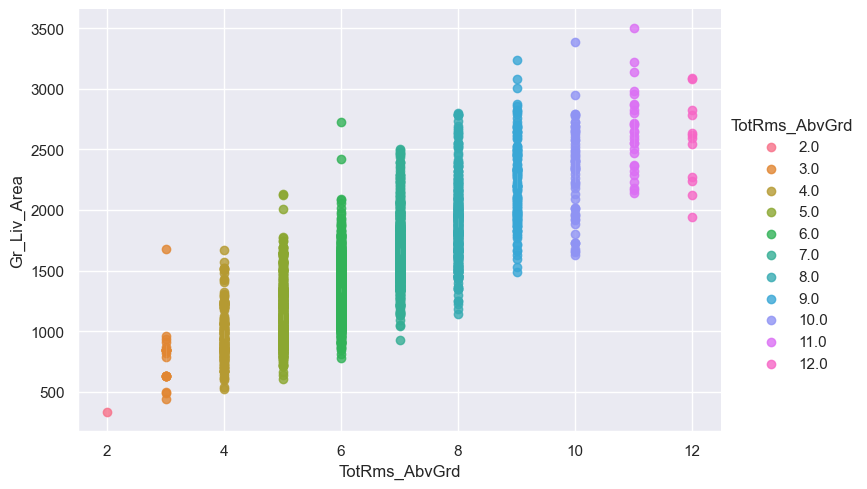

In [95]:
scatterplot_single(df, 'TotRms_AbvGrd','Gr_Liv_Area', hue='TotRms_AbvGrd')

We still see some outliers for the houses with 3 and 7 rooms

In [96]:
df.drop(df[(df['Gr_Liv_Area']>1500)&(df['TotRms_AbvGrd']==3)].index.tolist(), inplace=True)
df.drop(df[(df['Gr_Liv_Area']>3000)&(df['TotRms_AbvGrd']==7)].index.tolist(), inplace=True)
df.reset_index(drop=True, inplace=True)

### Rms Gr Area Ratio vs Sale Price

In [97]:
df['Gr_Area_Rms_Ratio']=  df['Gr_Liv_Area']/df['TotRms_AbvGrd']
df_orig['Gr_Area_Rms_Ratio']= df_orig['Gr_Liv_Area']/df_orig['TotRms_AbvGrd']

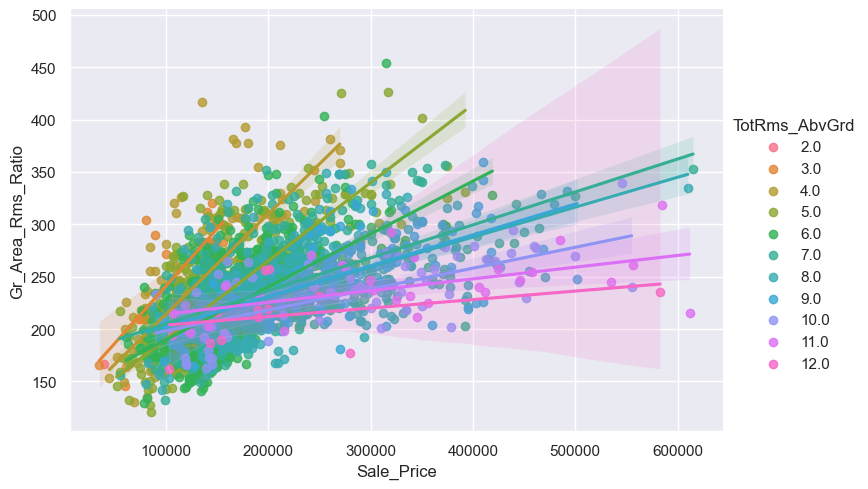

In [98]:
scatterplot_single(df,'Sale_Price', 'Gr_Area_Rms_Ratio', hue='TotRms_AbvGrd')

As we consider more and more variables the instances start becoming very close and we do not get any good insight

### Total bath vs Sale Price

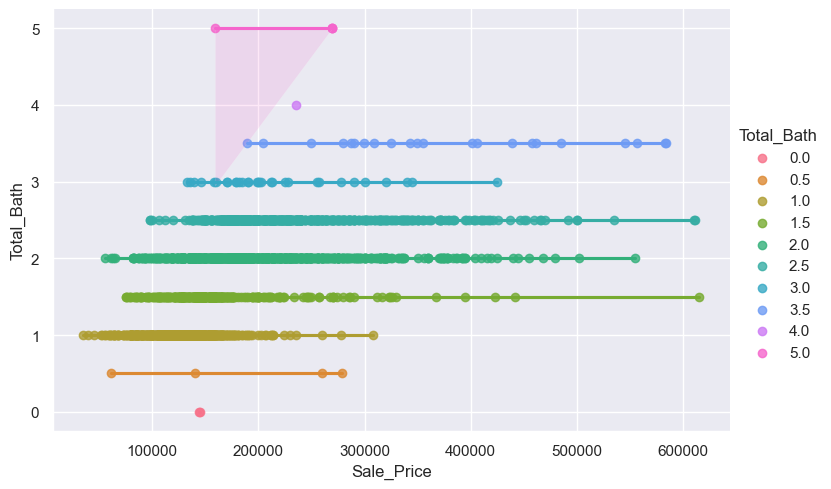

In [99]:
scatterplot_single(df,'Sale_Price', 'Total_Bath', hue='Total_Bath')

In [100]:
df['TotBath_LivArea_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Total_Bath'] if(x['Total_Bath']!=0.0) else 0.0, axis=1)
df_orig['TotBath_LivArea_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Total_Bath'] if(x['Total_Bath']!=0.0) else 0.0, axis=1)

### TotBath_LivArea_Ratio vs Sale Price

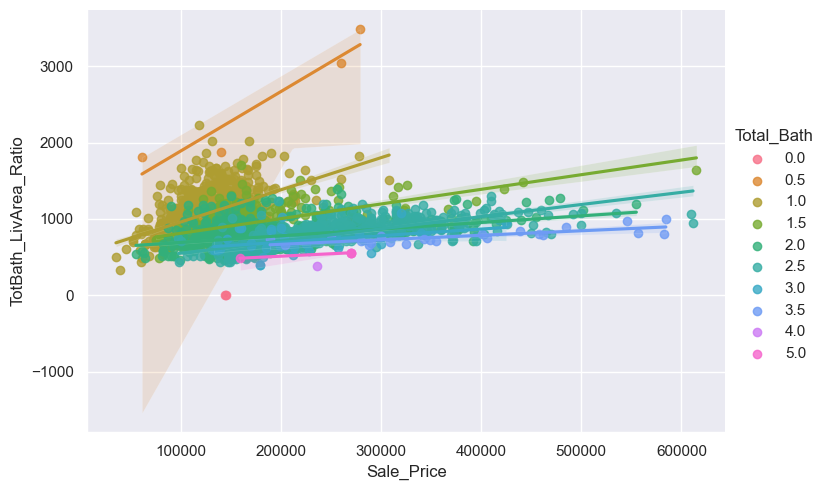

In [101]:
scatterplot_single(df, 'Sale_Price','TotBath_LivArea_Ratio', hue='Total_Bath')

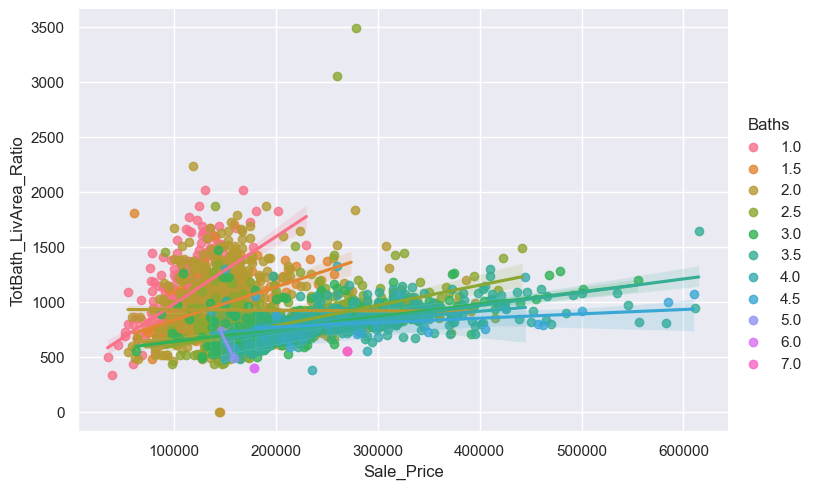

In [102]:
scatterplot_single(df, 'Sale_Price','TotBath_LivArea_Ratio', hue='Baths')

### Bedrooms vs Sale Price

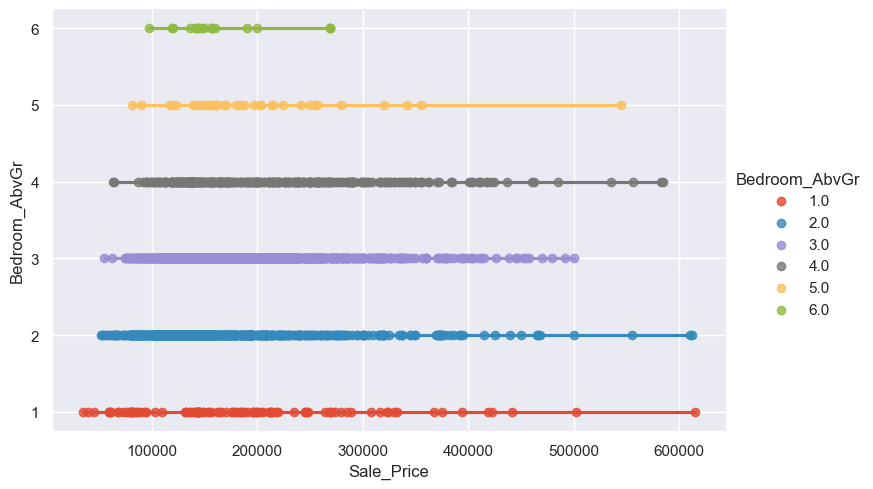

In [103]:
scatterplot_single(df, 'Sale_Price','Bedroom_AbvGr', hue='Bedroom_AbvGr')

### Bedrooms vs Gr Liv Area

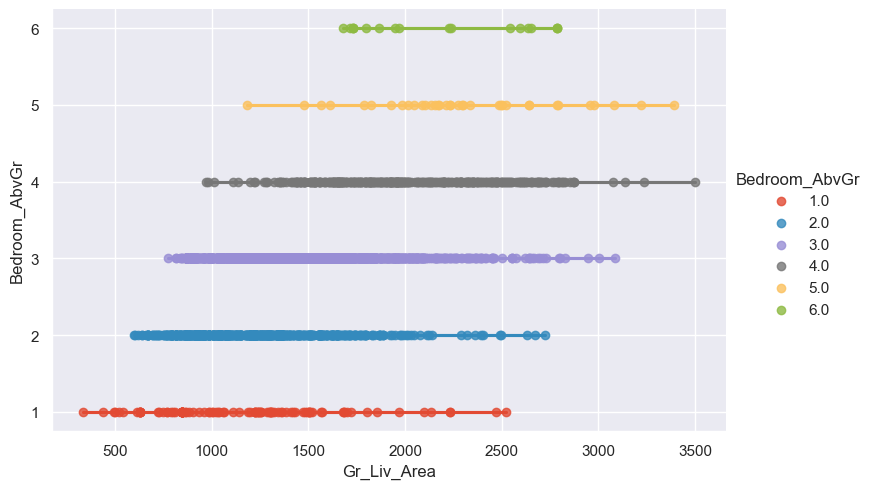

In [104]:
scatterplot_single(df, 'Gr_Liv_Area','Bedroom_AbvGr', hue='Bedroom_AbvGr')

In [105]:
df['Bedroom_Liv_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Bedroom_AbvGr'] if(x['Bedroom_AbvGr']!=0.0) else 0.0, axis=1)
df_orig['Bedroom_Liv_Area_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Bedroom_AbvGr'] if(x['Bedroom_AbvGr']!=0.0) else 0.0, axis=1)

### Bedroom_Liv_Area_Ratio vs Sale Price

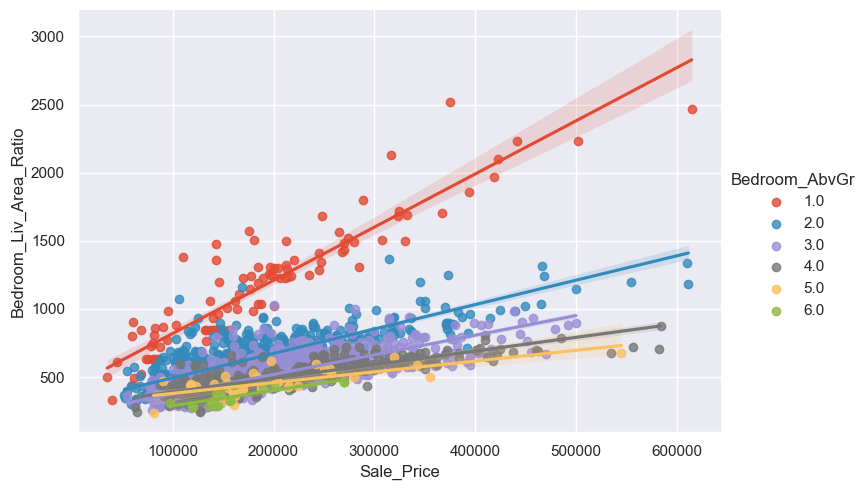

In [106]:
scatterplot_single(df, 'Sale_Price','Bedroom_Liv_Area_Ratio', hue='Bedroom_AbvGr')

### Fireplace vs Sale Price

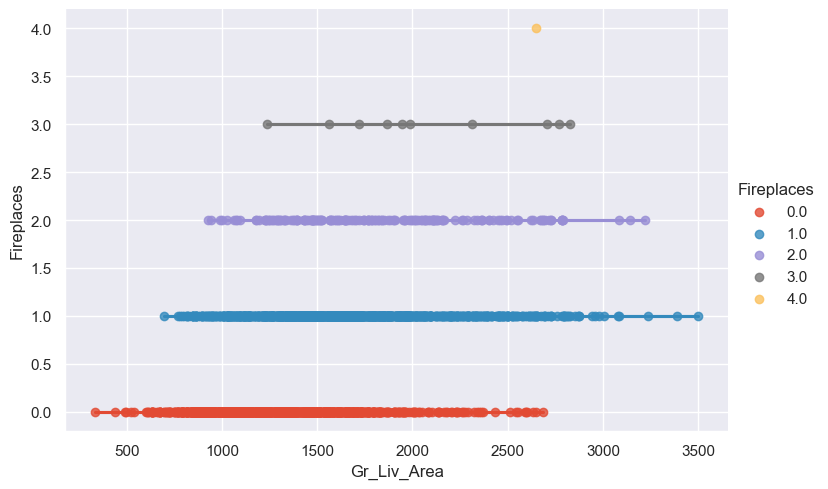

In [107]:
scatterplot_single(df,'Gr_Liv_Area', 'Fireplaces', hue='Fireplaces')

In [108]:
df['Fireplace_Gr_Area_Ratio'] = df.apply(lambda x : x['Gr_Liv_Area']/x['Fireplaces'] if(x['Fireplaces']!=0.0) else 0.0, axis=1)
df_orig['Fireplace_Gr_Area_Ratio'] = df_orig.apply(lambda x : x['Gr_Liv_Area']/x['Fireplaces'] if(x['Fireplaces']!=0.0) else 0.0, axis=1)

### Fireplace Gr_Area Ratio vs Sale Price

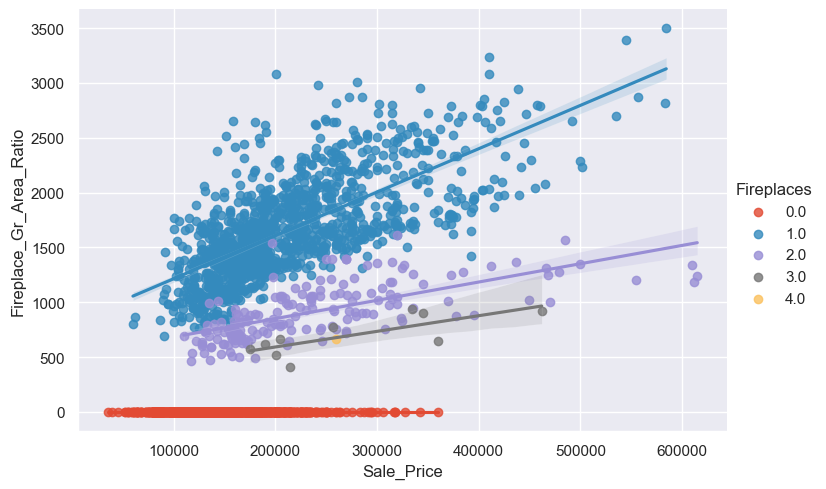

In [109]:
scatterplot_single(df,'Sale_Price', 'Fireplace_Gr_Area_Ratio', hue='Fireplaces')

## Garage related features vs Sale Price
* Garage_Cars
* Garage_Area
* Garage_Cond
* Garage_Qual
* Garage_Type
* Garage_Finish

### Garage Area vs Sale Price

As we can predict, there will be instances without any garage. Let us add another indicator.

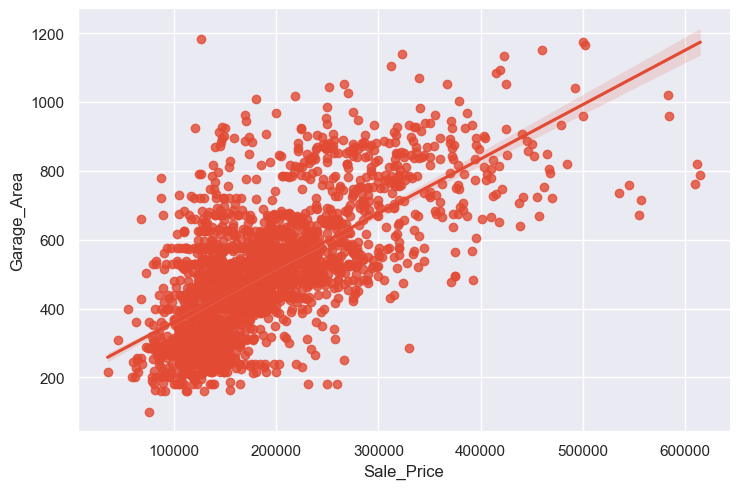

In [110]:
scatterplot_single(df[df['Garage_Area']>0.0], target='Sale_Price', label='Garage_Area')

The relationship is very well defined, as expected.

In [111]:
df[(df['Garage_Area'] > 0.0) & (df['Garage_Type'] == 'No_Garage')]

Empty DataFrame
Columns: [Baths, Bedroom_AbvGr, Bsmt, Bsmt_Cond, Bsmt_Exposure, Bsmt_Full_Bath, Bsmt_Half_Bath, Bsmt_Qual, Bsmt_Total_Bath, Bsmt_Unf_SF, Central_Air, Electrical, Exter_Cond, Exter_Qual, External_SF, Fence, Fireplace_Qu, Fireplaces, First_Flr_SF, Full_Bath, Garage_Area, Garage_Cars, Garage_Cond, Garage_Finish, Garage_Qual, Garage_Type, Gr_Liv_Area, Half_Bath, Heating, Heating_QC, Kitchen_AbvGr, Kitchen_Qual, Land_Contour, Land_Slope, Latitude, Longitude, Lot_Area, Lot_Frontage, LowQ_Total_Liv_Ratio, Low_Qual_Fin_SF, Mas_Vnr_Area, Mas_Vnr_Type, Mo_Sold, Overall_Cond, Overall_Qual, Paved_Drive, Pool_Area, Pool_QC, Roof_Matl, Roof_Style, Second_Flr_SF, TotRms_AbvGrd, Total_Bath, Total_Bsmt_SF, Total_SF, Year_Built, Year_Remod_Add, Year_Sold, Sale_Price, Log1p_Sale_Price, sale_cond_1, sale_cond_2, Alley_Access, bldg_type_1, bldg_type_2, bldg_type_3, hs_style_1, hs_style_2, Floating_Village_Residential, Residential_Low_Density, Residential_Medium_Density, neighborhoods_1, neighborhoods_2, neighborhoods_3, neighborhoods_4, Age, Remodeled, Two_Flr, Gr_Area_Rms_Ratio, TotBath_LivArea_Ratio, Bedroom_Liv_Area_Ratio, Fireplace_Gr_Area_Ratio]
Index: []

[0 rows x 82 columns]

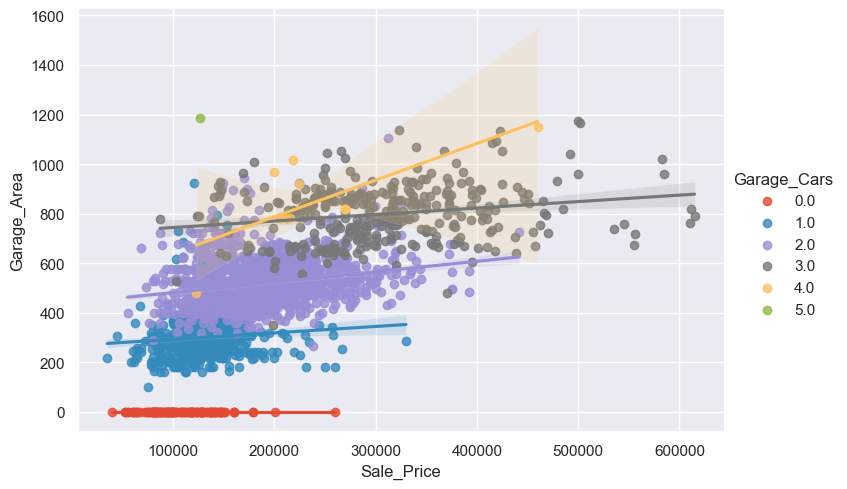

In [112]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage_Cars')

This looks like an outlier for sure, just by looking at the prices we can see there is an increasing trend for prices! 

In [113]:
df.drop(df.loc[df['Garage_Cars']>=5].index.tolist(), inplace=True)
df.drop(df.loc[df['Garage_Area']>1200].index.tolist(), inplace=True)
df.reset_index(drop=True, inplace=True)

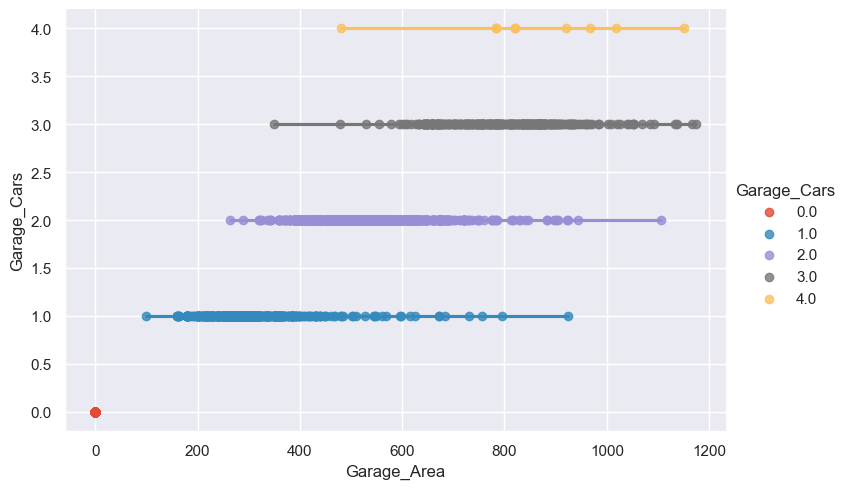

In [114]:
scatterplot_single(df, target='Garage_Area', label='Garage_Cars', hue='Garage_Cars')

### Garage Type vs Sale Price

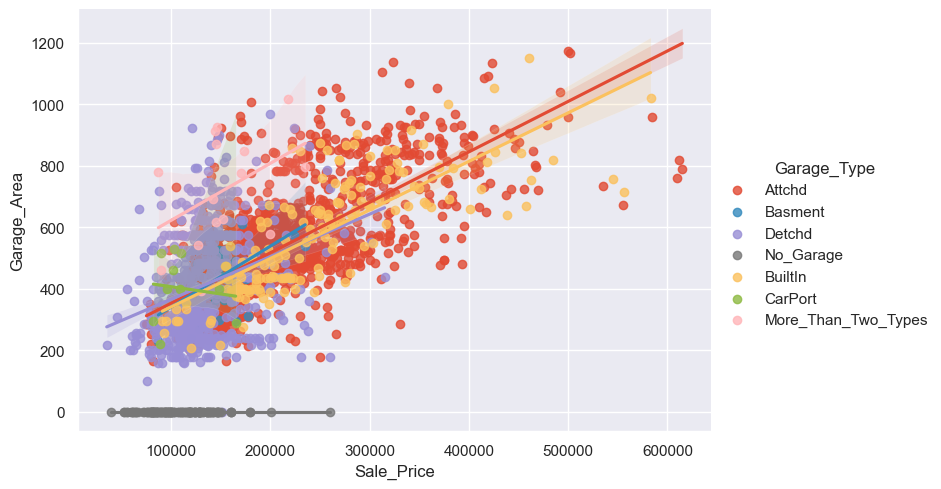

In [115]:
scatterplot_single(df, target='Sale_Price', label='Garage_Area', hue='Garage_Type')

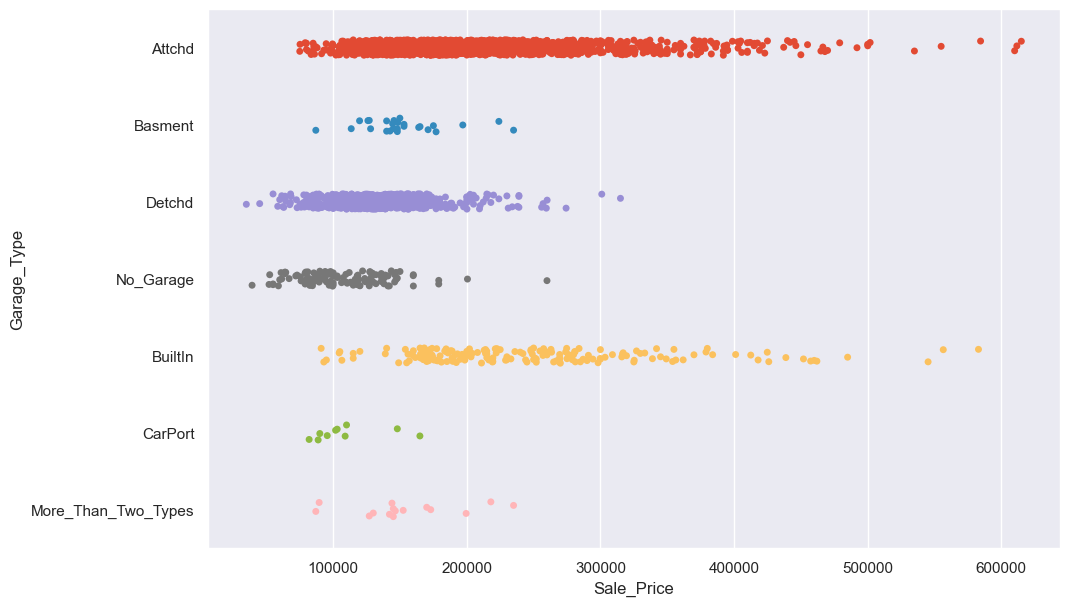

In [116]:
stripplot_single(dataset=df, categ_feat ='Garage_Type', target ='Sale_Price')

In [117]:
garage_1=['Attchd','BuiltIn','Basment']
garage_3=['No_Garage']
garage_2=['Detchd', 'CarPort', 'More_Than_Two_Types']
garage_blocks = [garage_1, garage_2, garage_3]

quick_categ_binning(dataset = df, target= 'Garage_Type', name_like = 'garage_type_', bins = garage_blocks)
quick_categ_binning(dataset = df_orig, target='Garage_Type', name_like = 'garage_type_', bins = garage_blocks)

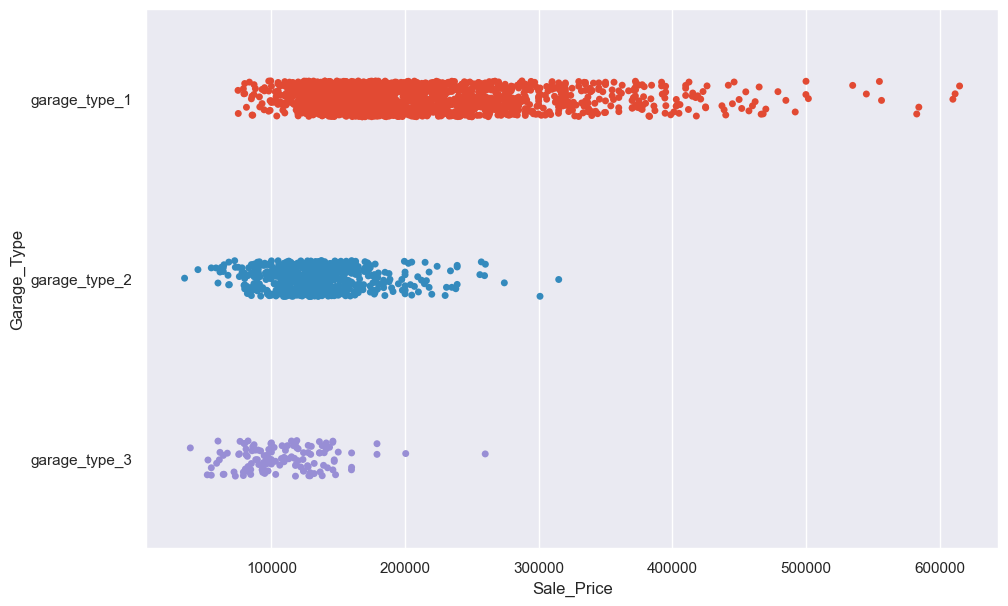

In [118]:
stripplot_single(dataset=df, categ_feat ='Garage_Type', target ='Sale_Price')

In [119]:
ohe_encoding(dataset=df, categorical_features=['Garage_Type'])
ohe_encoding(dataset=df_orig, categorical_features=['Garage_Type'])

df.drop(columns=['garage_type_3'], inplace=True)
df[get_cols(df, 'garage_type')]

garage_type_1  garage_type_2
0               1.0            0.0
1               1.0            0.0
2               1.0            0.0
3               1.0            0.0
4               1.0            0.0
...             ...            ...
2618            0.0            1.0
2619            1.0            0.0
2620            0.0            0.0
2621            1.0            0.0
2622            1.0            0.0

[2623 rows x 2 columns]

No we can discriminate more between this important variable

## Basement related features vs Sale Price

### Total Bsmt SF vs Sale Price

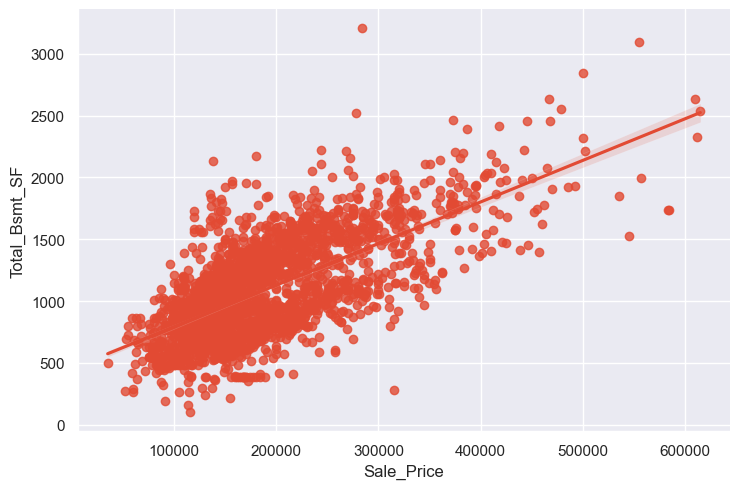

In [120]:
scatterplot_single(df[df['Total_Bsmt_SF']>0.0], 'Sale_Price', 'Total_Bsmt_SF')

This feature really correlates well with the Sale_Price

### Bsmt_Unf_SF

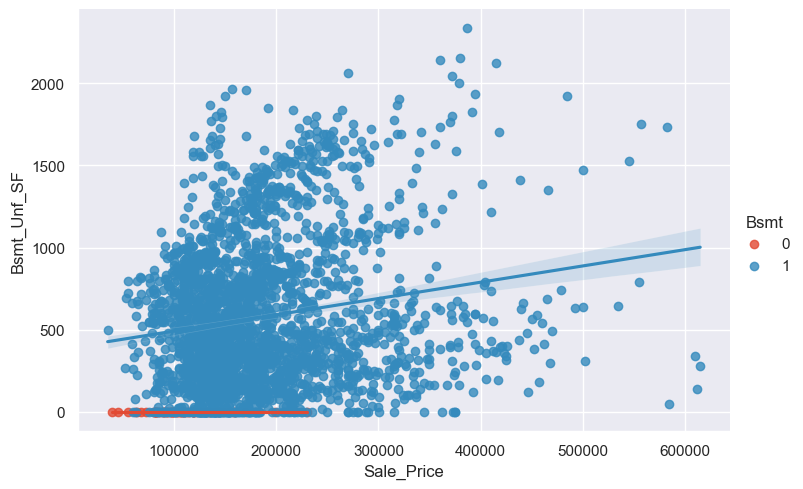

In [121]:
scatterplot_single(df, 'Sale_Price', 'Bsmt_Unf_SF', hue='Bsmt')

In [122]:
from scipy.stats import boxcox

xt, _ = boxcox((df['Bsmt_Unf_SF']+1))
df['BC_Bsmt_Unf_SF'] = np.log1p(xt)

xt2, _ = boxcox((df_orig['Bsmt_Unf_SF']+1))
df_orig['BC_Bsmt_Unf_SF'] = np.log1p(xt2)

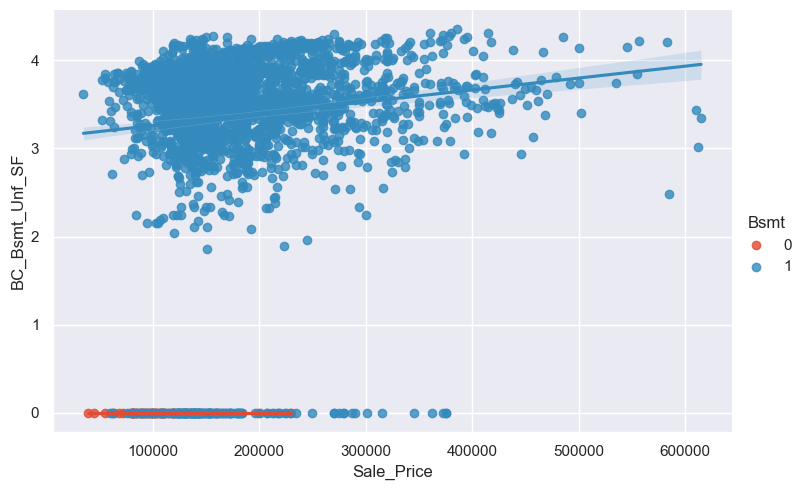

In [123]:
scatterplot_single(df, 'Sale_Price', 'BC_Bsmt_Unf_SF', hue='Bsmt')

However, the unfinished basement does not seem really useful even in this version.

### Bsmt Total Bath vs Sale Price

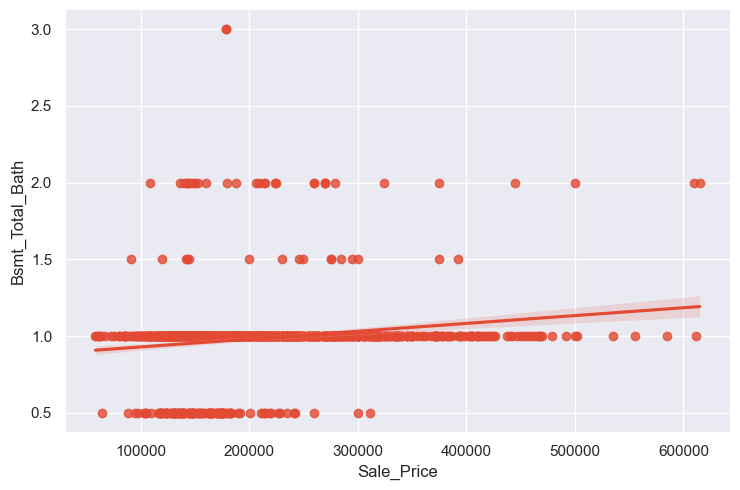

In [124]:
scatterplot_single(df[df['Bsmt_Total_Bath']>0.0], 'Sale_Price', 'Bsmt_Total_Bath')

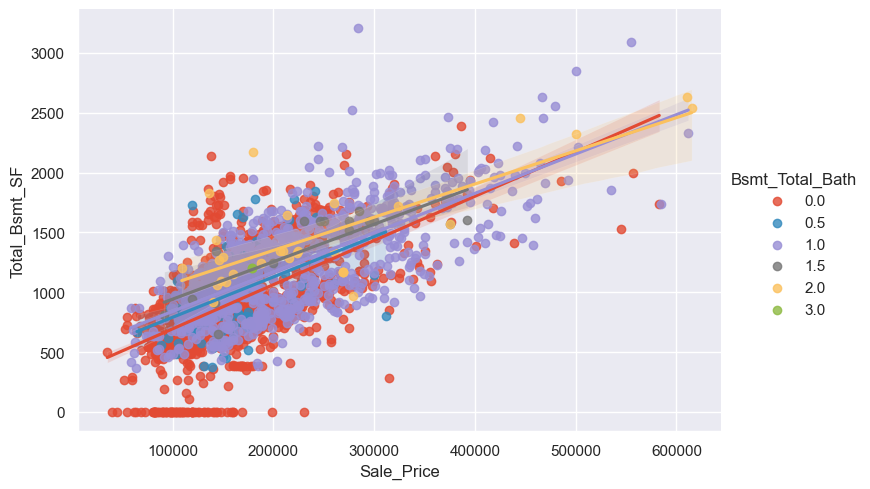

In [125]:
scatterplot_single(df, 'Sale_Price', 'Total_Bsmt_SF', hue='Bsmt_Total_Bath')

There is no relevant correlation here with number of total bath, but the SF of the basement show a great correlation.

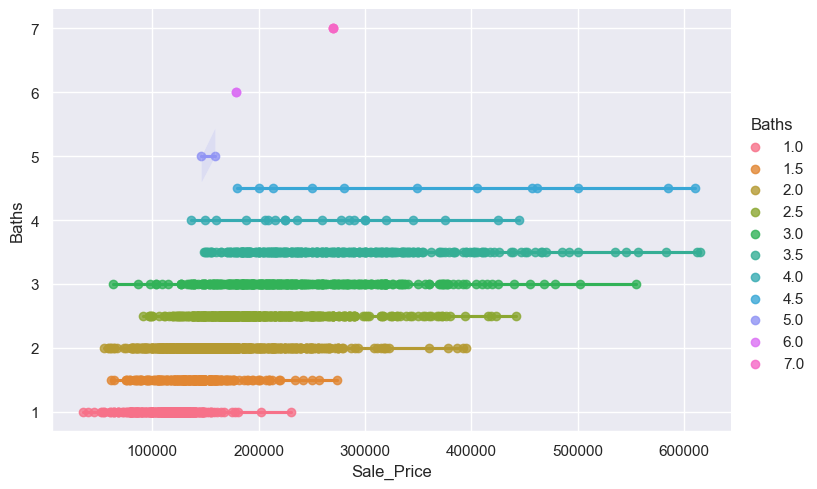

In [126]:
scatterplot_single(df, 'Sale_Price', 'Baths', hue='Baths')

## External related features vs Sale Price
* Roof related features
* Mas_Vnr_Area
* Porch related features
* Deck related features

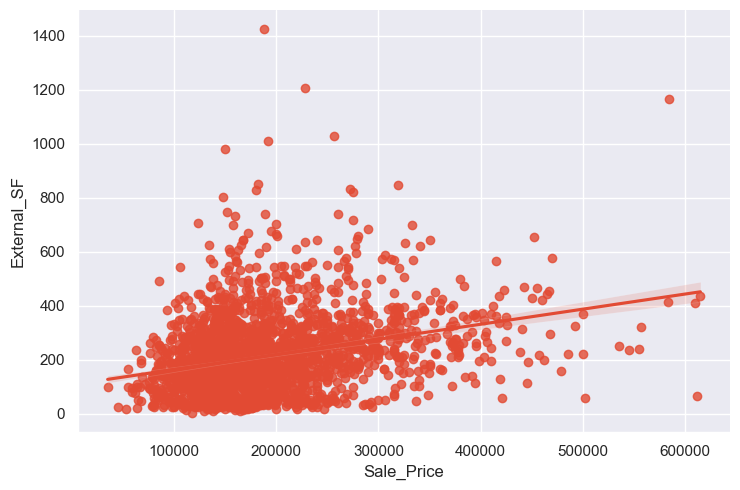

In [127]:
scatterplot_single(df[df['External_SF']!=0.0], 'Sale_Price','External_SF')

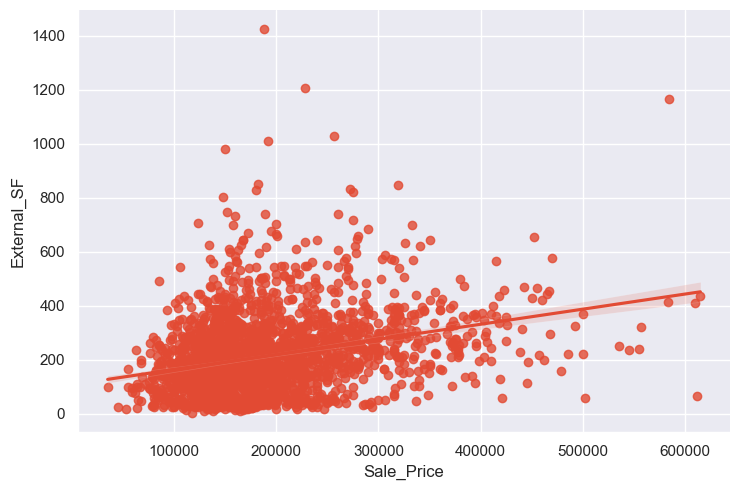

In [128]:
df['Exter_Pool_SF'] = df['External_SF'] + df['Pool_Area']
scatterplot_single(df[df['External_SF']!=0.0], 'Sale_Price','External_SF')

As we predicted, this could be really useful. Let us see if the boxcox can help

In [129]:
df['External_SF'] = df['External_SF'] + df['Pool_Area']
df_orig['External_SF'] = df_orig['External_SF'] + df_orig['Pool_Area']

df.drop(columns=['Exter_Pool_SF'], inplace=True)

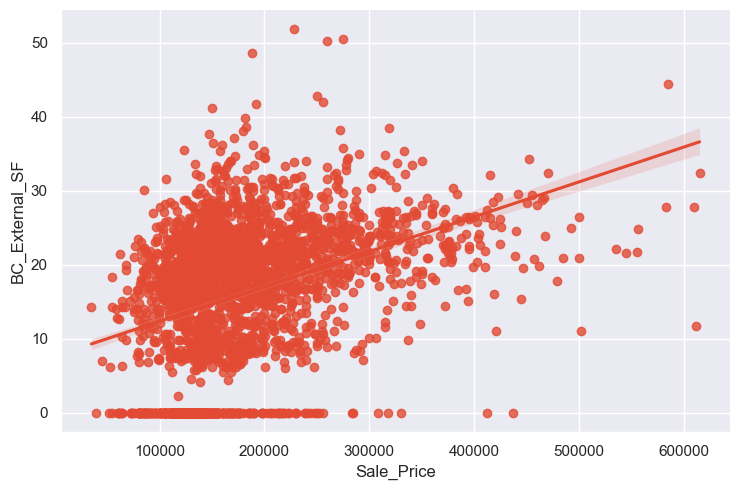

In [130]:
xt, _ = boxcox((df['External_SF']+1))
df['BC_External_SF'] = xt

xt2, _ = boxcox((df_orig['External_SF']+1))
df_orig['BC_External_SF'] = xt2

scatterplot_single(df, 'Sale_Price','BC_External_SF')

The scale has change, but the relationships seems to be the same!

### Roof Material

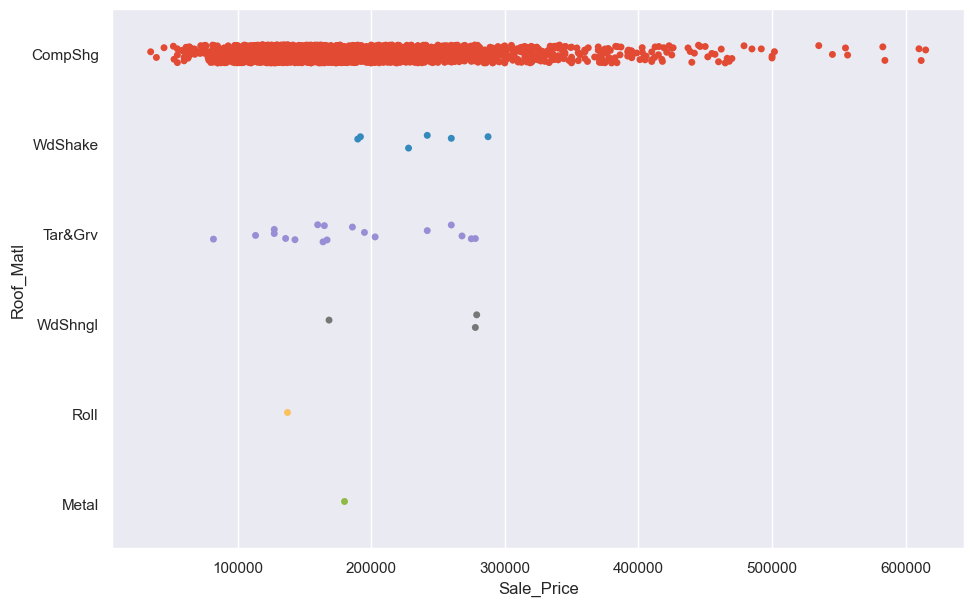

In [131]:
stripplot_single(dataset=df, categ_feat ='Roof_Matl', target ='Sale_Price')

Again, one class is predominant and the feature can be ignored

In [132]:
df.drop(columns=['Roof_Matl'], inplace=True)

### Roof Style

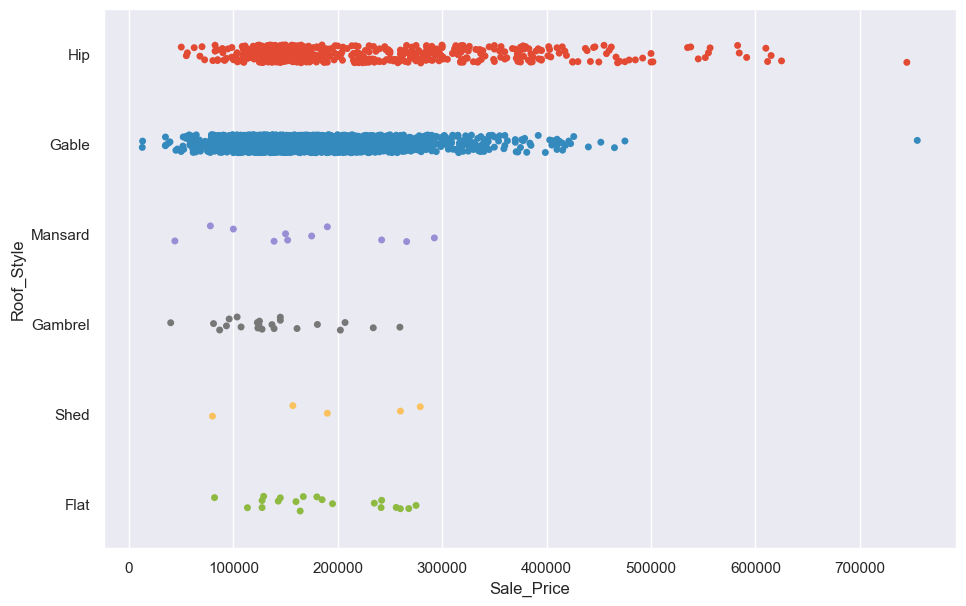

In [133]:
stripplot_single(dataset=df_orig, categ_feat ='Roof_Style', target ='Sale_Price')

We can see the observations are very limited for the roof styles that are not `Hip` or `Gable` and this suggests removal

In [134]:
df.drop(columns=['Roof_Style'], inplace=True)

### Mas Vnr Type

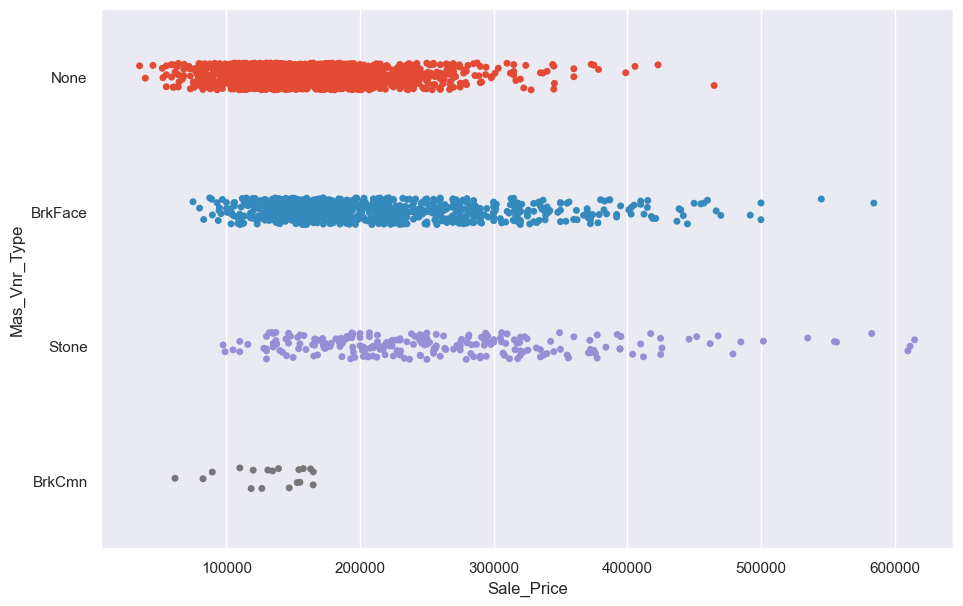

In [135]:
stripplot_single(dataset=df, categ_feat ='Mas_Vnr_Type', target ='Sale_Price')

Here there are more categories that need to be looked at.

### Mas Vnr Area vs Sale Price

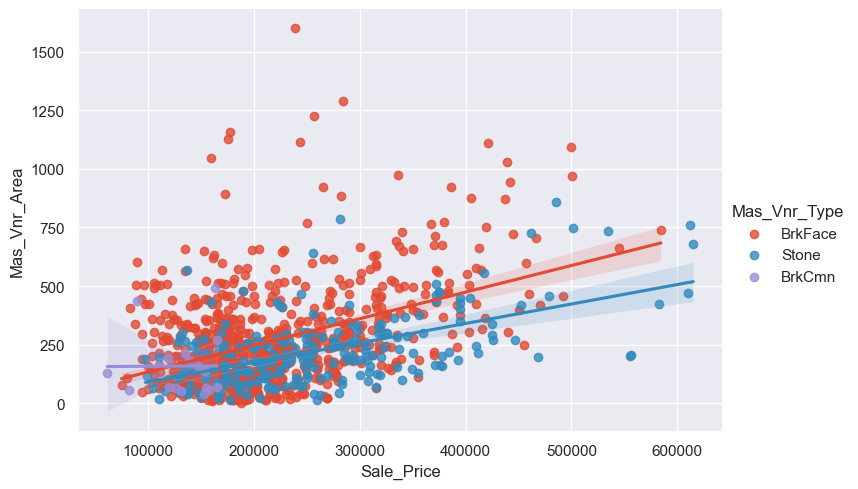

In [136]:
scatterplot_single(df[df['Mas_Vnr_Area']!=0.0], 'Sale_Price','Mas_Vnr_Area', 'Mas_Vnr_Type')

There is no good transformation for this feature at this point. But we can still try to group the types to see if something changes.

In [137]:
mv_1=['Stone']
mv_2=['BrkCmn', 'BrkFace']
mv_3=['None']
mv_s = [mv_1, mv_2, mv_3]

quick_categ_binning(dataset = df, target= 'Mas_Vnr_Type', name_like = 'Mas_Vnr_', bins = mv_s )
quick_categ_binning(dataset = df_orig, target='Mas_Vnr_Type', name_like = 'Mas_Vnr_', bins = mv_s)

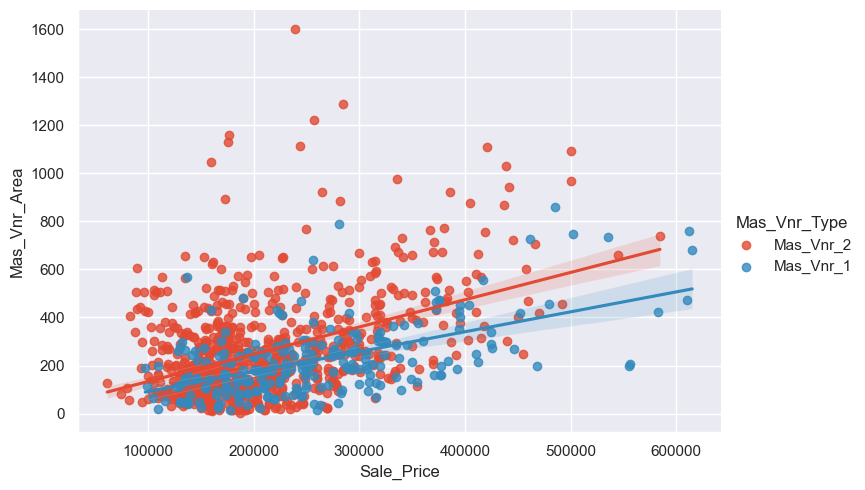

In [138]:
scatterplot_single(df[df['Mas_Vnr_Area']!=0.0], 'Sale_Price','Mas_Vnr_Area', 'Mas_Vnr_Type')

The variance seems too great, but we can keep it for now.

In [139]:
ohe_encoding(dataset=df, categorical_features=['Mas_Vnr_Type'])
ohe_encoding(dataset=df_orig, categorical_features=['Mas_Vnr_Type'])

df.drop(columns=['Mas_Vnr_2'], inplace=True)

### Pool Area

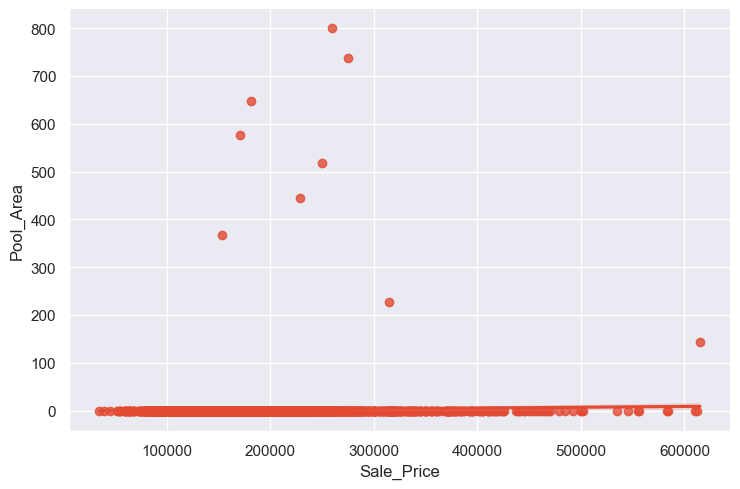

In [140]:
scatterplot_single(df,'Sale_Price', 'Pool_Area')

As they lack evidence, it is best to discard the pool Area!

In [141]:
df.drop(columns=['Pool_Area', 'Pool_QC'], inplace=True)

## Technical Features

### Central Air vs Sale Price

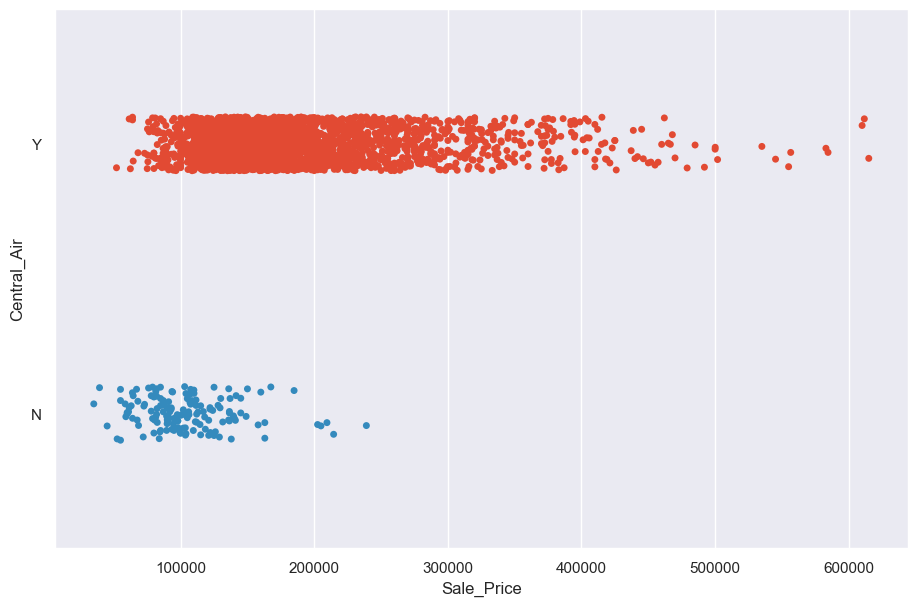

In [142]:
stripplot_single(dataset=df, categ_feat ='Central_Air', target ='Sale_Price')

A binary encoding can help here

In [143]:
dummy_encoding(df, target_feat='Central_Air', new_feat_name='Central_Air', index_col_drop=1)
dummy_encoding(df_orig, target_feat='Central_Air', new_feat_name='Central_Air', index_col_drop=1)

### Electrical vs Sale Price

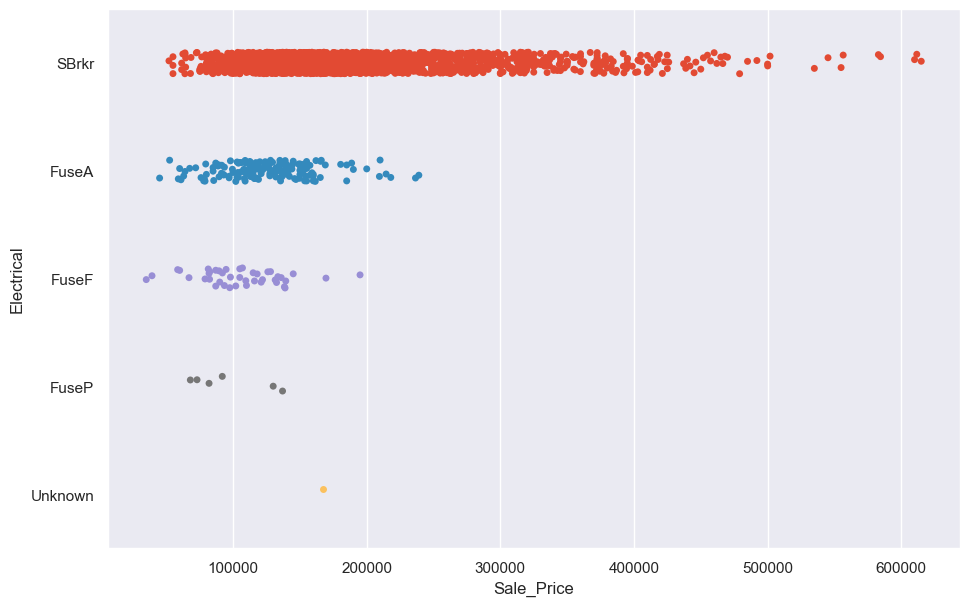

In [144]:
stripplot_single(dataset=df, categ_feat ='Electrical', target ='Sale_Price')

In [145]:
e_t1=['SBrkr']
e_t2=['FuseA', 'FuseF', 'FuseP', 'Unknown', 'Mix']
e_ts = [e_t1,e_t2]

quick_categ_binning(dataset = df, target= 'Electrical', name_like = 'Electrical_1', bins =e_ts)
quick_categ_binning(dataset = df_orig, target= 'Electrical', name_like = 'Electrical_1', bins =e_ts)

dummy_encoding(df, target_feat='Electrical', new_feat_name='Electrical_SBrkr', index_col_drop=1)
dummy_encoding(df_orig, target_feat='Electrical', new_feat_name='Electrical_SBrkr', index_col_drop=1)

The encoding done will greatly divide the categories for $1$ vs all binary indicator

### Heating vs Sale Price

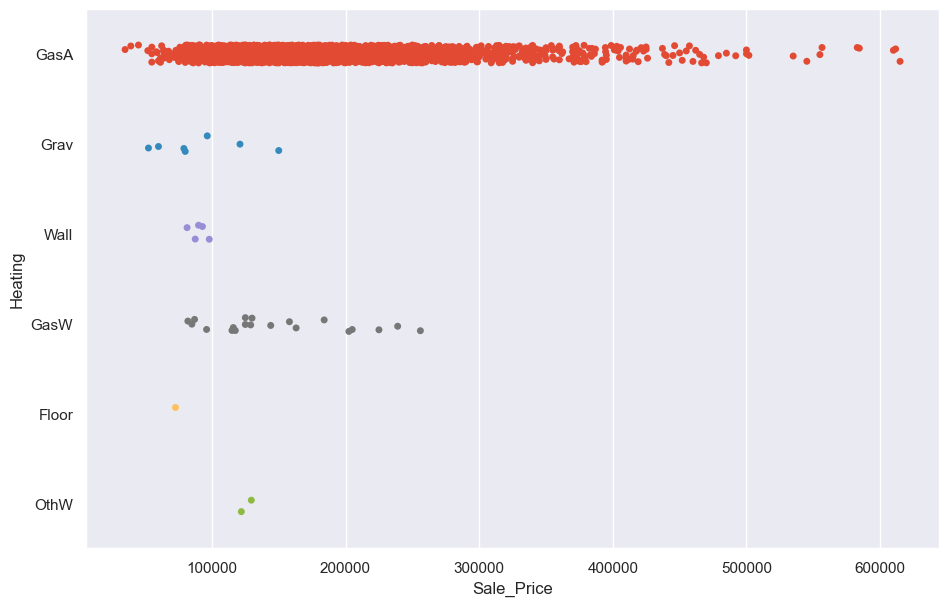

In [146]:
stripplot_single(dataset=df, categ_feat ='Heating', target ='Sale_Price')

The category `GasA` is predominant, and there are very few instances of the remaining features. We also want to drop the related quality feature as we already have the overall quality feature.

In [147]:
df.drop(columns=['Heating', 'Heating_QC'], inplace=True)

### Fence vs Sale Price

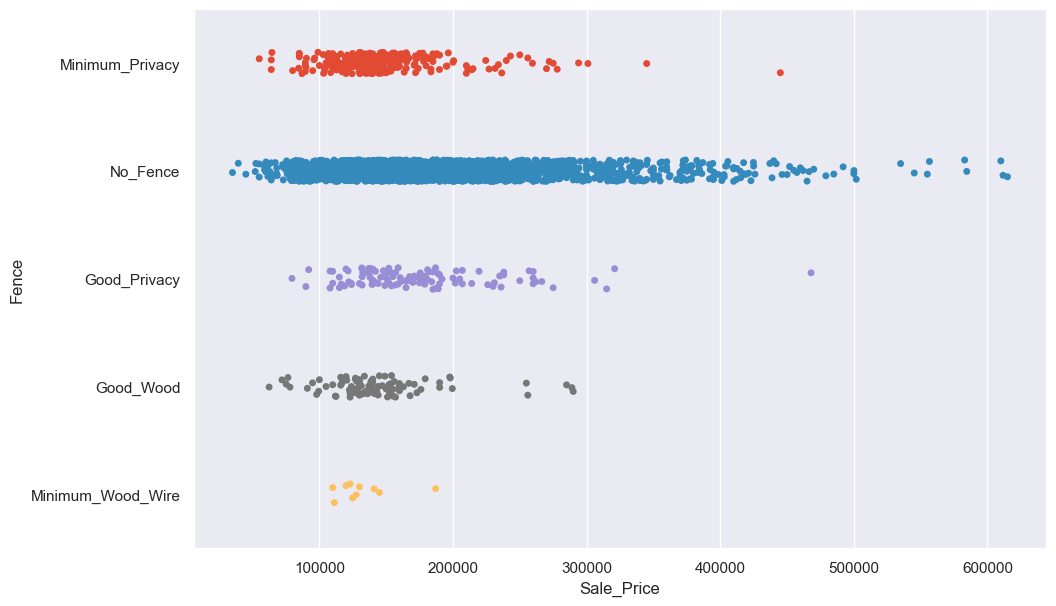

In [148]:
stripplot_single(dataset=df, categ_feat ='Fence', target ='Sale_Price')

As we can see, it is very hard to tell whether this feature matters or not, so it is best to drop it

In [149]:
df.drop(columns=['Fence'], inplace=True)

## Feature Encoding

Now, for the sake of using the ordinal variables, we want to encode them (along with the OHE for the remaining nominal variables). 

Then we will proceed to use the values in order to weight the related numerical features such as the fireplaces, the basement, the garage, external area, and so on

### Ordinal Encoding

We encode all the features which show order in their categories

In [150]:
df.select_dtypes(object).columns

Index(['Bsmt_Cond', 'Bsmt_Exposure', 'Bsmt_Qual', 'Exter_Cond', 'Exter_Qual',
       'Fireplace_Qu', 'Garage_Cond', 'Garage_Finish', 'Garage_Qual',
       'Kitchen_Qual', 'Land_Contour', 'Land_Slope', 'Overall_Cond',
       'Overall_Qual'],
      dtype='object')

In [151]:
df_orig.select_dtypes(object).columns

Index(['BsmtFin_Type_1', 'BsmtFin_Type_2', 'Bsmt_Cond', 'Bsmt_Exposure',
       'Bsmt_Qual', 'Condition_1', 'Condition_2', 'Exter_Cond', 'Exter_Qual',
       'Exterior_1st', 'Exterior_2nd', 'Fence', 'Fireplace_Qu', 'Foundation',
       'Functional', 'Garage_Cond', 'Garage_Finish', 'Garage_Qual', 'Heating',
       'Heating_QC', 'Kitchen_Qual', 'Land_Contour', 'Land_Slope',
       'Lot_Config', 'Lot_Shape', 'MS_SubClass', 'Misc_Feature',
       'Overall_Cond', 'Overall_Qual', 'Paved_Drive', 'Pool_QC', 'Roof_Matl',
       'Roof_Style', 'Sale_Type', 'Utilities'],
      dtype='object')

In [152]:
ordinal_encoding(dataset=df_orig, ord_mapping=ordinal_mapping)

In [153]:
# remove paved_drive
ordinal_mapping.pop(20)

{'Paved_Drive': ['Dirt_Gravel', 'Partial_Pavement', 'Paved']}

In [154]:
ordinal_encoding(dataset=df, ord_mapping=ordinal_mapping)

### Nominal Encoding - One Hot Encoding

We encode the categorical feature that are shown to include useful information and discard the rest

In [155]:
df_orig.select_dtypes(object).columns

Index(['Condition_1', 'Condition_2', 'Exterior_1st', 'Exterior_2nd',
       'Foundation', 'Heating', 'Lot_Config', 'MS_SubClass', 'Misc_Feature',
       'Roof_Matl', 'Roof_Style', 'Sale_Type', 'Utilities'],
      dtype='object')

In [156]:
ohe_encoding(dataset=df, categorical_features=nominal_features)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Baths                         2623 non-null   float64
 1   Bedroom_AbvGr                 2623 non-null   float64
 2   Bsmt                          2623 non-null   int64  
 3   Bsmt_Cond                     2623 non-null   float64
 4   Bsmt_Exposure                 2623 non-null   float64
 5   Bsmt_Full_Bath                2623 non-null   float64
 6   Bsmt_Half_Bath                2623 non-null   float64
 7   Bsmt_Qual                     2623 non-null   float64
 8   Bsmt_Total_Bath               2623 non-null   float64
 9   Bsmt_Unf_SF                   2623 non-null   float64
 10  Central_Air                   2623 non-null   float32
 11  Exter_Cond                    2623 non-null   float64
 12  Exter_Qual                    2623 non-null   float64
 13  Ext

In [158]:
ohe_encoding(dataset=df_orig, categorical_features=nominal_features)

In [159]:
df_orig.select_dtypes(object)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[2930 rows x 0 columns]

### Feature Encoding - To Float 32

In [160]:
df = set_labels_type(dataset=df, labels=(list(df.columns)), np_type='float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623 entries, 0 to 2622
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Baths                         2623 non-null   float32
 1   Bedroom_AbvGr                 2623 non-null   float32
 2   Bsmt                          2623 non-null   float32
 3   Bsmt_Cond                     2623 non-null   float32
 4   Bsmt_Exposure                 2623 non-null   float32
 5   Bsmt_Full_Bath                2623 non-null   float32
 6   Bsmt_Half_Bath                2623 non-null   float32
 7   Bsmt_Qual                     2623 non-null   float32
 8   Bsmt_Total_Bath               2623 non-null   float32
 9   Bsmt_Unf_SF                   2623 non-null   float32
 10  Central_Air                   2623 non-null   float32
 11  Exter_Cond                    2623 non-null   float32
 12  Exter_Qual                    2623 non-null   float32
 13  Ext

In [161]:
df_orig =set_labels_type(dataset=df_orig, labels=(list(df_orig.columns)), np_type='float32')
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Columns: 197 entries, Baths to NoSewr
dtypes: float32(197)
memory usage: 2.2 MB


### Drop of some features that we are not going to use

In [162]:
df.drop(columns=['Garage_Finish','Land_Contour', 'Land_Slope', 'Lot_Frontage', 'LowQ_Total_Liv_Ratio',
                'Low_Qual_Fin_SF'],inplace=True)

## Fine Tuning of our features

Now we proceed with fine tuning the combination of parameters to assess quality and use it along with the area of the related features

### Bsmt_Eval

In [163]:
df['Bsmt_Eval']= (df['Total_Bsmt_SF']) * ((df['Bsmt_Exposure'] * 0.2) + (df['Bsmt_Cond'] * 0.325) + (df['Bsmt_Qual']* 0.475)) *(df['Bsmt'])
df_orig['Bsmt_Eval']= (df_orig['Total_Bsmt_SF']) * ((df_orig['Bsmt_Exposure'] * 0.2) + (df_orig['Bsmt_Cond'] * 0.325) + (df_orig['Bsmt_Qual']* 0.475)) *(df_orig['Bsmt'])

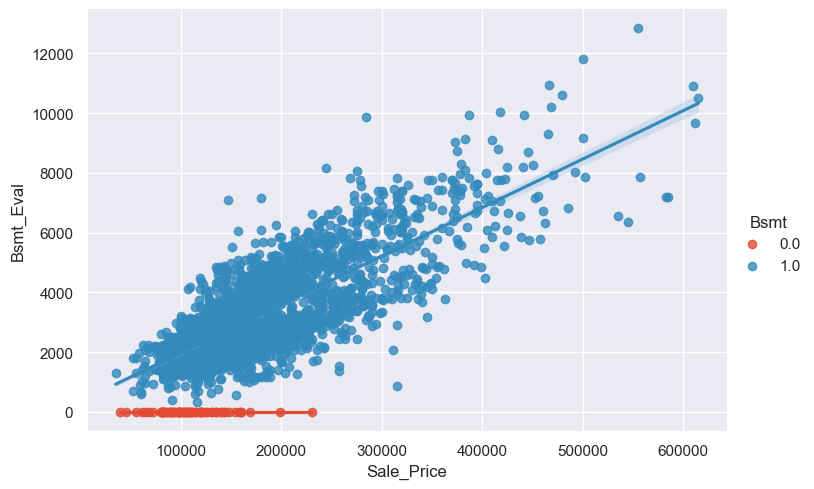

In [164]:
scatterplot_single(df, 'Sale_Price', 'Bsmt_Eval', hue='Bsmt')

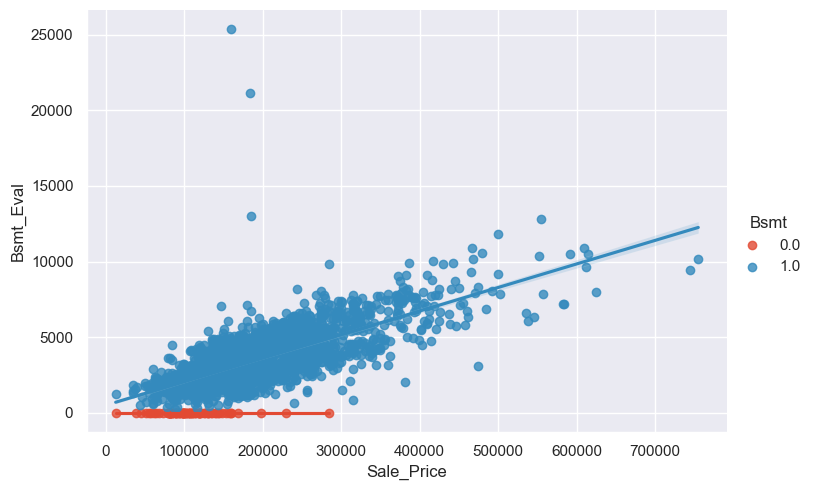

In [165]:
scatterplot_single(df_orig, 'Sale_Price', 'Bsmt_Eval', hue='Bsmt')

This new feature allows us to apply a weighted constant to the area of the basement, in order to penalize bad quality.

No that we included this, we can remove the quality attributes

In [166]:
df.drop(columns=['Bsmt_Exposure', 'Bsmt_Cond', 'Bsmt_Qual'], inplace=True)

### Garage_Eval

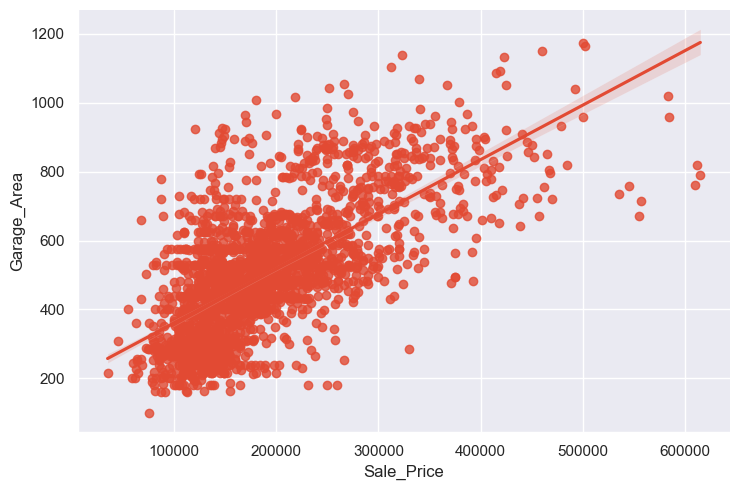

In [167]:
scatterplot_single(df[df['Garage_Area']>0.0], 'Sale_Price', 'Garage_Area')

In [168]:
df['Garage_Eval'] = df['Garage_Area'] * ((df['Garage_Cond']*0.4)+(df['Garage_Qual']*0.6))
df_orig['Garage_Eval'] = df_orig['Garage_Area'] * ((df_orig['Garage_Cond']*0.4)+(df_orig['Garage_Qual']*0.6))

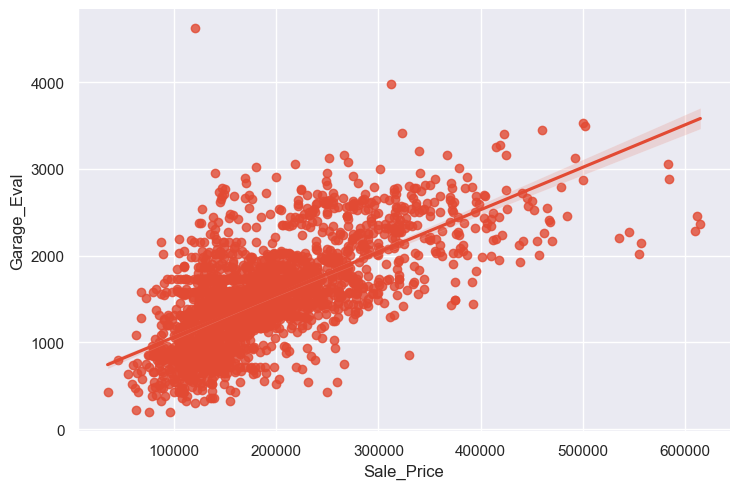

In [169]:
scatterplot_single(df[df['Garage_Area']>0.0], 'Sale_Price', 'Garage_Eval')

It has slightly improved but we cannot really tell before testing it

### Fireplace_Eval

In [170]:
df['Fireplace_Eval'] = df['Fireplace_Gr_Area_Ratio'] * (np.sqrt(df['Fireplace_Qu']))
df_orig['Fireplace_Eval'] = df_orig['Fireplace_Gr_Area_Ratio'] * (np.sqrt(df_orig['Fireplace_Qu']))

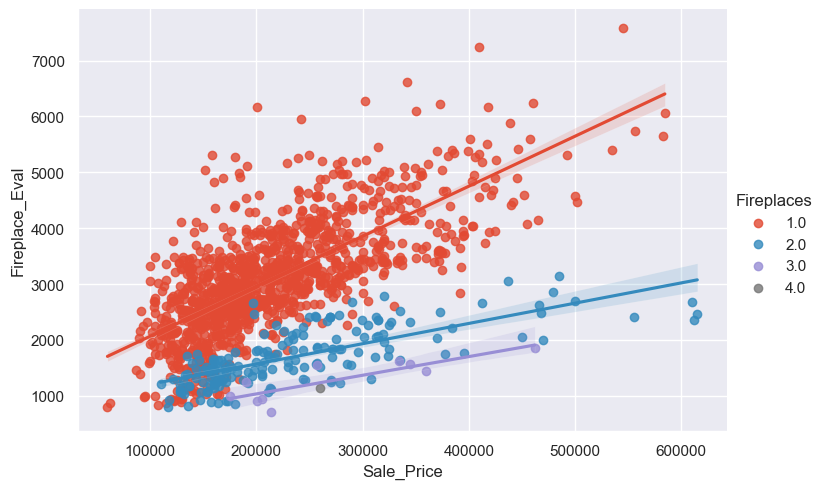

In [171]:
scatterplot_single(df[df['Fireplaces']>0.0], 'Sale_Price', 'Fireplace_Eval', 'Fireplaces')

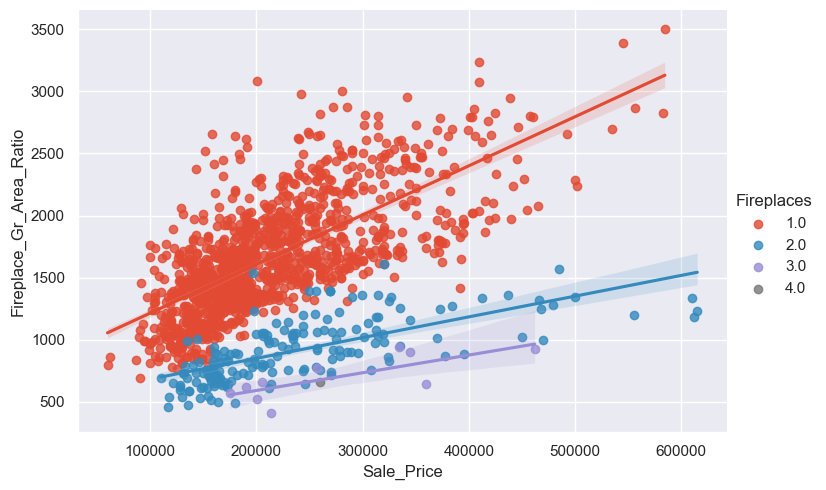

In [172]:
scatterplot_single(df[df['Fireplaces']>0.0], 'Sale_Price', 'Fireplace_Gr_Area_Ratio', 'Fireplaces')

We can discard this feature as it only rescales the existing relationship, but we can confirm `Fireplace_Gr_Area_Ratio` is going to be useful

### External_Eval

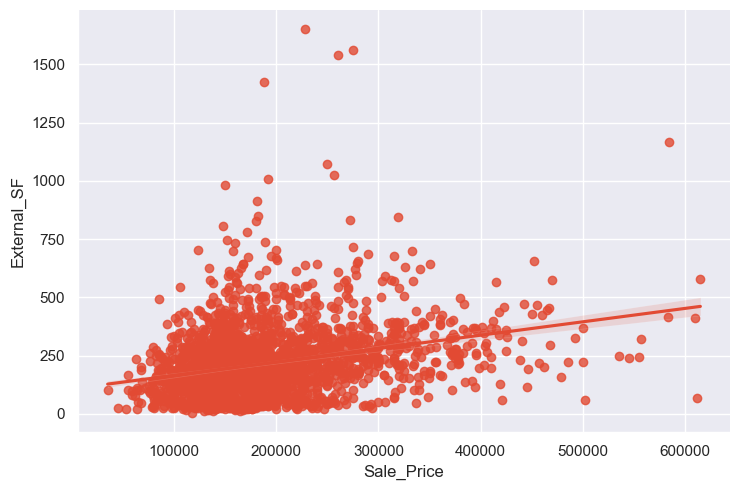

In [173]:
scatterplot_single(df[df['External_SF']>0], 'Sale_Price', 'External_SF')

In [174]:
df['External_Eval'] = df['External_SF'] * ((df['Exter_Cond']*0.3)+ (df['Exter_Qual']*0.7))
df_orig['External_Eval'] = df_orig['External_SF'] * ((df_orig['Exter_Cond']*0.3)+ (df_orig['Exter_Qual']*0.7))

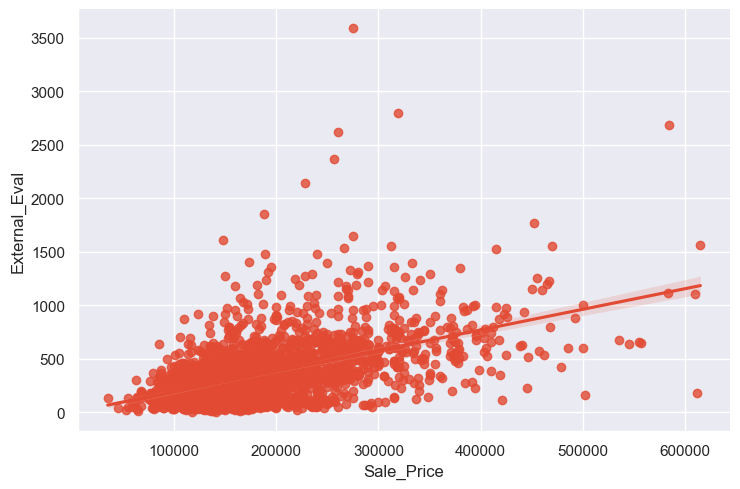

In [175]:
scatterplot_single(df[df['External_SF']>0], 'Sale_Price', 'External_Eval')

The combination has slightly improved the variance, we can keep this for now.

We have enough features to move on

---

### To sum up what we did so far, plus some ideas for later

We performed an exteded analysis on the dataset and added some new features which really are logarithm transfomations of the original ones. Then we started looking at the outliers and removed the ones which looked very far away from the highlighted trends. We added indicators which might be useful for models like the linear ones.

We showed that there might be signals of correlation at some n-dim level in this dataset, but that can be only clear with a more profound look at the data.

Also we performed type conversions, one hot encoding, ordinal encoding, dummy encoding etc...

Next we need to understand what features are usable for our prediction.

In [176]:
df.reset_index(drop=True, inplace=True)
df = sort_alphabetically(df, last_label='Sale_Price')

---

### Save the dataset

In [177]:
df.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_1.csv"))
df_orig.to_csv(os.path.join(RESOURCES_DIR, "ames_housing_out_1_orig.csv"))

---

#### Credits and References
* Thomas Schmitt, [house_prices](https://www.openml.org/search?type=data&sort=runs&id=42165&status=active). OpenML (2019).(accessed April 12, 2023)
* E.J. Martin, [How much is my house worth? A beginner's guide]( https://www.bankrate.com/real-estate/how-much-is-my-house-worth/#faq). Bankrate (2023). (accessed April 12, 2023).
* J. Gomez, [8 critical factors that influence a home’s value](https://www.opendoor.com/articles/factors-that-influence-home-value). Opendoor (4 June 2022). (accessed April 12, 2023).
* [Ames (Iowa)](https://it.wikipedia.org/wiki/Ames_(Iowa)), Wikipedia (2020). (accessed April 12, 2023).
*  Leeclemmer, [Exploratory Data Analysis of Housing in Ames, Iowa](https://www.kaggle.com/code/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa). Kaggle (2017). (accessed April 18, 2023).
* Alvin T. Tan, [Cracking the Ames Housing Dataset with Linear Regression](https://towardsdatascience.com/wrangling-through-dataland-modeling-house-prices-in-ames-iowa-75b9b4086c96). Towards Data Science (2022). (accessed April 19, 2023).
* The Strategic Plan For North Richland Hill, [Land Use Categories](https://www.nrhtx.com/DocumentCenter/View/9222/Draft-Land-Use-Categories?bidId=). North Richland Hills, TX. (accessed April 19, 2023
* [Abnormal Sale](https://payrollheaven.com/define/abnormal-sale/). PayrollHeaven.com. Payroll & Accounting Heaven Ltd. (accessed April 19, 2023).
* Benjamin Dornel, [Project 2: Predicting Housing Prices with Linear Regression](https://www.benjamindornel.com/ames-regression.html). (accessed April 20, 2023).
* Serigne, [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard). Kaggle (2017). (accessed April 20, 2023).
* Gkitchen, [Gimme Shelter 🏠 SCORE 0.12630](https://www.kaggle.com/code/gkitchen/gimme-shelter-score-0-12630). Kaggle (2017). (accessed April 20, 2023).
* Hussein Ali, [House Price - Advanced Regression](https://www.kaggle.com/code/thisishusseinali/house-price-advanced-regression). Kaggle (2017). (accessed April 20, 2023).
* Rushikesh Sawarkar, [House Prices - Pipeline, Ensemble Models](https://www.kaggle.com/code/rushikeshsawarkar/0-12018-house-prices-pipeline-ensemble-models). Kaggle (2017). (accessed April 20, 2023).
* J. Ostrowski, [What is the best time of year to sell a house?](https://www.bankrate.com/real-estate/best-time-to-sell-house/) Bankrate (2022). (accessed April 20, 2023).